In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import json
from google.colab import drive

In [2]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/"

Mounted at /content/drive


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print(type(x_train), x_train.dtype)
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
<class 'numpy.ndarray'> float64


(((60000, 28, 28), (60000, 10)), ((10000, 28, 28), (10000, 10)))

In [4]:
def get_discriminator(leaky_relu_slope=0.2, depth=4):
    image_input = Input(shape=(28, 28, 1))
    x_fl = Flatten()(image_input)
    x_fl = Dropout(0.4)(x_fl)
    x_fl = Dense(256, LeakyReLU(alpha=leaky_relu_slope))(x_fl)

    x = image_input
    inp_cl = Input((10,))
    x_cl = Dropout(0.4)(inp_cl)
    x_cl = Dense(712,LeakyReLU(alpha=leaky_relu_slope))(x_cl)

    for _ in range(depth):
        x = Conv2D(
            50, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = BatchNormalization(scale=False)(x)
        x = LeakyReLU(alpha=leaky_relu_slope)(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, LeakyReLU(alpha=leaky_relu_slope))(x)
    x = concatenate([x,x_cl,x_fl])
    x = Dropout(0.4)(x)
    x = Dense(256, LeakyReLU(alpha=leaky_relu_slope))(x)
    x = Dropout(0.4)(x)
    output_score = Dense(1)(x)
    return tf.keras.Model([image_input,inp_cl], output_score, name="discriminator")


model_d = get_discriminator()
model_d.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 50)   800         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 50)  150         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 14, 14, 50)   0           ['batch_normalization

In [5]:
inp_cl = Input((10,))
inp2 = Input((100,))

x = Dense(50, "relu")(inp2)
x_cl = Dense(20, "relu")(inp_cl)
x_cl = Dense(200, "relu")(x_cl)

x = concatenate([x_cl, x])
x = BatchNormalization(scale=True)(x)
x = Dense(300, "relu")(x)
x = BatchNormalization(scale=True)(x)
x = Dense(500, "relu")(x)
x = BatchNormalization(scale=True)(x)
x = Dense(28*28, "relu")(x)

x0 = Reshape((28,28,1))(x)

x1 = Conv2D(16, (3, 3), activation="relu", padding="same")(x0)
x = BatchNormalization(scale=True)(x1)
x2 = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization(scale=True)(x2)
x3 = Conv2D(64, (3, 3), activation="relu",padding="same")(x)
x = BatchNormalization(scale=True)(x3)
x = Conv2D(128, (3, 3), activation="relu",padding="same")(x)
x = BatchNormalization(scale=True)(x)
x = concatenate([x1,x,x0])
x = Conv2D(64, (3, 3), activation="relu",padding="same")(x)
x = BatchNormalization(scale=True)(x)
x = concatenate([x2,x1,x,x0])
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = concatenate([x0,x1,x3,x2,x])
x = BatchNormalization(scale=True)(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3),activation="relu", padding="same")(x)
x = Conv2D(8, (2, 2),activation="relu", padding="same")(x)

out2 = Conv2D(1, (2, 2), activation="sigmoid", padding="same")(x)

model_noise = tf.keras.Model([inp2, inp_cl], out2, name="gen_img")
model_noise.summary()

Model: "gen_img"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 20)           220         ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 200)          4200        ['dense_6[0][0]']                
                                                                                            

In [6]:
def step(values):
    # negative values -> 0.0, positive values -> 1.0
    return 0.5 * (1.0 + tf.sign(values))


class GAN(tf.keras.Model):

    def __init__(self, model_noise, model_discremenator,path=""):
        super(GAN, self).__init__()
        self.discremenator = model_discremenator
        self.model_noiser = model_noise

        self.path = path
        self.__class_img = tf.keras.utils.to_categorical([i for i in range(10)], 10)
        self.__noise = tf.random.normal([10, 100], dtype=float)

    def adversarial_loss(self, real_logits, generated_logits):
        real_labels = tf.ones(shape=(real_logits.shape[0], 1))
        generated_labels = tf.zeros(shape=(generated_logits.shape[0], 1))

        generator_loss = tf.keras.losses.mse(
            real_labels, generated_logits
        )
        discriminator_loss = tf.keras.losses.mse(
            tf.concat([real_labels, generated_labels], axis=0),tf.concat([real_logits, generated_logits], axis=0)
        )
        # tf.keras.losses.binary_crossentropy from_logits=True,

        return tf.reduce_mean(generator_loss), tf.reduce_mean(discriminator_loss)

    def compile(
            self,
            opt_noiser, opt_discriminator,
            metric_noiser, metric_discriminator, **kwargs
    ):
        super().compile(**kwargs)

        self.opt_noiser = opt_noiser
        self.opt_discriminator = opt_discriminator

        self.metric_noiser = metric_noiser
        self.metric_discriminator = metric_discriminator

    def train_step(self, data):
        real_images, real_cls = data
        n = real_images.shape[0]
        noise = tf.random.normal([n, 100], dtype=tf.float32)
        noise_cl = real_cls

        with tf.GradientTape() as noiser_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as cl_tape:
            gen_img = self.model_noiser([noise, noise_cl], training=True)

            disc_img_real = self.discremenator([real_images,real_cls], training=True)
            disc_img_noise = self.discremenator([gen_img,noise_cl], training=True)

            gen_loss, real_loss = self.adversarial_loss(disc_img_real, disc_img_noise)


        grad_noise = noiser_tape.gradient(gen_loss, self.model_noiser.trainable_weights)
        grad_disc = disc_tape.gradient(real_loss, self.discremenator.trainable_weights)

        self.opt_noiser.apply_gradients(zip(grad_noise, self.model_noiser.trainable_weights))
        self.opt_discriminator.apply_gradients(zip(grad_disc, self.discremenator.trainable_weights))

        self.metric_discriminator.update_state(1.0, step(disc_img_real))
        self.metric_noiser.update_state(0.0, step(disc_img_noise))

        return {
            "acc_disc": self.metric_discriminator.result(),
            "acc_gen": self.metric_noiser.result(),
            "loss": gen_loss + real_loss,
            "gen_loss": gen_loss,
            "real_loss": real_loss
        }

    def plot_images(self, epoch=None, logs=None, num_rows=2, num_cols=5, interval=2):

        num_images = num_rows * num_cols
        generated_images = model_noise([self.__noise, self.__class_img])
        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index], cmap="Greys")
                plt.axis("off")
        plt.tight_layout()
        plt.savefig(f'{self.path}image_at_epoch{epoch}.png')
        plt.show()

        if epoch % 25 == 0 and epoch:
          self.discremenator.save(f"{self.path}Model disc ep{epoch}")
          self.model_noiser.save(f"{self.path}Model gen ep{epoch}")



def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
noise_acc = tf.keras.metrics.BinaryAccuracy(name="gen_acc")
disc_acc = tf.keras.metrics.BinaryAccuracy(name="disc_acc")



model = GAN(model_noise, model_d,path=path)
model.compile(
    generator_optimizer, discriminator_optimizer,
noise_acc, disc_acc
)

Epoch 1/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9412 - acc_gen: 0.1195 - loss: 0.6897 - gen_loss: 0.3968 - real_loss: 0.2929

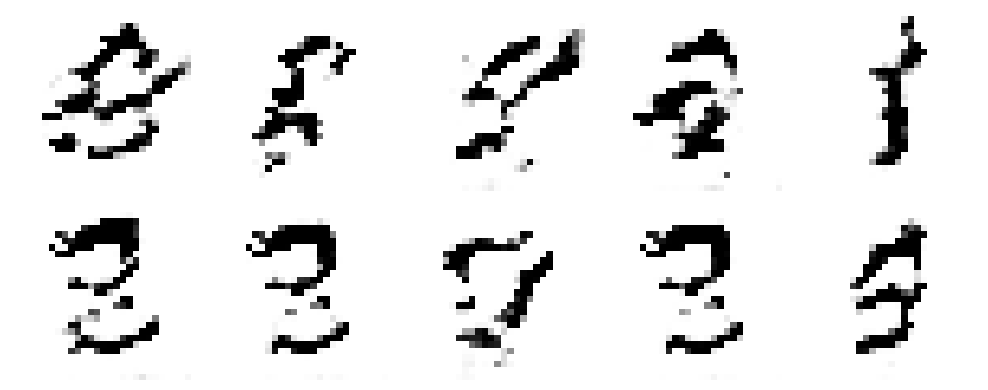

1000/1000 [==============================] - 76s 49ms/step - acc_disc: 0.9413 - acc_gen: 0.1194 - loss: 0.6896 - gen_loss: 0.3968 - real_loss: 0.2928
Epoch 2/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9963 - acc_gen: 0.0062 - loss: 0.5704 - gen_loss: 0.3004 - real_loss: 0.2700

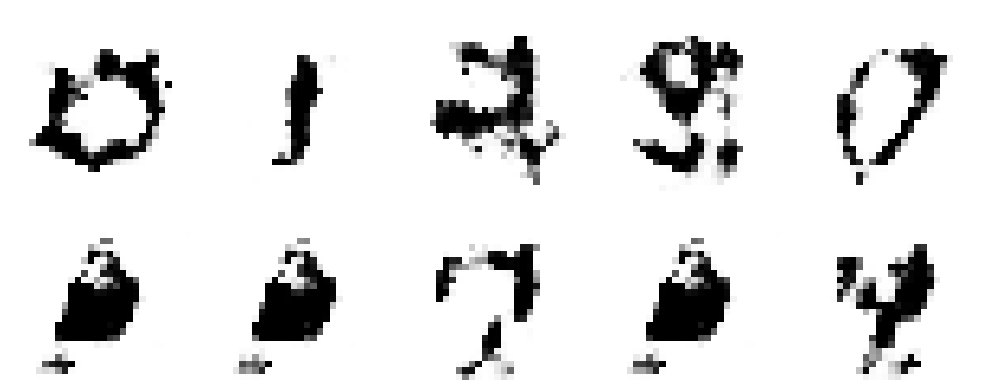

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9963 - acc_gen: 0.0062 - loss: 0.5703 - gen_loss: 0.3004 - real_loss: 0.2699
Epoch 3/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 8.1508e-05 - loss: 0.5380 - gen_loss: 0.2750 - real_loss: 0.2629

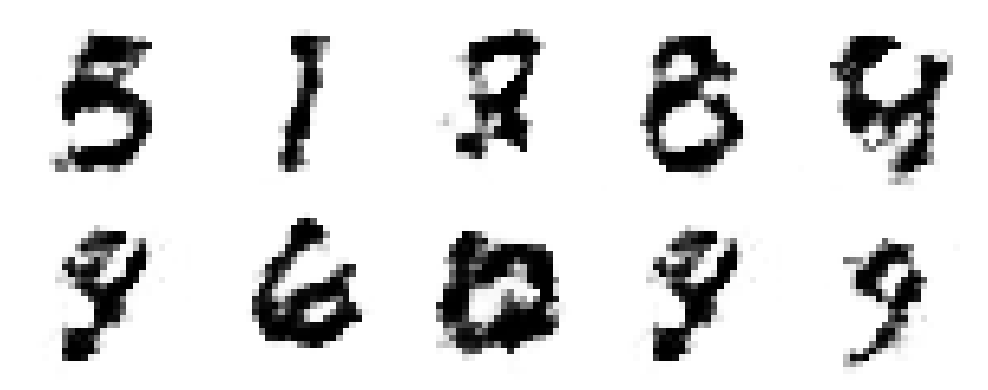

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 8.1479e-05 - loss: 0.5380 - gen_loss: 0.2750 - real_loss: 0.2630
Epoch 4/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5257 - gen_loss: 0.2658 - real_loss: 0.2599

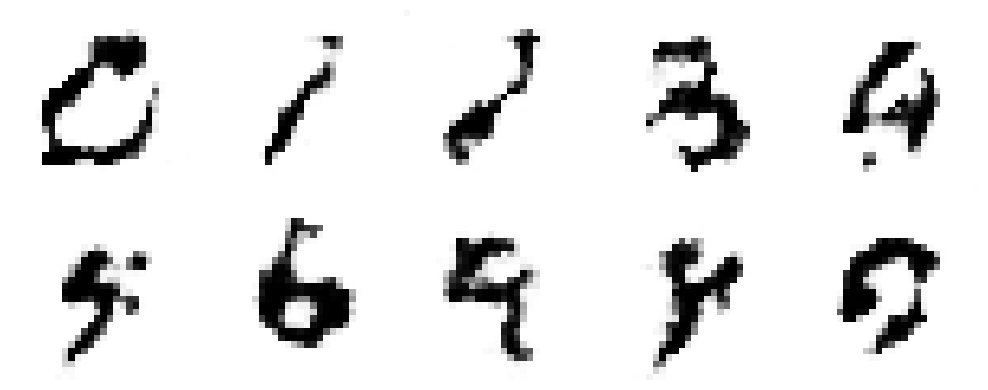

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5257 - gen_loss: 0.2658 - real_loss: 0.2599
Epoch 5/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5187 - gen_loss: 0.2608 - real_loss: 0.2579

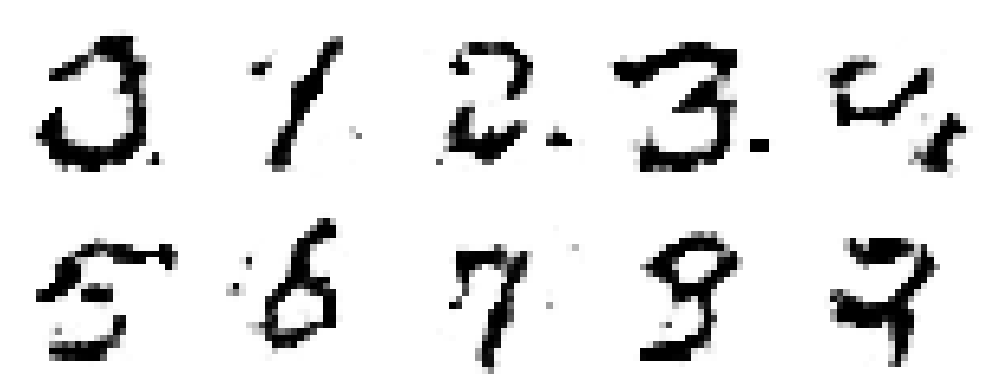

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5186 - gen_loss: 0.2607 - real_loss: 0.2579
Epoch 6/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5132 - gen_loss: 0.2575 - real_loss: 0.2557

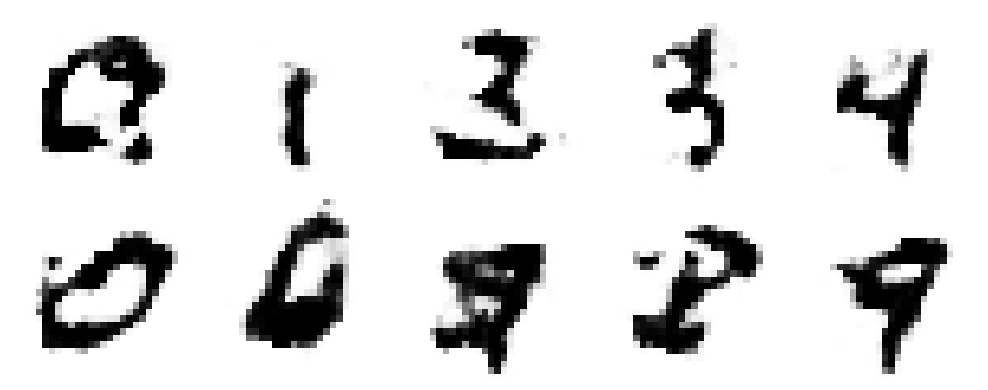

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5132 - gen_loss: 0.2575 - real_loss: 0.2557
Epoch 7/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5104 - gen_loss: 0.2563 - real_loss: 0.2541

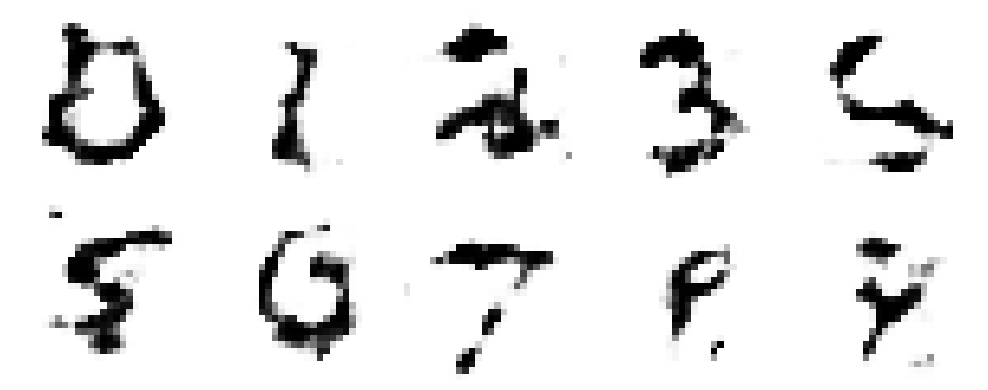

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5104 - gen_loss: 0.2563 - real_loss: 0.2541
Epoch 8/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5092 - gen_loss: 0.2559 - real_loss: 0.2533

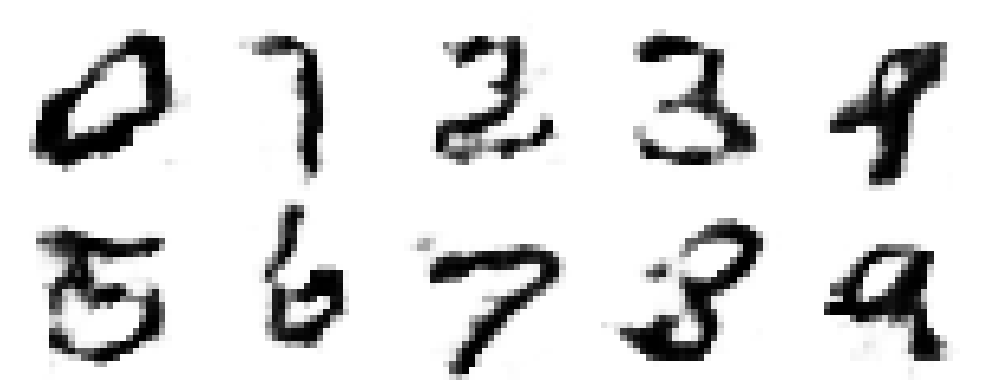

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5092 - gen_loss: 0.2559 - real_loss: 0.2533
Epoch 9/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5078 - gen_loss: 0.2549 - real_loss: 0.2529

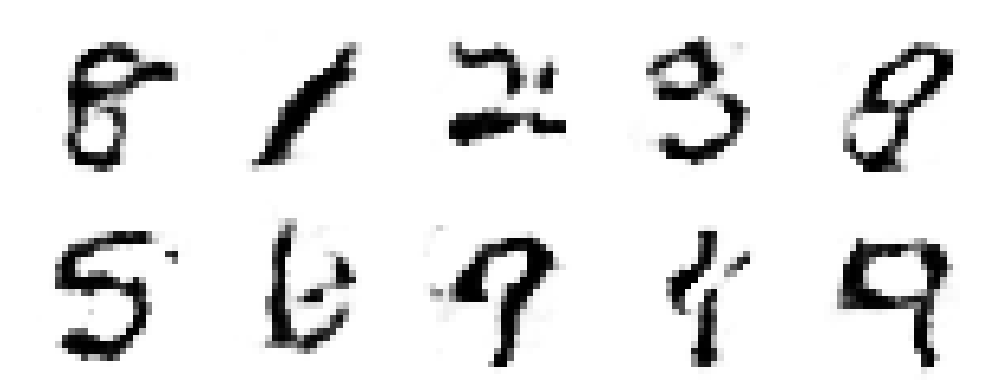

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5078 - gen_loss: 0.2549 - real_loss: 0.2529
Epoch 10/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5063 - gen_loss: 0.2543 - real_loss: 0.2520

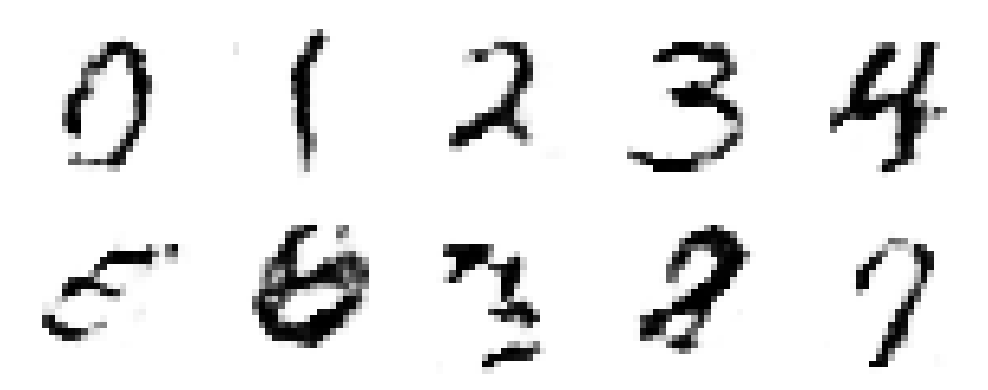

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5063 - gen_loss: 0.2543 - real_loss: 0.2520
Epoch 11/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5054 - gen_loss: 0.2534 - real_loss: 0.2520

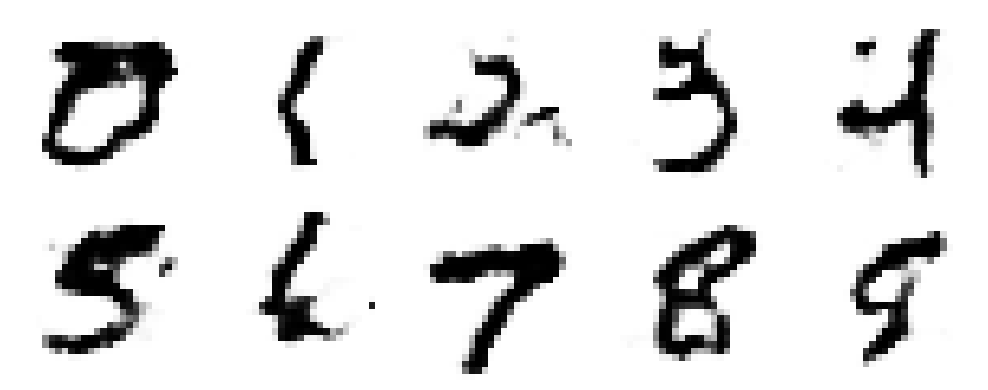

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5054 - gen_loss: 0.2534 - real_loss: 0.2520
Epoch 12/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5040 - gen_loss: 0.2526 - real_loss: 0.2514

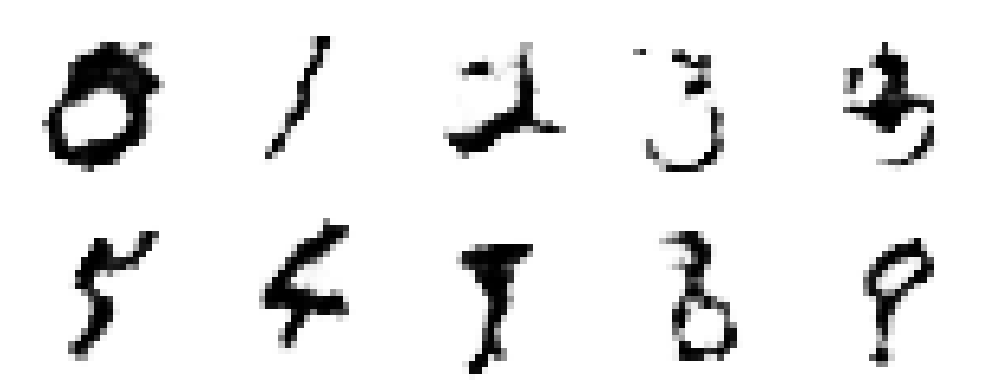

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5040 - gen_loss: 0.2526 - real_loss: 0.2514
Epoch 13/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5039 - gen_loss: 0.2530 - real_loss: 0.2509

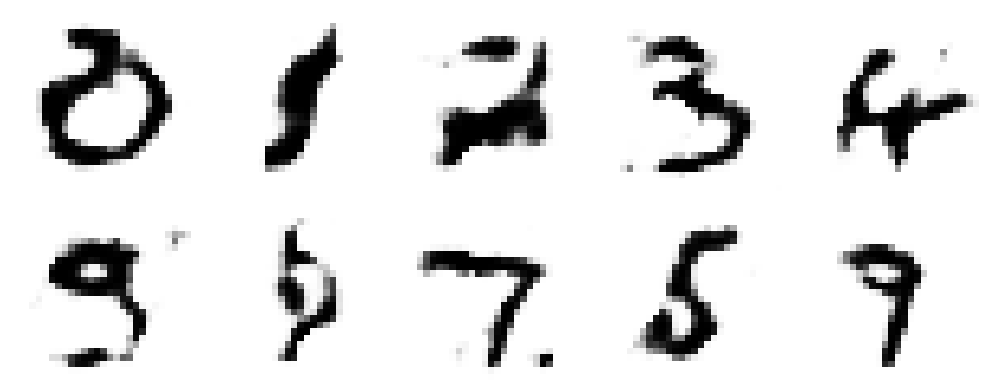

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5039 - gen_loss: 0.2529 - real_loss: 0.2509
Epoch 14/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5029 - gen_loss: 0.2522 - real_loss: 0.2508

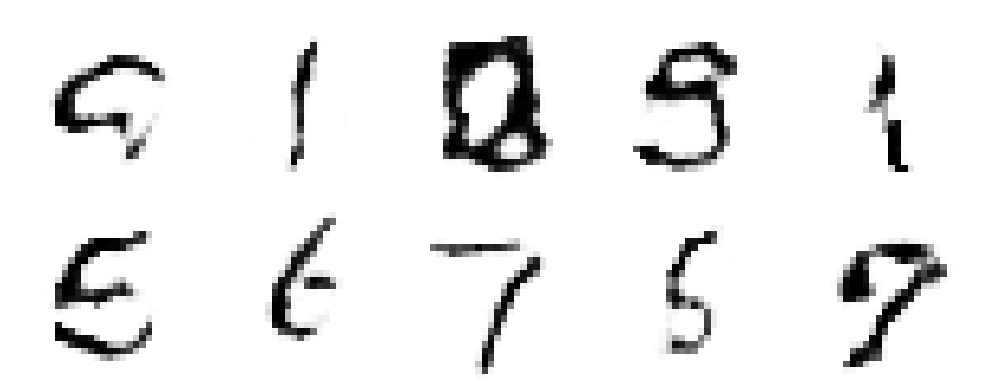

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5029 - gen_loss: 0.2522 - real_loss: 0.2508
Epoch 15/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5027 - gen_loss: 0.2521 - real_loss: 0.2506

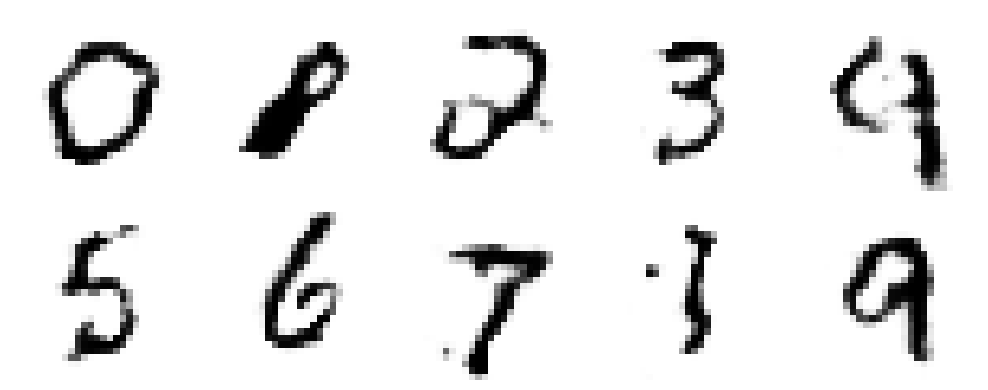

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5027 - gen_loss: 0.2521 - real_loss: 0.2506
Epoch 16/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5022 - gen_loss: 0.2518 - real_loss: 0.2504

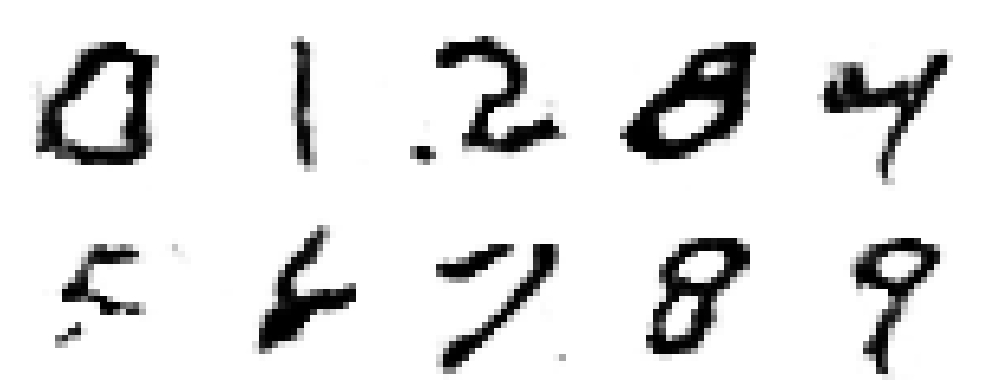

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5022 - gen_loss: 0.2518 - real_loss: 0.2504
Epoch 17/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5026 - gen_loss: 0.2526 - real_loss: 0.2500

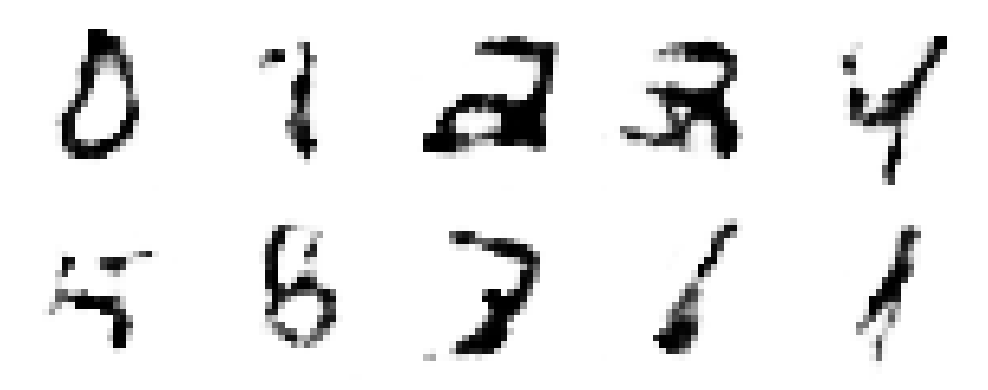

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5026 - gen_loss: 0.2526 - real_loss: 0.2500
Epoch 18/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5031 - gen_loss: 0.2540 - real_loss: 0.2491

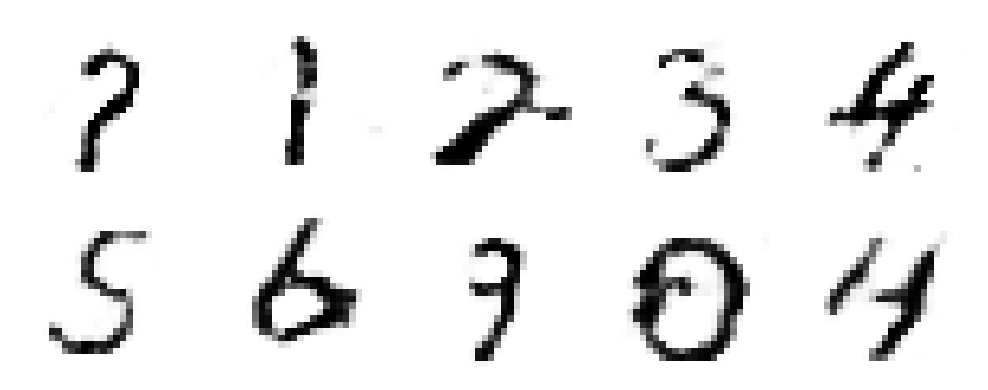

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5031 - gen_loss: 0.2540 - real_loss: 0.2491
Epoch 19/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5056 - gen_loss: 0.2572 - real_loss: 0.2484

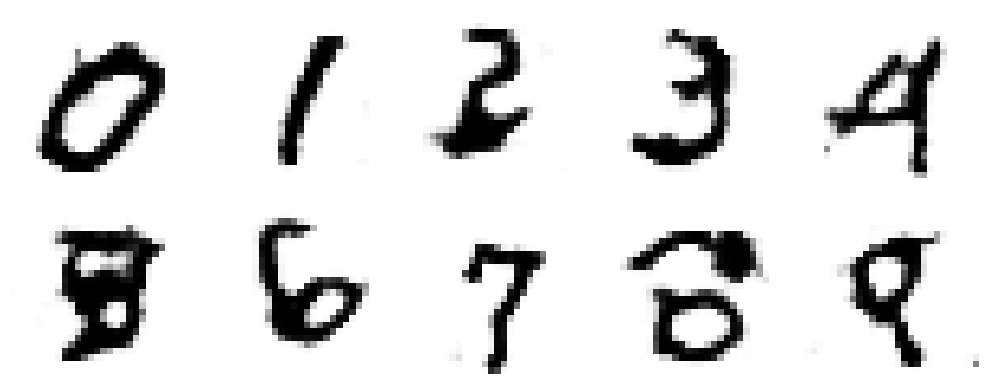

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5056 - gen_loss: 0.2572 - real_loss: 0.2484
Epoch 20/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 1.2833e-06 - loss: 0.5086 - gen_loss: 0.2624 - real_loss: 0.2462

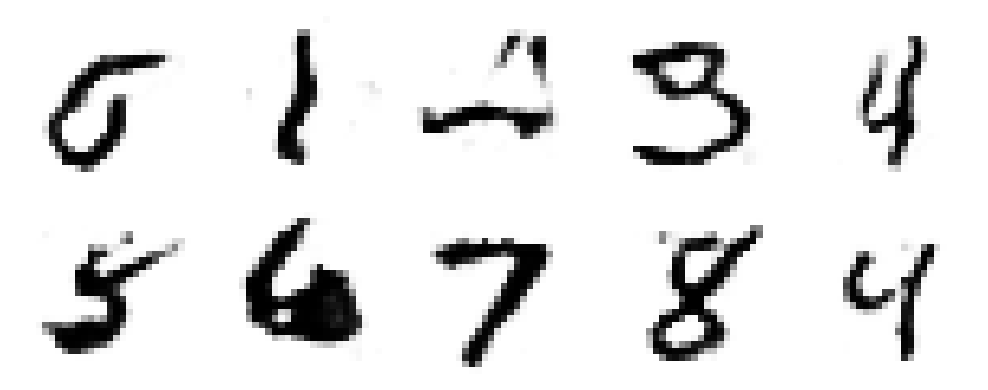

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 1.3140e-06 - loss: 0.5086 - gen_loss: 0.2624 - real_loss: 0.2462
Epoch 21/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 2.3621e-05 - loss: 0.5136 - gen_loss: 0.2687 - real_loss: 0.2449

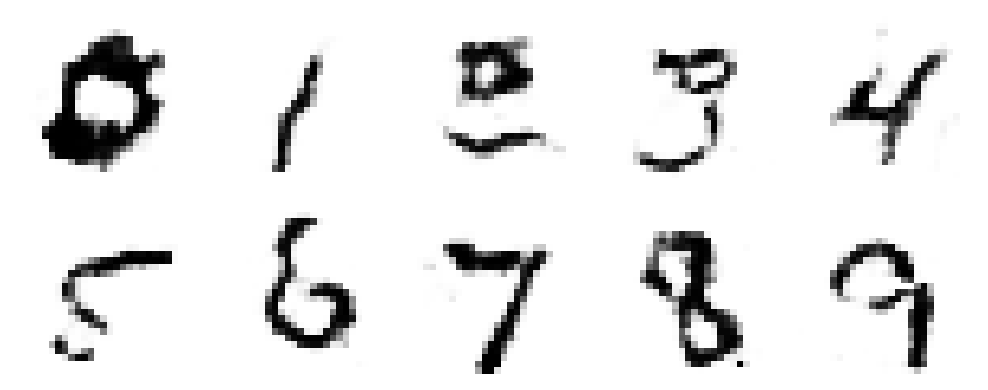

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 2.3614e-05 - loss: 0.5136 - gen_loss: 0.2687 - real_loss: 0.2449
Epoch 22/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5033 - gen_loss: 0.2526 - real_loss: 0.2506

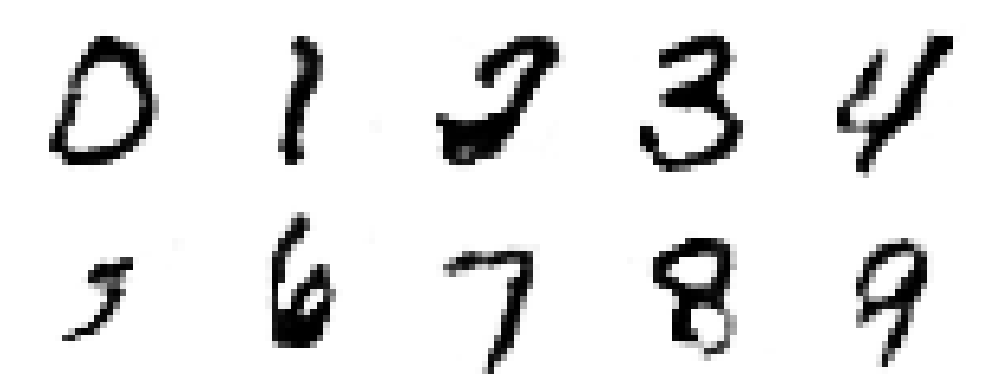

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5033 - gen_loss: 0.2526 - real_loss: 0.2506
Epoch 23/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5019 - gen_loss: 0.2518 - real_loss: 0.2501

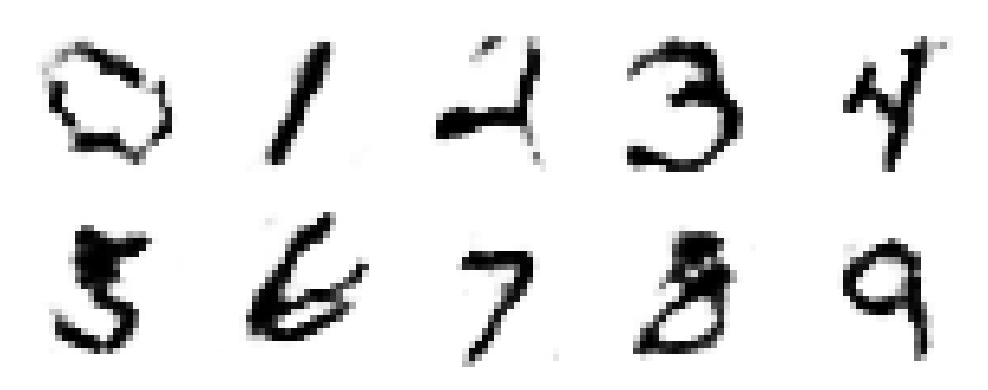

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5019 - gen_loss: 0.2517 - real_loss: 0.2501
Epoch 24/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5013 - gen_loss: 0.2510 - real_loss: 0.2504

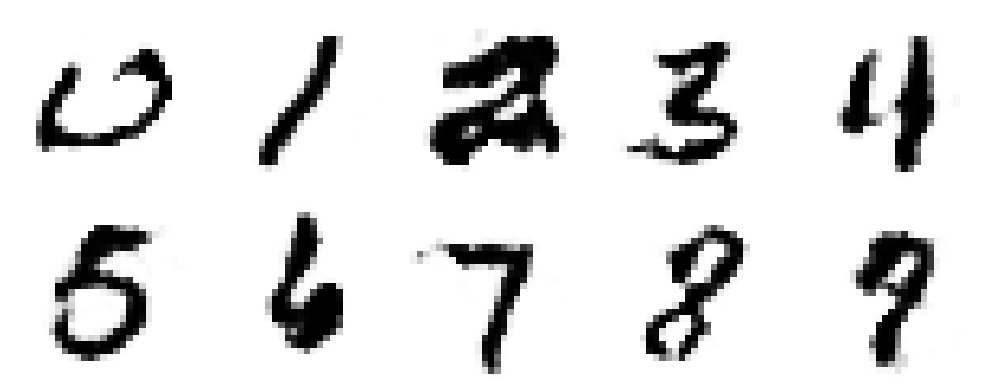

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5013 - gen_loss: 0.2510 - real_loss: 0.2504
Epoch 25/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5012 - gen_loss: 0.2509 - real_loss: 0.2502

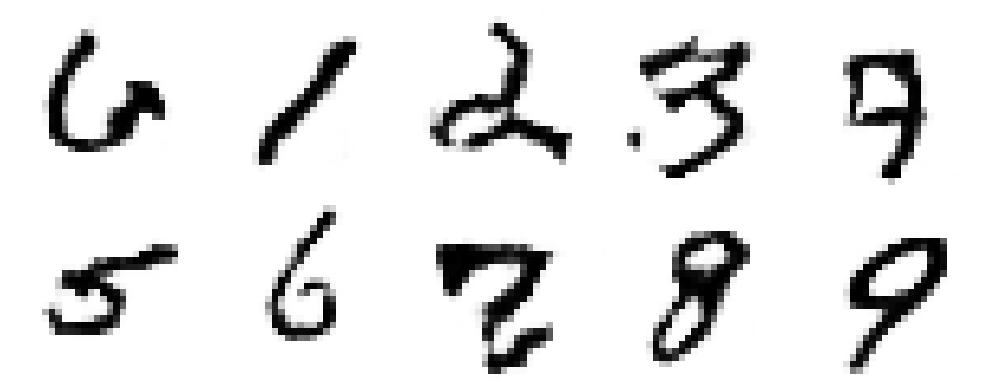

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5012 - gen_loss: 0.2509 - real_loss: 0.2502
Epoch 26/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5011 - gen_loss: 0.2509 - real_loss: 0.2502

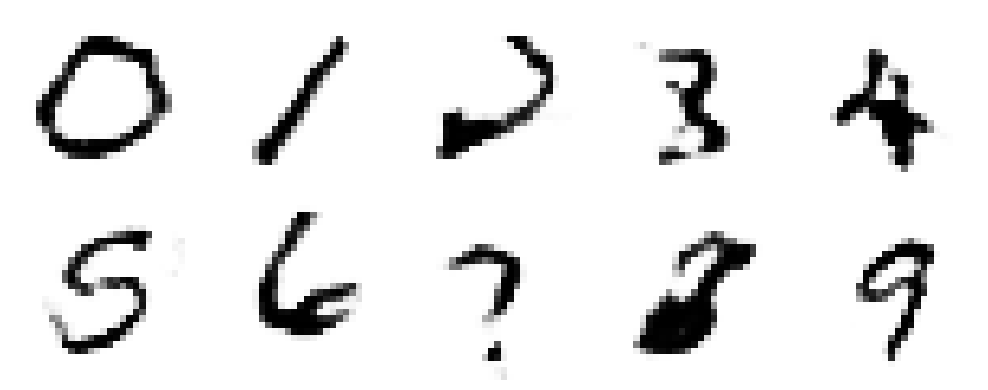

1000/1000 [==============================] - 59s 59ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5011 - gen_loss: 0.2509 - real_loss: 0.2502
Epoch 27/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5012 - gen_loss: 0.2511 - real_loss: 0.2501

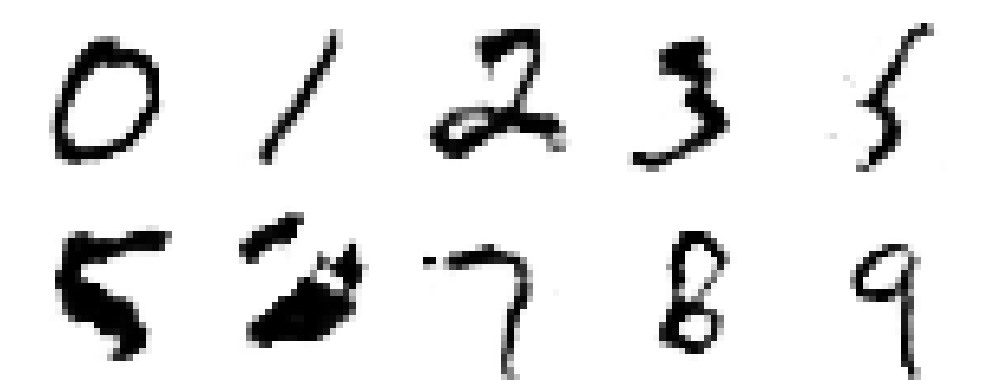

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5012 - gen_loss: 0.2511 - real_loss: 0.2501
Epoch 28/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5011 - gen_loss: 0.2512 - real_loss: 0.2499

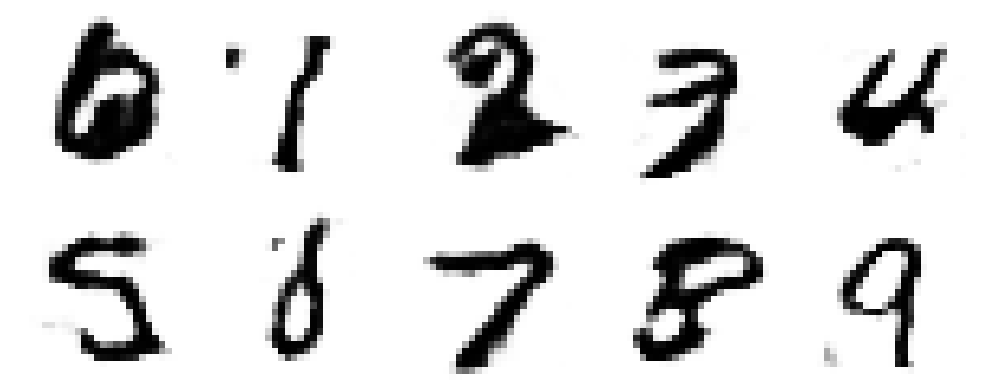

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5012 - gen_loss: 0.2512 - real_loss: 0.2499
Epoch 29/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5021 - gen_loss: 0.2524 - real_loss: 0.2497

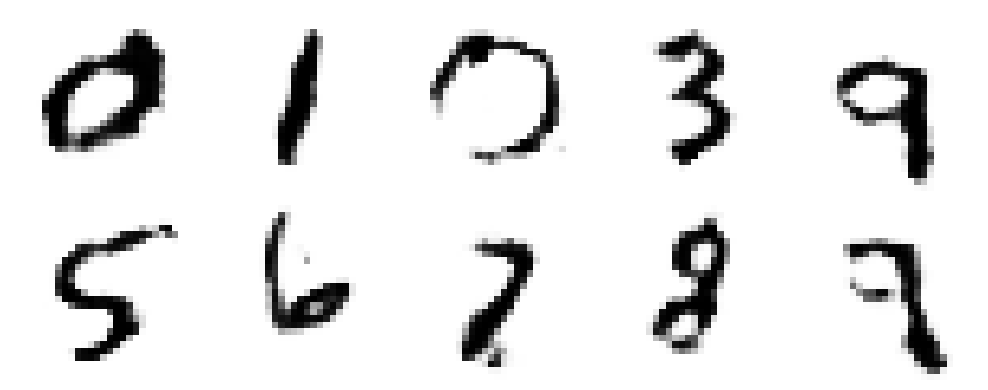

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5021 - gen_loss: 0.2524 - real_loss: 0.2497
Epoch 30/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5049 - gen_loss: 0.2567 - real_loss: 0.2482

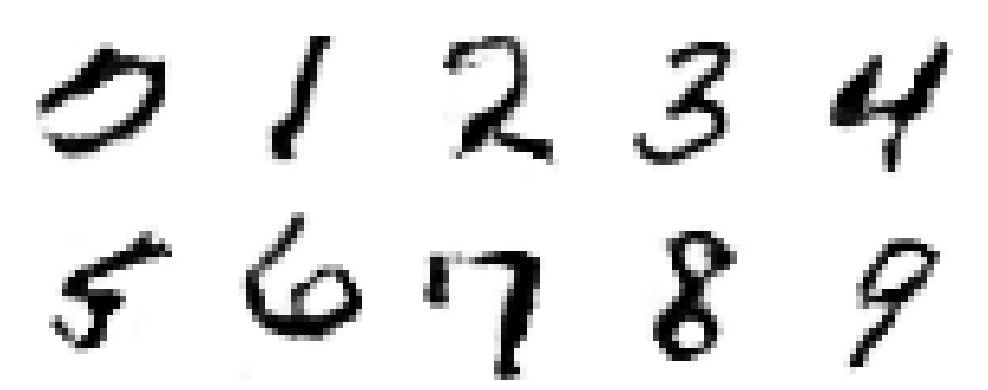

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5049 - gen_loss: 0.2567 - real_loss: 0.2482
Epoch 31/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5039 - gen_loss: 0.2550 - real_loss: 0.2490

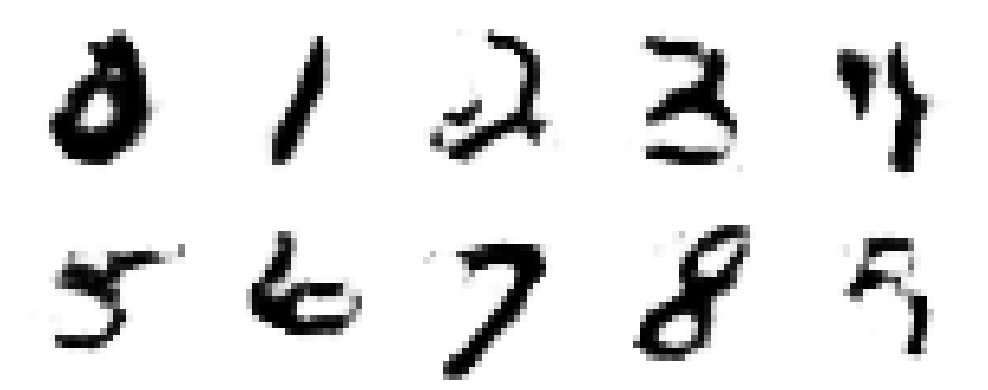

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5039 - gen_loss: 0.2550 - real_loss: 0.2490
Epoch 32/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5070 - gen_loss: 0.2595 - real_loss: 0.2475

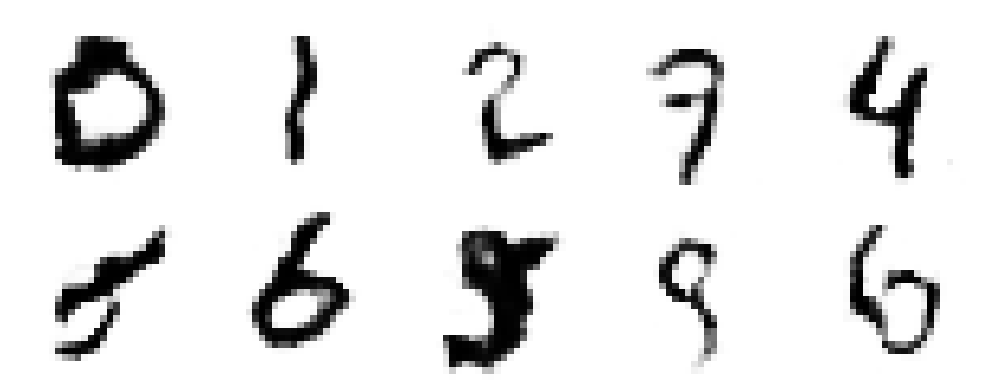

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5070 - gen_loss: 0.2595 - real_loss: 0.2475
Epoch 33/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5054 - gen_loss: 0.2574 - real_loss: 0.2480

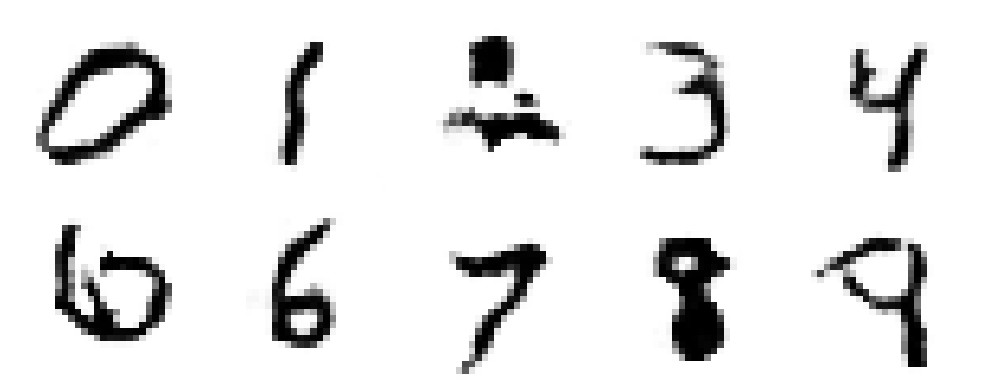

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5054 - gen_loss: 0.2574 - real_loss: 0.2480
Epoch 34/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5031 - gen_loss: 0.2541 - real_loss: 0.2490

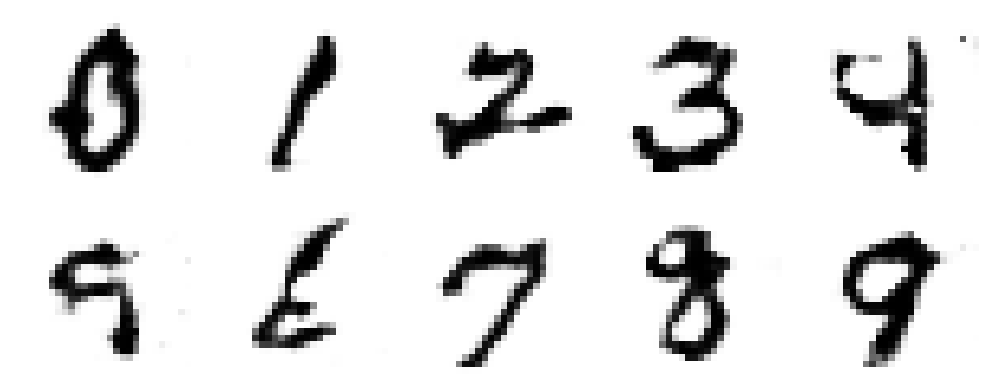

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5032 - gen_loss: 0.2542 - real_loss: 0.2490
Epoch 35/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5056 - gen_loss: 0.2572 - real_loss: 0.2485

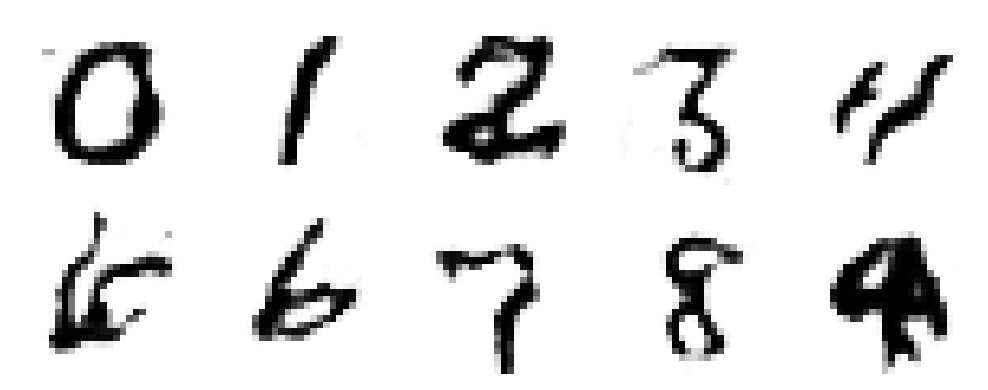

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5056 - gen_loss: 0.2572 - real_loss: 0.2485
Epoch 36/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5049 - gen_loss: 0.2570 - real_loss: 0.2480

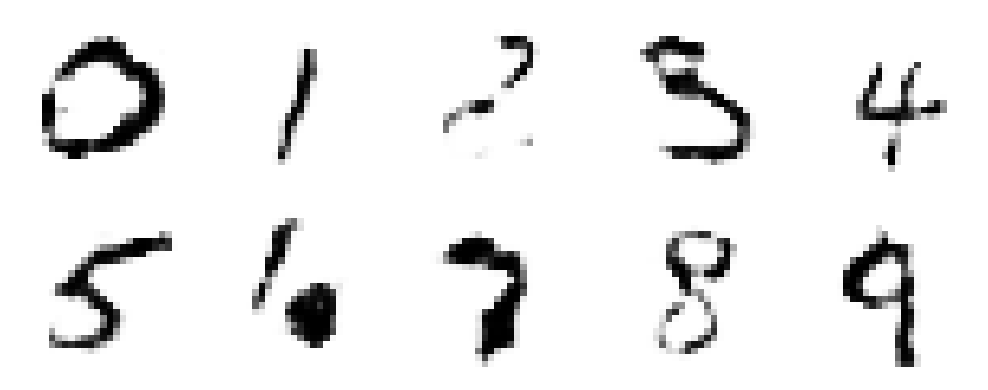

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5049 - gen_loss: 0.2569 - real_loss: 0.2480
Epoch 37/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 1.4848e-05 - loss: 0.5087 - gen_loss: 0.2624 - real_loss: 0.2463

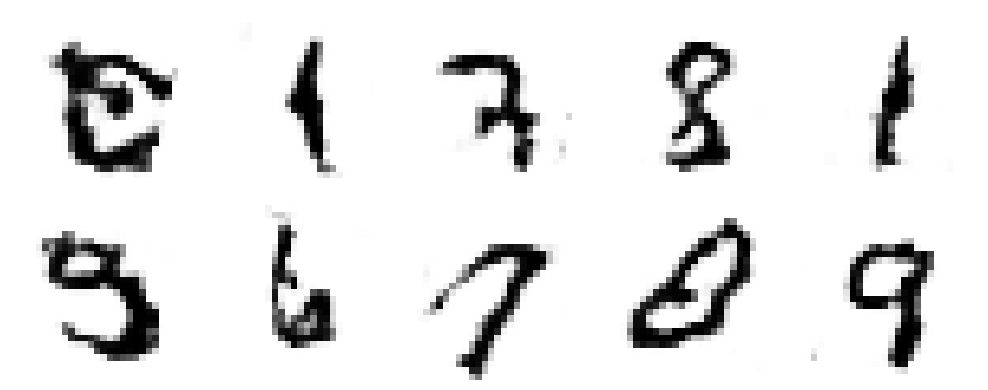

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 1.4850e-05 - loss: 0.5087 - gen_loss: 0.2624 - real_loss: 0.2463
Epoch 38/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 1.8668e-04 - loss: 0.5179 - gen_loss: 0.2768 - real_loss: 0.2411

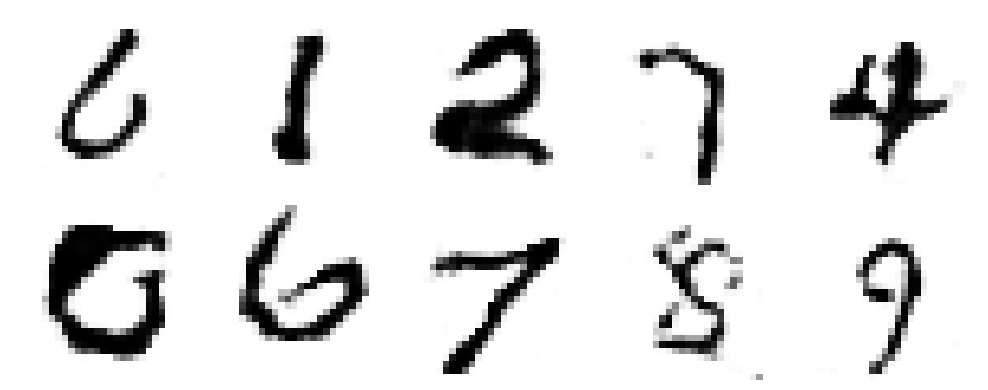

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 1.8665e-04 - loss: 0.5179 - gen_loss: 0.2768 - real_loss: 0.2411
Epoch 39/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 7.1813e-05 - loss: 0.5205 - gen_loss: 0.2808 - real_loss: 0.2397

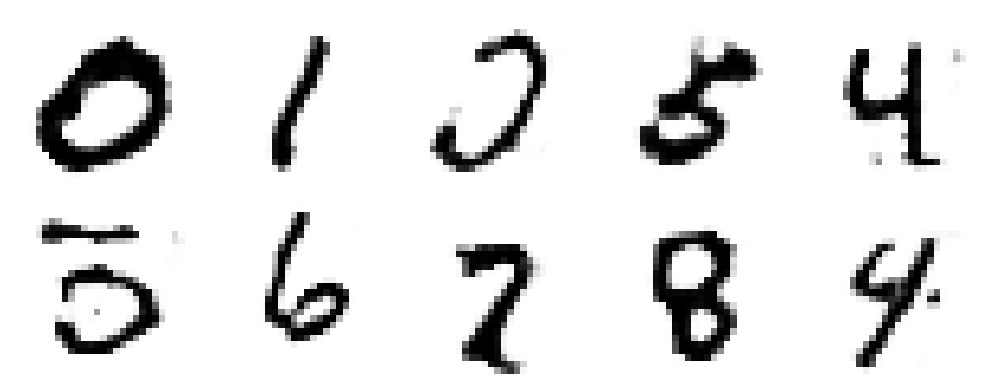

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 7.1870e-05 - loss: 0.5204 - gen_loss: 0.2808 - real_loss: 0.2397
Epoch 40/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 3.2561e-05 - loss: 0.5139 - gen_loss: 0.2696 - real_loss: 0.2443

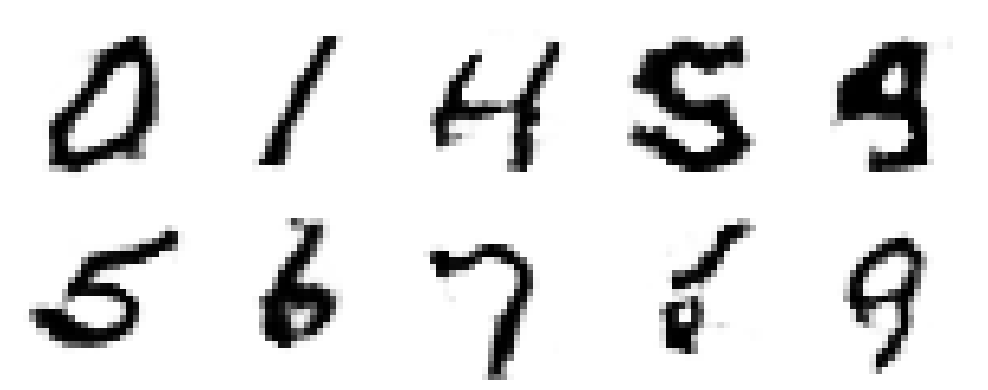

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 3.2596e-05 - loss: 0.5139 - gen_loss: 0.2695 - real_loss: 0.2443
Epoch 41/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5047 - gen_loss: 0.2553 - real_loss: 0.2494

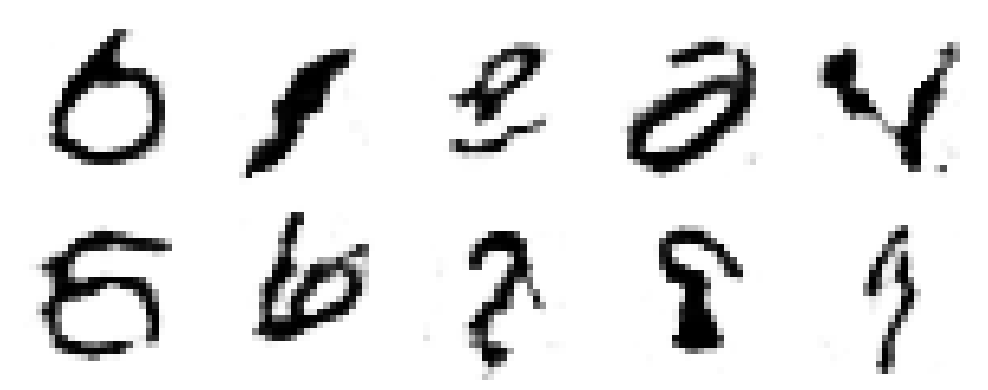

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5047 - gen_loss: 0.2553 - real_loss: 0.2494
Epoch 42/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5107 - gen_loss: 0.2664 - real_loss: 0.2443

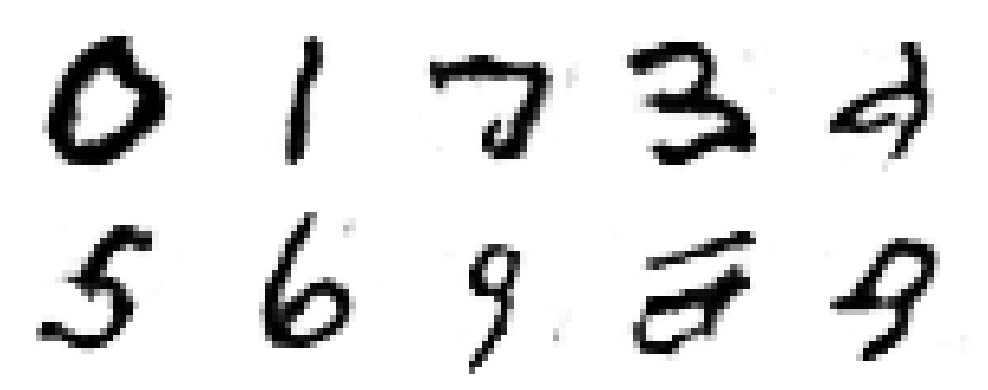

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0000e+00 - loss: 0.5107 - gen_loss: 0.2664 - real_loss: 0.2443
Epoch 43/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 7.5651e-05 - loss: 0.5147 - gen_loss: 0.2714 - real_loss: 0.2433

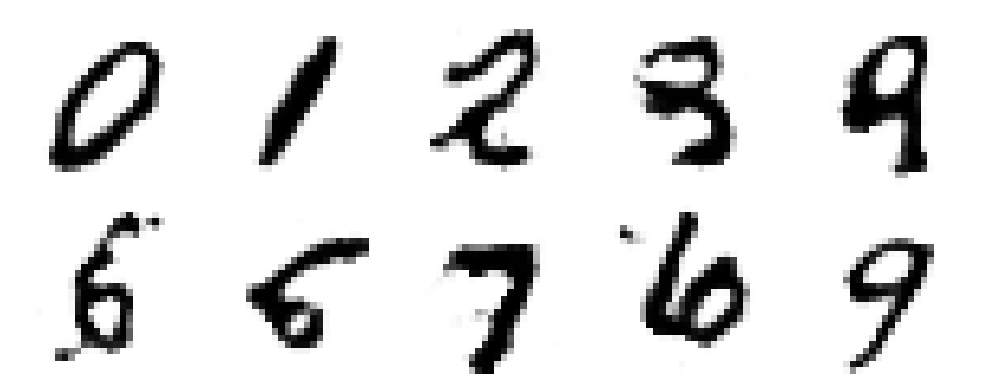

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 7.5599e-05 - loss: 0.5147 - gen_loss: 0.2714 - real_loss: 0.2432
Epoch 44/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 3.5252e-04 - loss: 0.5165 - gen_loss: 0.2746 - real_loss: 0.2419

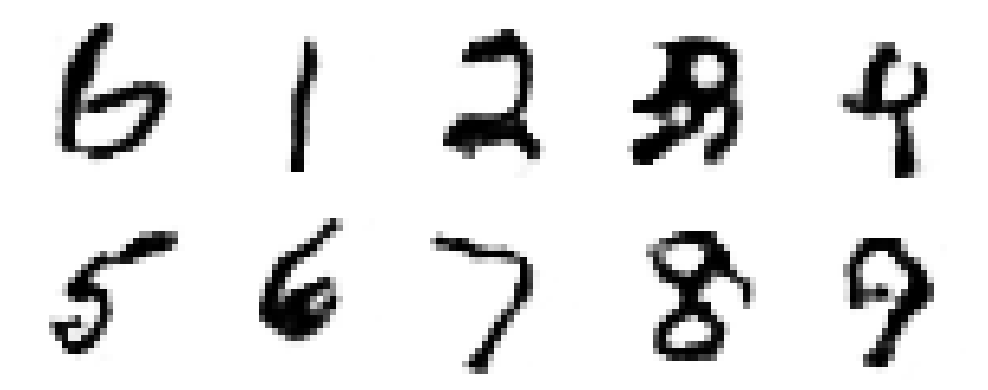

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 3.5235e-04 - loss: 0.5165 - gen_loss: 0.2746 - real_loss: 0.2419
Epoch 45/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9996 - acc_gen: 5.0686e-04 - loss: 0.5280 - gen_loss: 0.2924 - real_loss: 0.2355

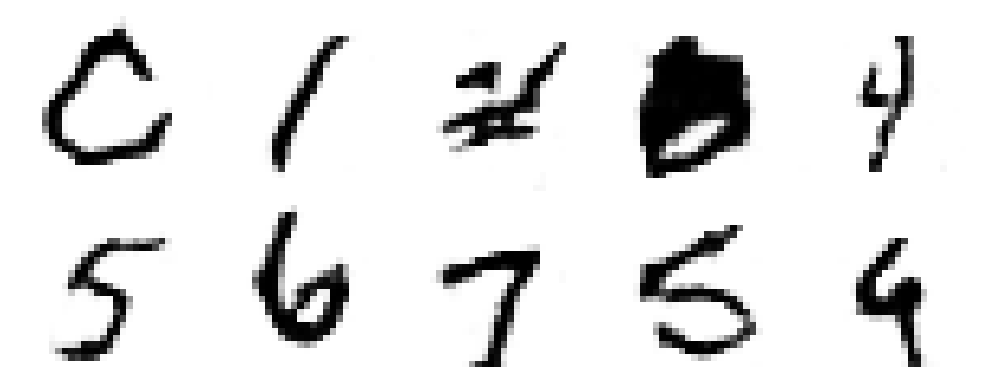

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9996 - acc_gen: 5.0672e-04 - loss: 0.5280 - gen_loss: 0.2924 - real_loss: 0.2355
Epoch 46/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 8.6978e-04 - loss: 0.5357 - gen_loss: 0.3047 - real_loss: 0.2309

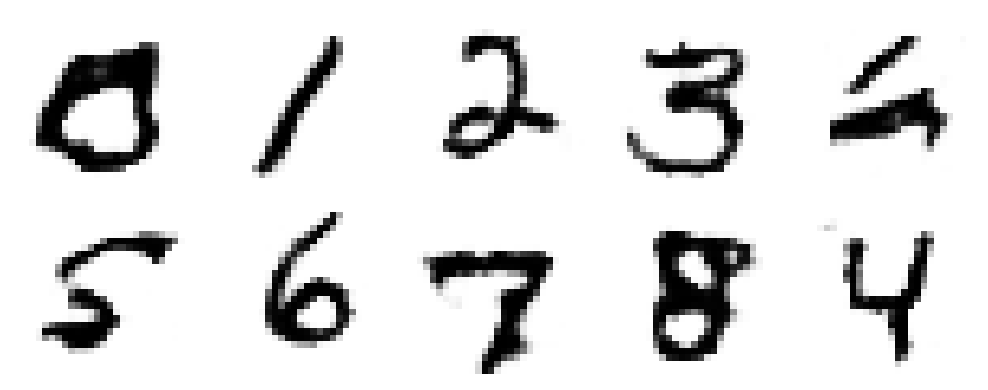

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9997 - acc_gen: 8.7010e-04 - loss: 0.5357 - gen_loss: 0.3047 - real_loss: 0.2310
Epoch 47/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 2.5393e-04 - loss: 0.5257 - gen_loss: 0.2880 - real_loss: 0.2377

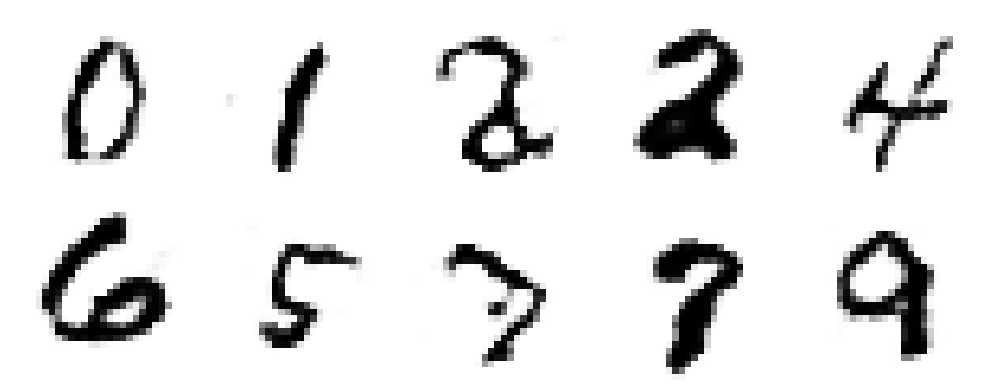

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9998 - acc_gen: 2.5386e-04 - loss: 0.5258 - gen_loss: 0.2881 - real_loss: 0.2377
Epoch 48/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0014 - loss: 0.5277 - gen_loss: 0.2909 - real_loss: 0.2368

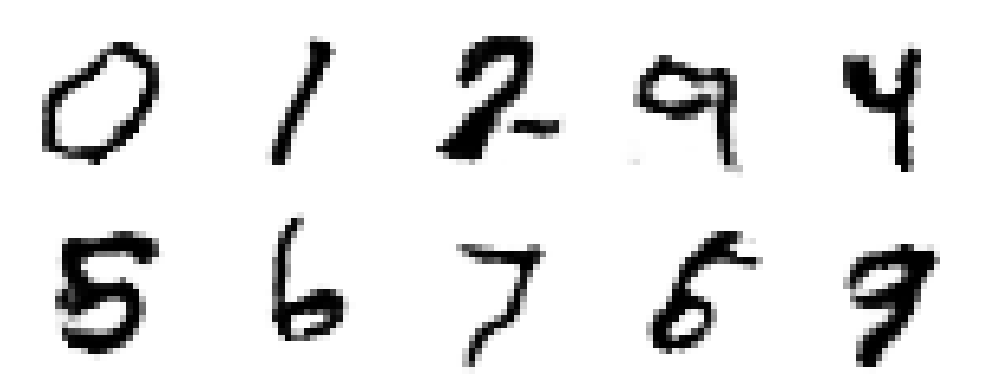

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9998 - acc_gen: 0.0014 - loss: 0.5277 - gen_loss: 0.2909 - real_loss: 0.2368
Epoch 49/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 1.0708e-04 - loss: 0.5238 - gen_loss: 0.2848 - real_loss: 0.2390

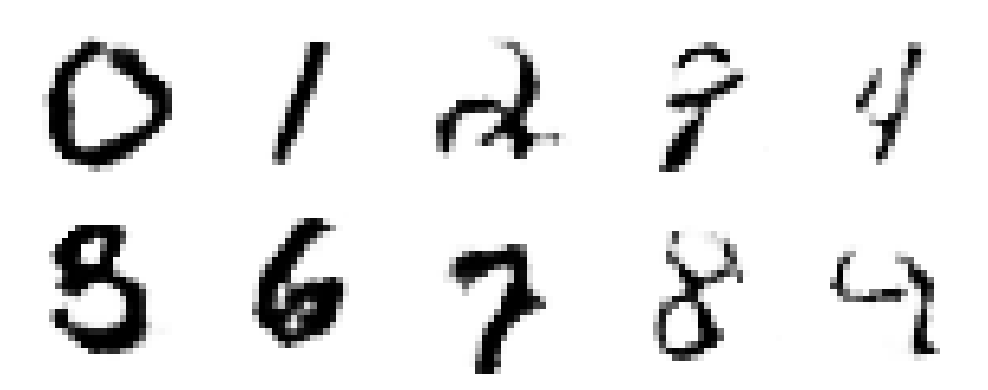

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 1.0727e-04 - loss: 0.5238 - gen_loss: 0.2848 - real_loss: 0.2390
Epoch 50/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 4.6777e-04 - loss: 0.5233 - gen_loss: 0.2857 - real_loss: 0.2376

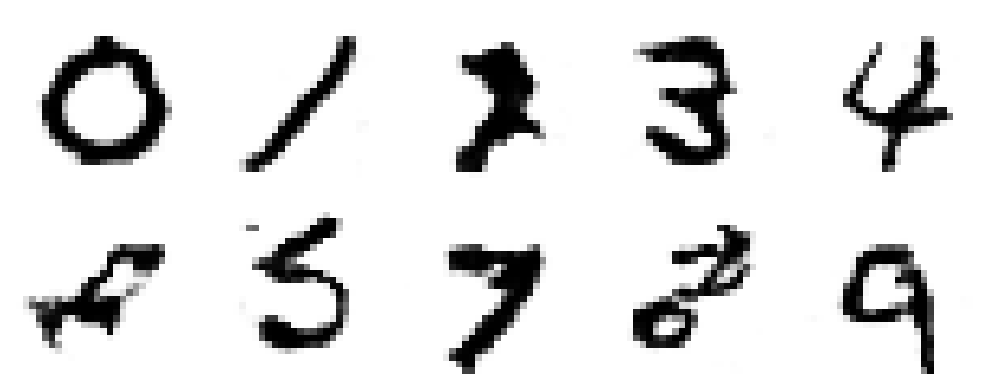

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 4.6794e-04 - loss: 0.5233 - gen_loss: 0.2857 - real_loss: 0.2376
Epoch 51/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 6.6567e-04 - loss: 0.5216 - gen_loss: 0.2812 - real_loss: 0.2404

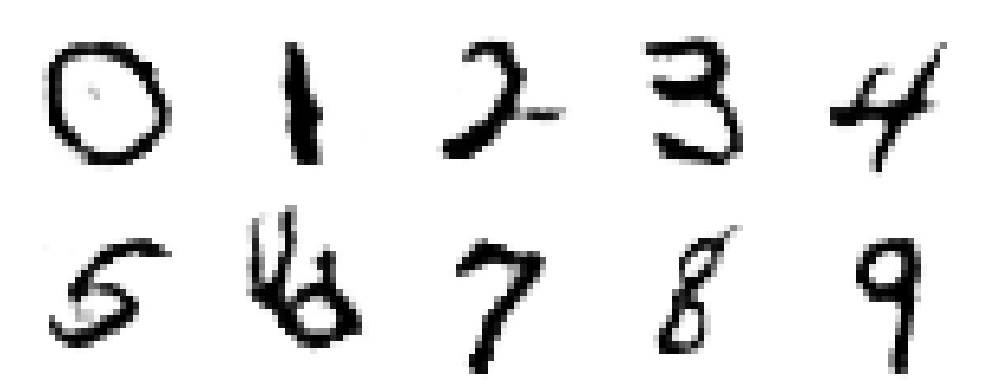

1000/1000 [==============================] - 57s 57ms/step - acc_disc: 1.0000 - acc_gen: 6.6563e-04 - loss: 0.5216 - gen_loss: 0.2812 - real_loss: 0.2404
Epoch 52/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 9.9156e-05 - loss: 0.5195 - gen_loss: 0.2798 - real_loss: 0.2397

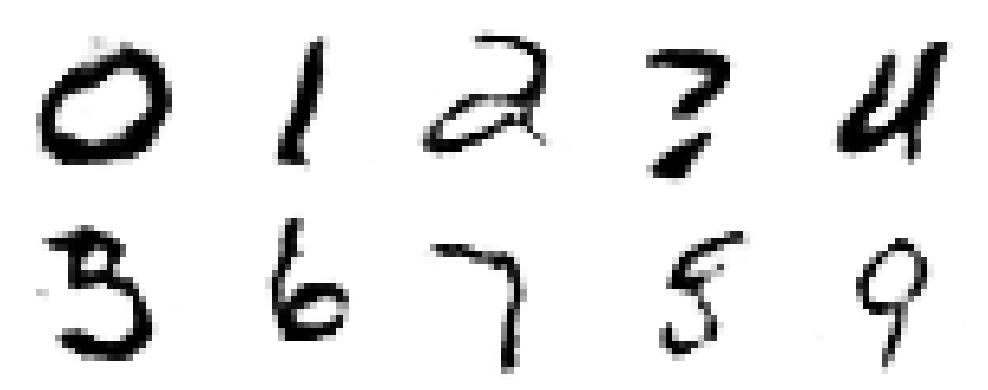

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 9.9390e-05 - loss: 0.5195 - gen_loss: 0.2798 - real_loss: 0.2397
Epoch 53/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9995 - acc_gen: 0.0026 - loss: 0.5465 - gen_loss: 0.3232 - real_loss: 0.2233

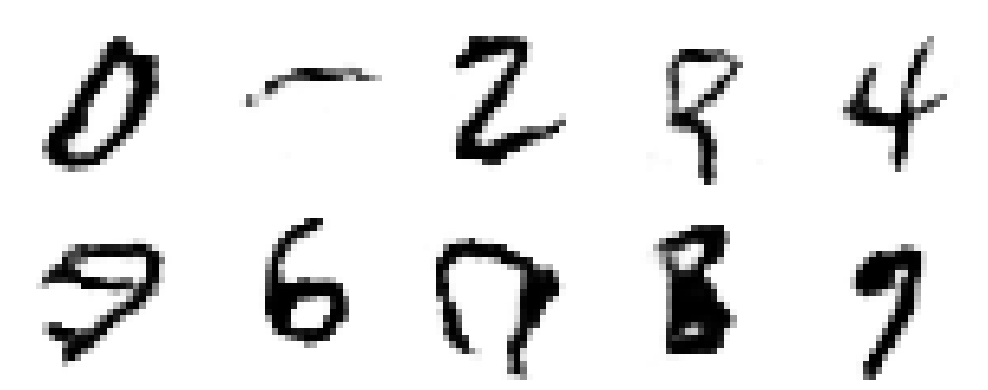

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9995 - acc_gen: 0.0026 - loss: 0.5465 - gen_loss: 0.3232 - real_loss: 0.2233
Epoch 54/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9995 - acc_gen: 0.0027 - loss: 0.5471 - gen_loss: 0.3211 - real_loss: 0.2260

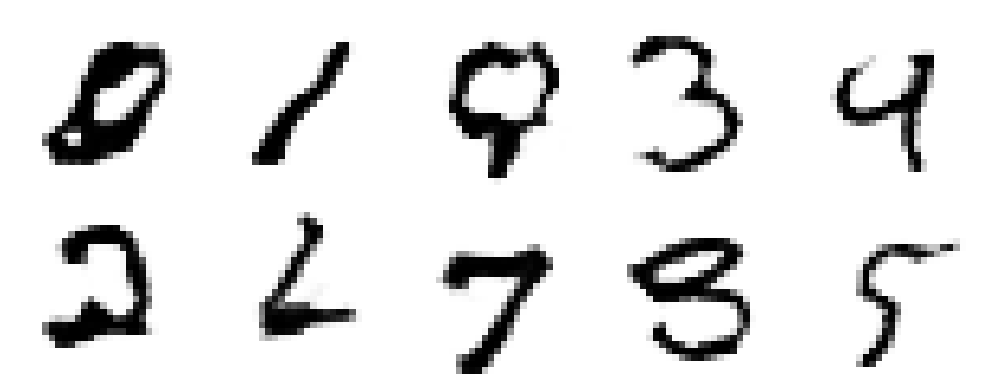

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9995 - acc_gen: 0.0027 - loss: 0.5471 - gen_loss: 0.3211 - real_loss: 0.2259
Epoch 55/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9996 - acc_gen: 6.3206e-04 - loss: 0.5267 - gen_loss: 0.2880 - real_loss: 0.2387

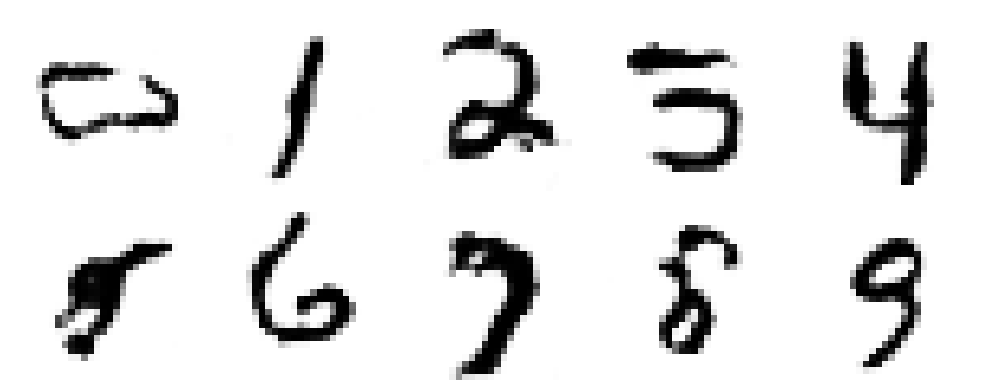

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9996 - acc_gen: 6.3149e-04 - loss: 0.5267 - gen_loss: 0.2880 - real_loss: 0.2387
Epoch 56/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 1.4875e-04 - loss: 0.5242 - gen_loss: 0.2869 - real_loss: 0.2373

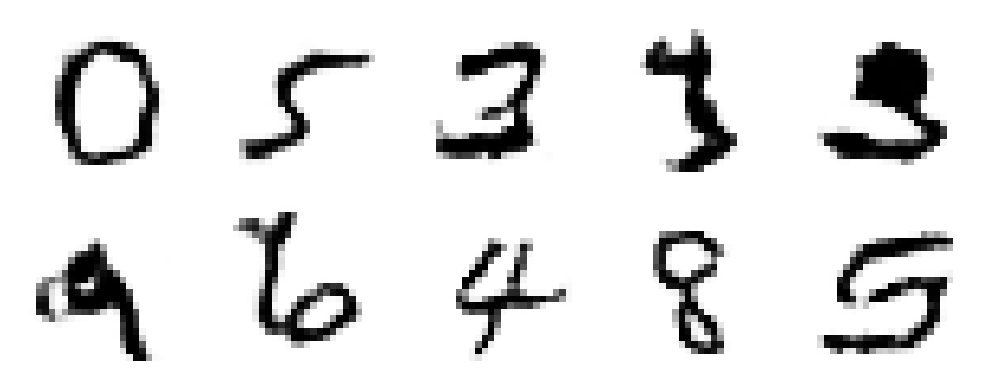

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 1.4875e-04 - loss: 0.5242 - gen_loss: 0.2869 - real_loss: 0.2373
Epoch 57/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 4.9994e-04 - loss: 0.5209 - gen_loss: 0.2793 - real_loss: 0.2416

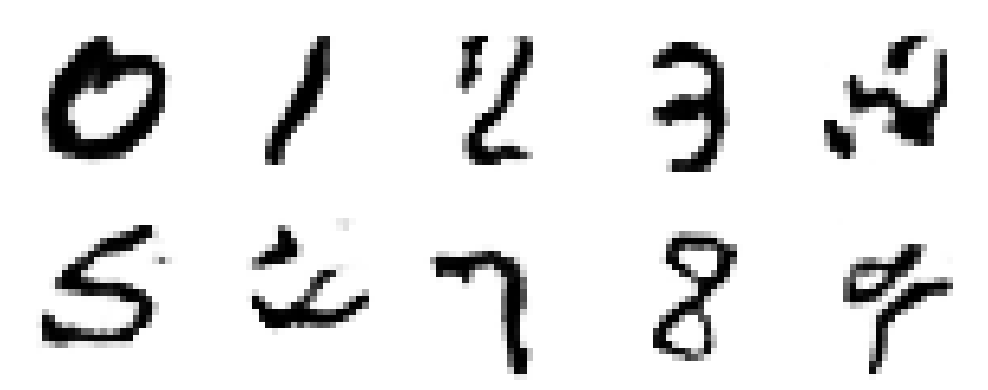

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 4.9931e-04 - loss: 0.5209 - gen_loss: 0.2793 - real_loss: 0.2416
Epoch 58/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 3.6874e-06 - loss: 0.5150 - gen_loss: 0.2750 - real_loss: 0.2400

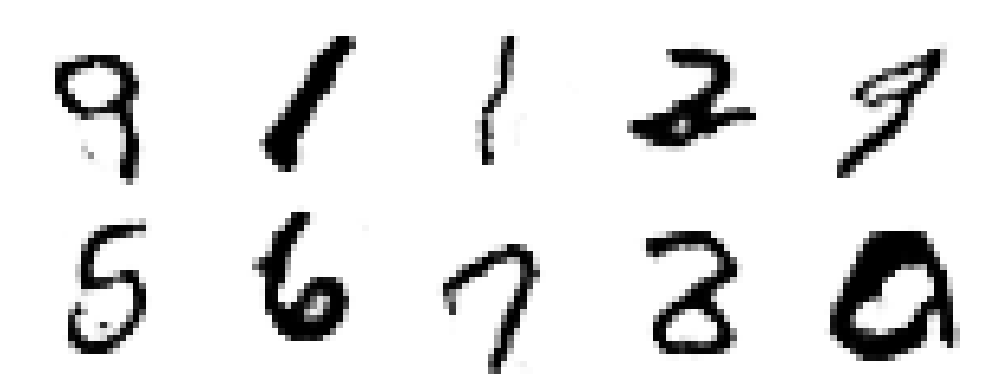

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 3.7670e-06 - loss: 0.5150 - gen_loss: 0.2750 - real_loss: 0.2400
Epoch 59/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 0.0014 - loss: 0.5263 - gen_loss: 0.2890 - real_loss: 0.2372

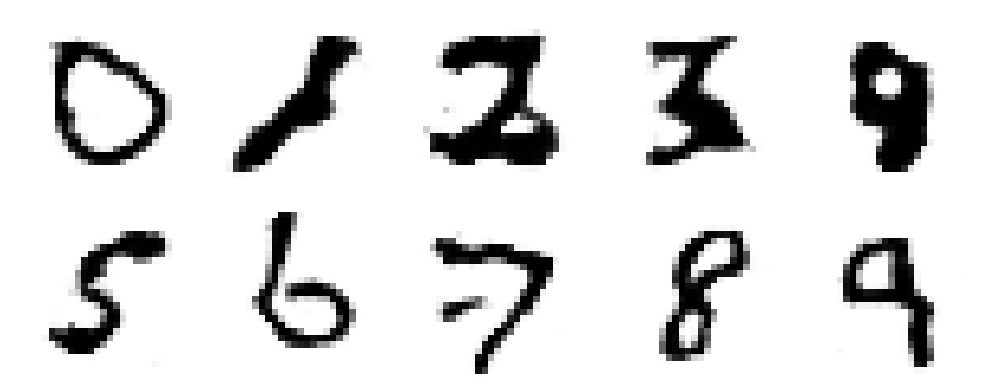

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 0.0014 - loss: 0.5262 - gen_loss: 0.2890 - real_loss: 0.2373
Epoch 60/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 6.4040e-05 - loss: 0.5228 - gen_loss: 0.2831 - real_loss: 0.2397

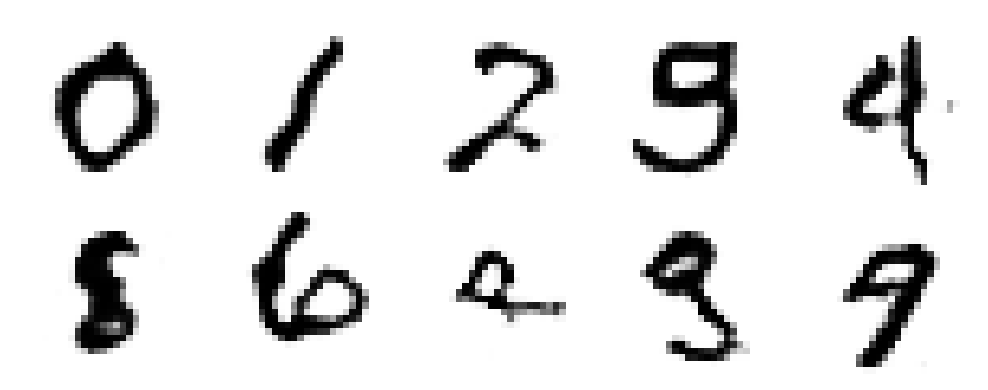

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 6.4078e-05 - loss: 0.5229 - gen_loss: 0.2832 - real_loss: 0.2397
Epoch 61/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 4.1187e-04 - loss: 0.5358 - gen_loss: 0.3060 - real_loss: 0.2298

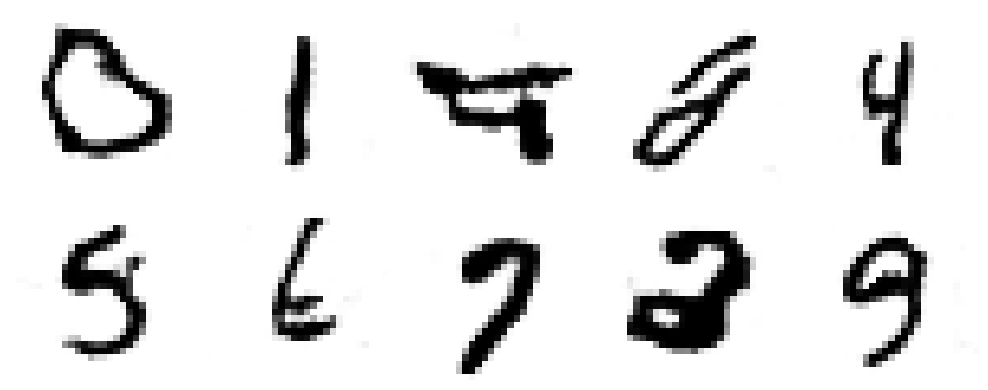

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 4.1222e-04 - loss: 0.5358 - gen_loss: 0.3060 - real_loss: 0.2298
Epoch 62/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9996 - acc_gen: 0.0031 - loss: 0.5338 - gen_loss: 0.3005 - real_loss: 0.2333

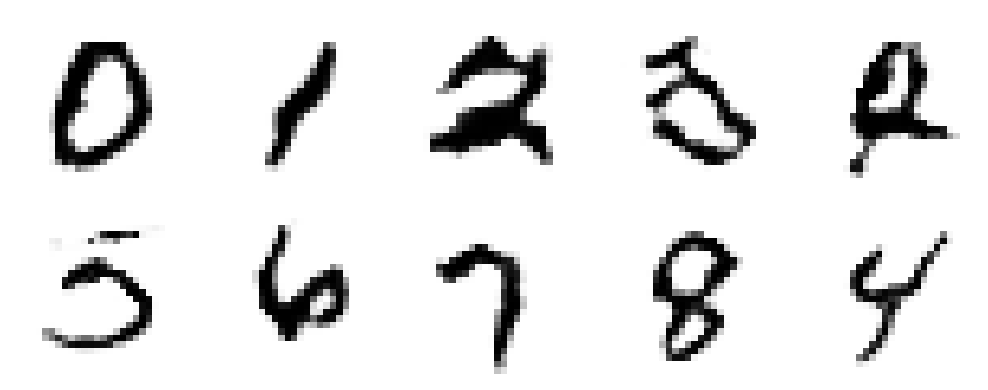

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9996 - acc_gen: 0.0031 - loss: 0.5338 - gen_loss: 0.3005 - real_loss: 0.2333
Epoch 63/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 0.0016 - loss: 0.5338 - gen_loss: 0.3015 - real_loss: 0.2322

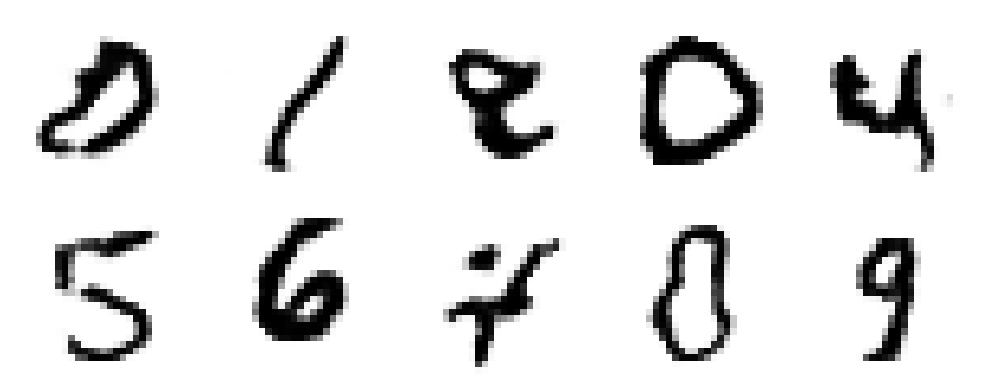

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9997 - acc_gen: 0.0016 - loss: 0.5337 - gen_loss: 0.3015 - real_loss: 0.2322
Epoch 64/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0012 - loss: 0.5442 - gen_loss: 0.3190 - real_loss: 0.2252

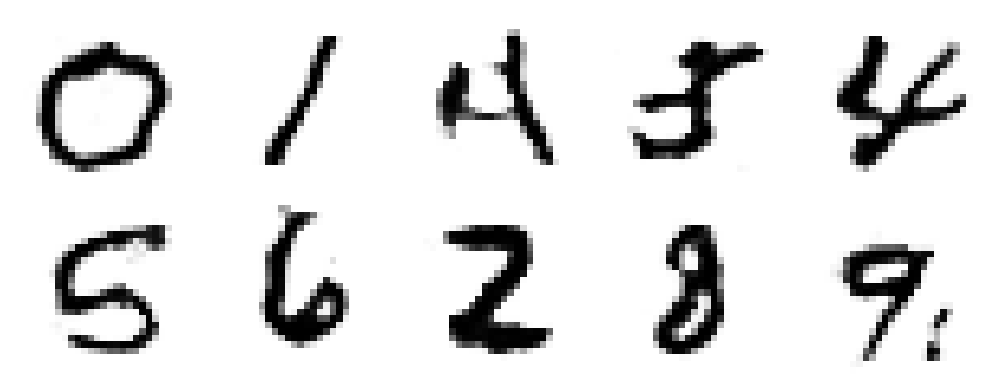

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 0.0012 - loss: 0.5443 - gen_loss: 0.3191 - real_loss: 0.2251
Epoch 65/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9996 - acc_gen: 0.0036 - loss: 0.5292 - gen_loss: 0.2929 - real_loss: 0.2363

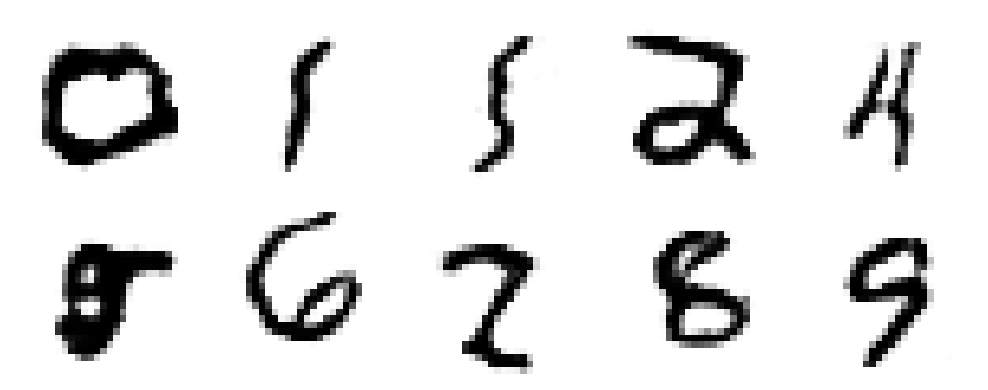

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9996 - acc_gen: 0.0036 - loss: 0.5292 - gen_loss: 0.2929 - real_loss: 0.2363
Epoch 66/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0013 - loss: 0.5347 - gen_loss: 0.3028 - real_loss: 0.2319

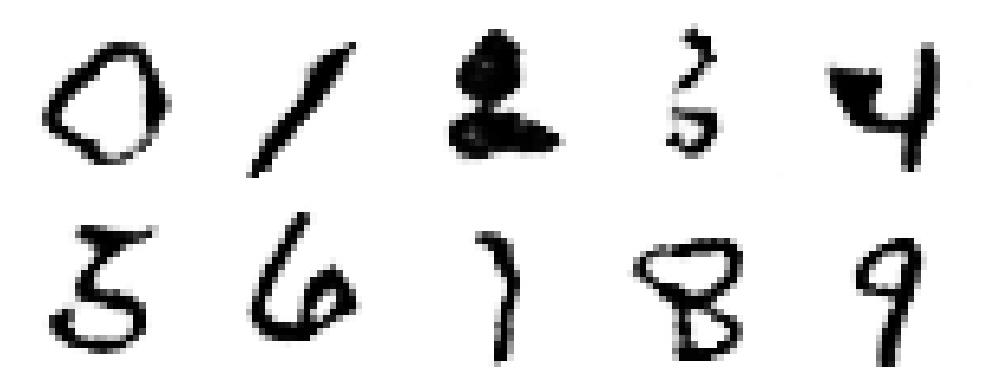

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 0.0013 - loss: 0.5346 - gen_loss: 0.3028 - real_loss: 0.2319
Epoch 67/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 1.4082e-05 - loss: 0.5164 - gen_loss: 0.2734 - real_loss: 0.2430

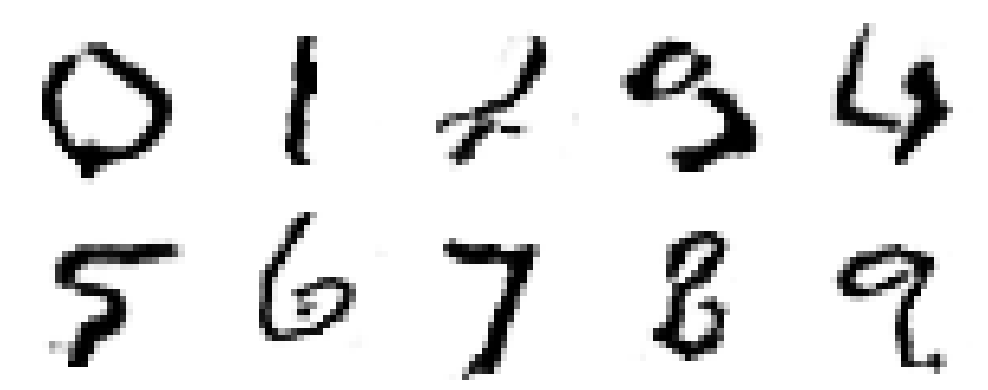

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 1.4353e-05 - loss: 0.5164 - gen_loss: 0.2734 - real_loss: 0.2431
Epoch 68/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 1.0636e-04 - loss: 0.5201 - gen_loss: 0.2809 - real_loss: 0.2392

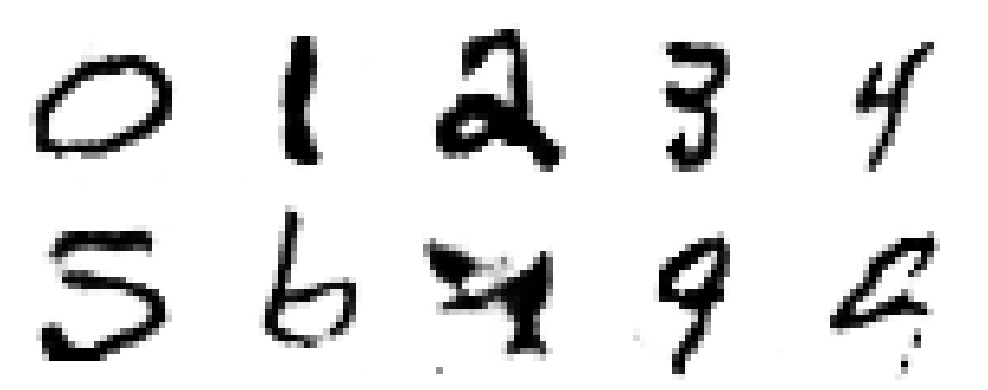

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 1.0725e-04 - loss: 0.5201 - gen_loss: 0.2808 - real_loss: 0.2392
Epoch 69/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 6.5994e-04 - loss: 0.5304 - gen_loss: 0.2965 - real_loss: 0.2339

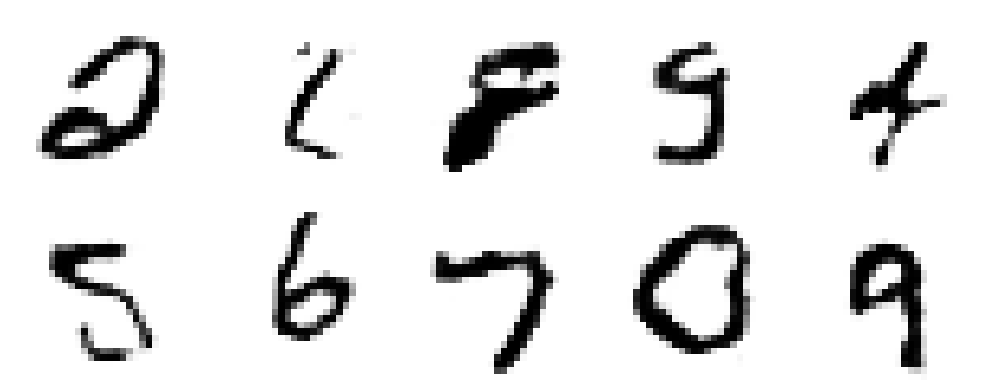

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 6.6010e-04 - loss: 0.5304 - gen_loss: 0.2965 - real_loss: 0.2339
Epoch 70/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 8.7634e-04 - loss: 0.5379 - gen_loss: 0.3057 - real_loss: 0.2322

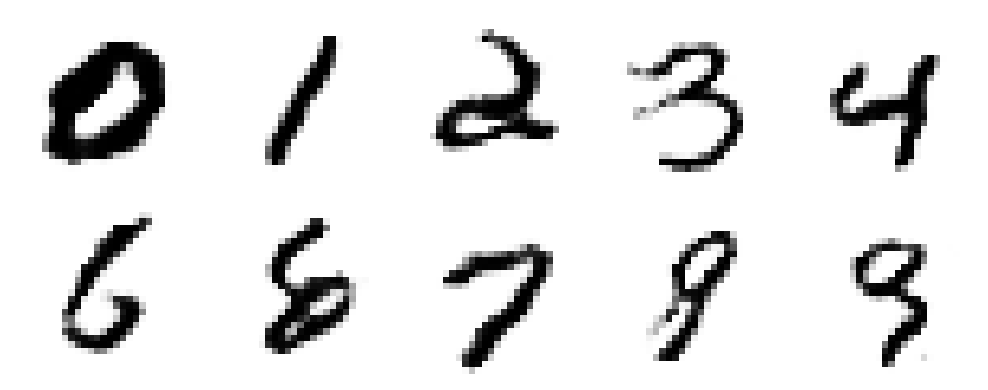

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 8.7676e-04 - loss: 0.5378 - gen_loss: 0.3056 - real_loss: 0.2322
Epoch 71/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 1.8456e-04 - loss: 0.5271 - gen_loss: 0.2914 - real_loss: 0.2358

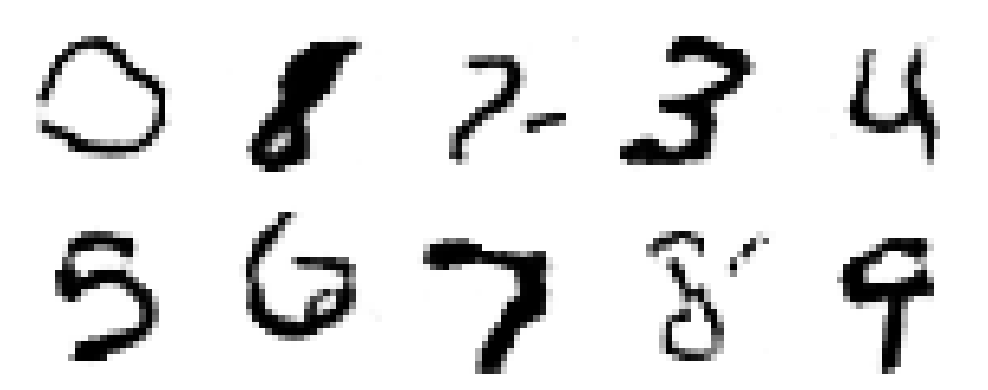

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 1.8478e-04 - loss: 0.5271 - gen_loss: 0.2914 - real_loss: 0.2357
Epoch 72/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 3.4191e-04 - loss: 0.5201 - gen_loss: 0.2789 - real_loss: 0.2413

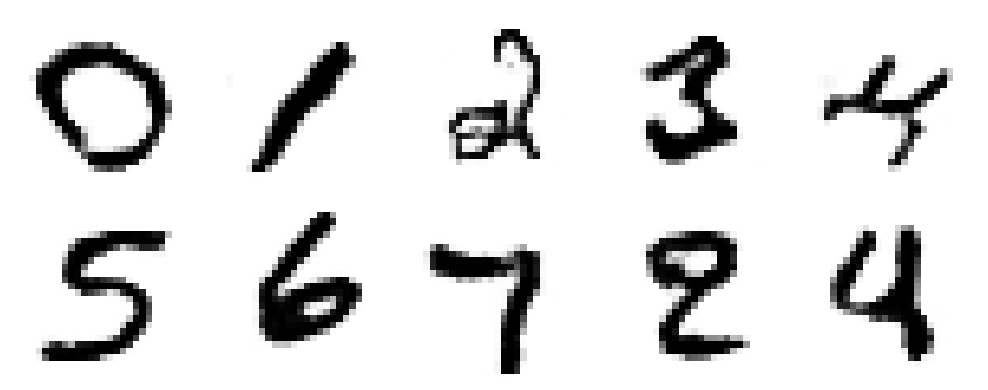

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 3.4256e-04 - loss: 0.5202 - gen_loss: 0.2789 - real_loss: 0.2413
Epoch 73/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 0.0021 - loss: 0.5469 - gen_loss: 0.3216 - real_loss: 0.2253

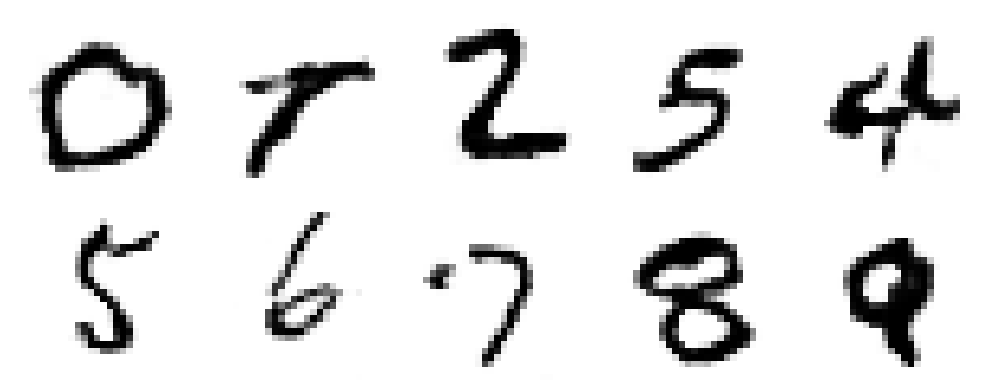

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9997 - acc_gen: 0.0021 - loss: 0.5468 - gen_loss: 0.3214 - real_loss: 0.2254
Epoch 74/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 0.0015 - loss: 0.5468 - gen_loss: 0.3218 - real_loss: 0.2249

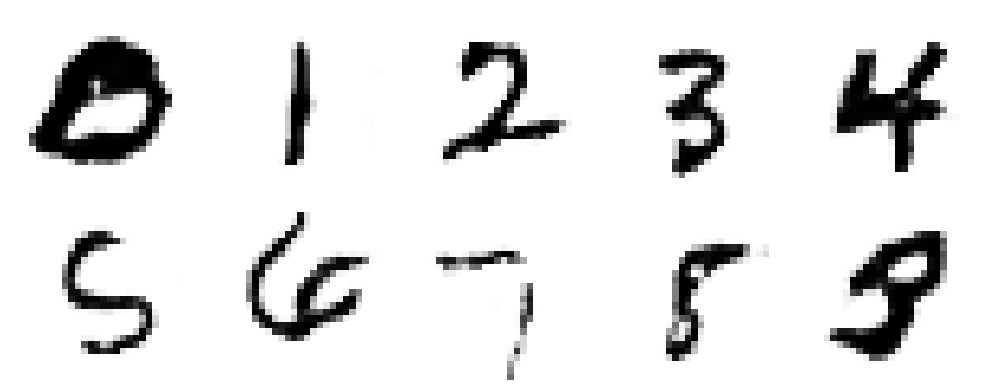

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 0.0015 - loss: 0.5467 - gen_loss: 0.3218 - real_loss: 0.2249
Epoch 75/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9996 - acc_gen: 0.0067 - loss: 0.5725 - gen_loss: 0.3616 - real_loss: 0.2109

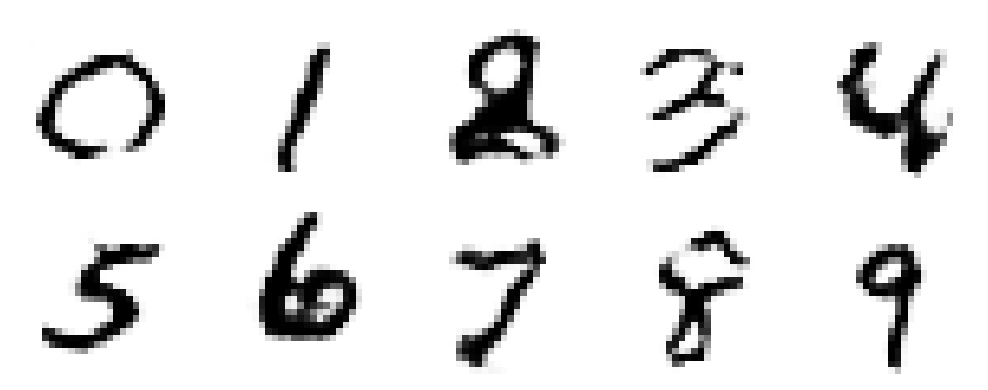

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9996 - acc_gen: 0.0067 - loss: 0.5725 - gen_loss: 0.3616 - real_loss: 0.2109
Epoch 76/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 0.0012 - loss: 0.5375 - gen_loss: 0.3065 - real_loss: 0.2310

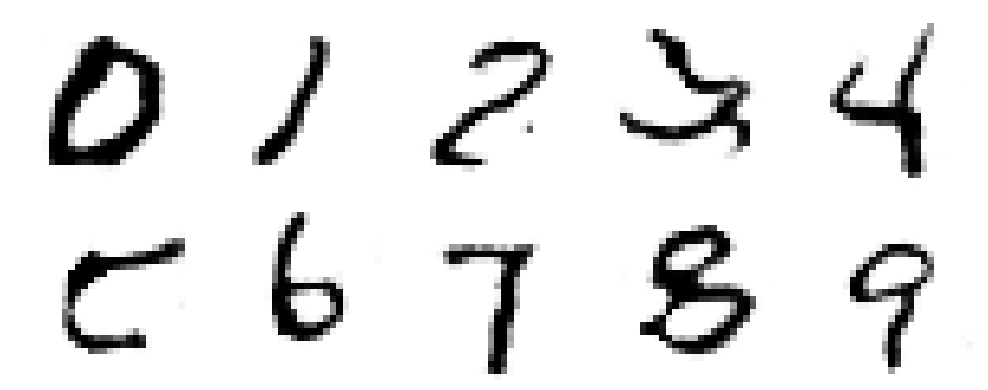

1000/1000 [==============================] - 57s 57ms/step - acc_disc: 0.9999 - acc_gen: 0.0012 - loss: 0.5375 - gen_loss: 0.3065 - real_loss: 0.2310
Epoch 77/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 0.0012 - loss: 0.5387 - gen_loss: 0.3099 - real_loss: 0.2289

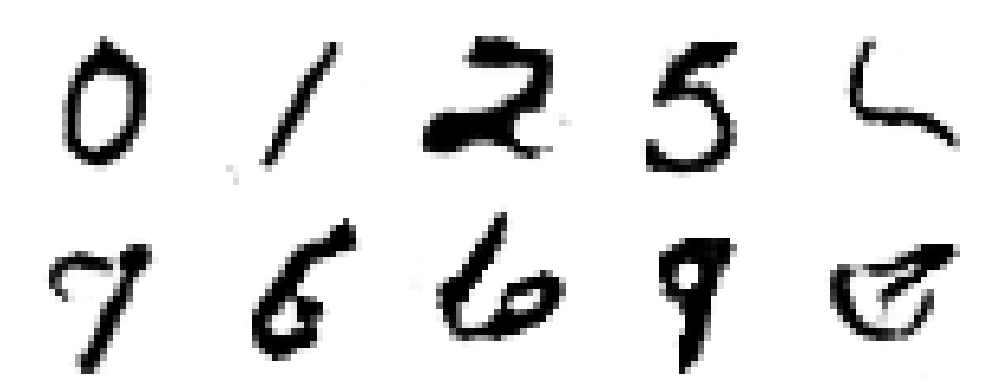

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 0.0012 - loss: 0.5389 - gen_loss: 0.3102 - real_loss: 0.2287
Epoch 78/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9991 - acc_gen: 0.0067 - loss: 0.5584 - gen_loss: 0.3377 - real_loss: 0.2208

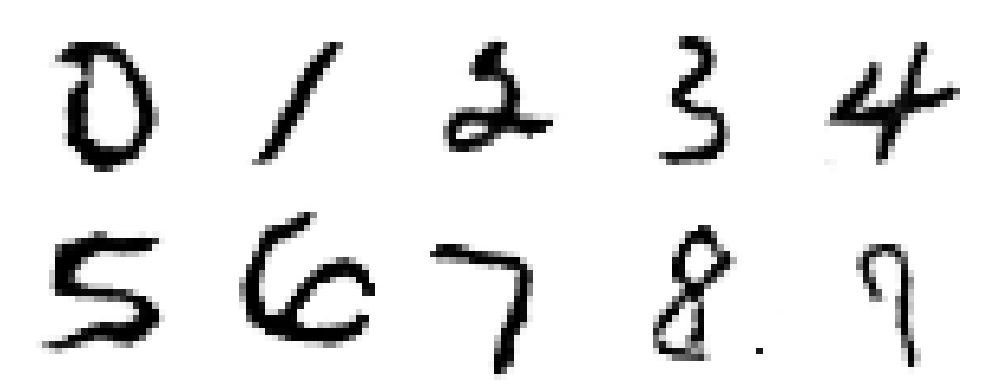

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9991 - acc_gen: 0.0067 - loss: 0.5583 - gen_loss: 0.3375 - real_loss: 0.2208
Epoch 79/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0015 - loss: 0.5235 - gen_loss: 0.2856 - real_loss: 0.2378

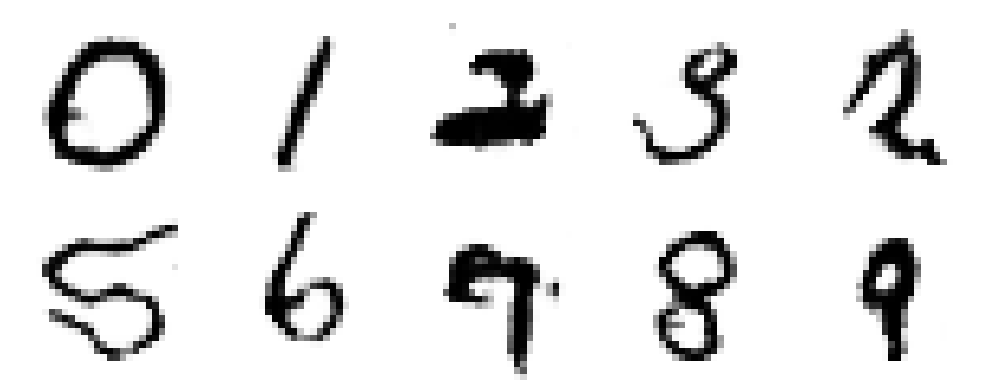

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0015 - loss: 0.5235 - gen_loss: 0.2857 - real_loss: 0.2378
Epoch 80/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9996 - acc_gen: 0.0016 - loss: 0.5367 - gen_loss: 0.3036 - real_loss: 0.2330

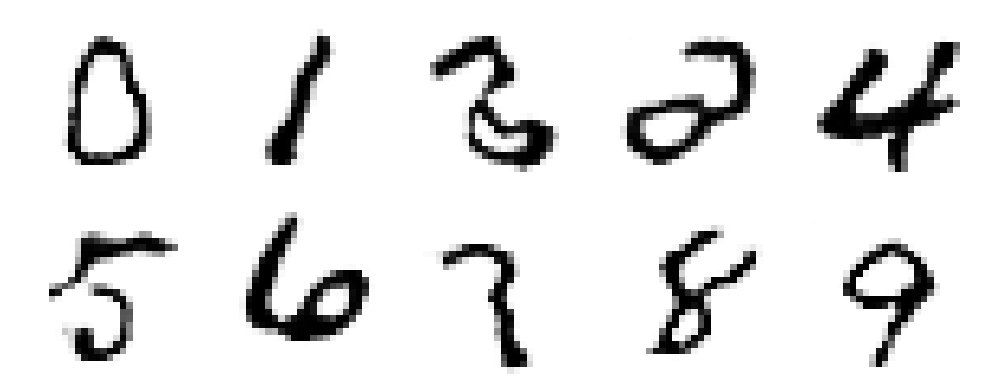

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9996 - acc_gen: 0.0016 - loss: 0.5367 - gen_loss: 0.3036 - real_loss: 0.2331
Epoch 81/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 8.6189e-04 - loss: 0.5286 - gen_loss: 0.2938 - real_loss: 0.2348

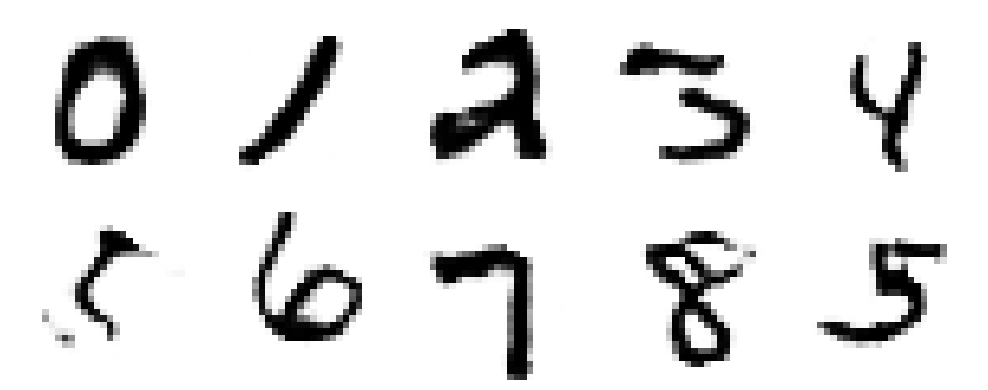

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 8.6208e-04 - loss: 0.5286 - gen_loss: 0.2938 - real_loss: 0.2348
Epoch 82/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 0.0048 - loss: 0.5379 - gen_loss: 0.3062 - real_loss: 0.2318

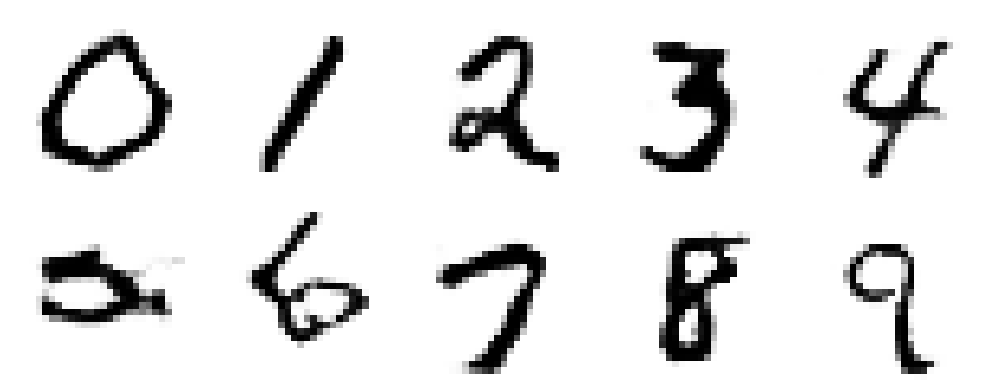

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9997 - acc_gen: 0.0048 - loss: 0.5379 - gen_loss: 0.3061 - real_loss: 0.2318
Epoch 83/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0023 - loss: 0.5429 - gen_loss: 0.3170 - real_loss: 0.2260

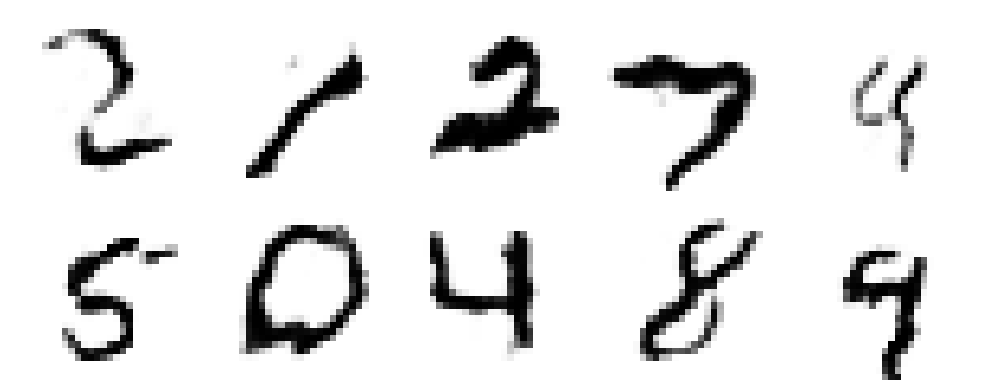

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 0.0023 - loss: 0.5430 - gen_loss: 0.3170 - real_loss: 0.2259
Epoch 84/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9994 - acc_gen: 0.0026 - loss: 0.5301 - gen_loss: 0.2929 - real_loss: 0.2372

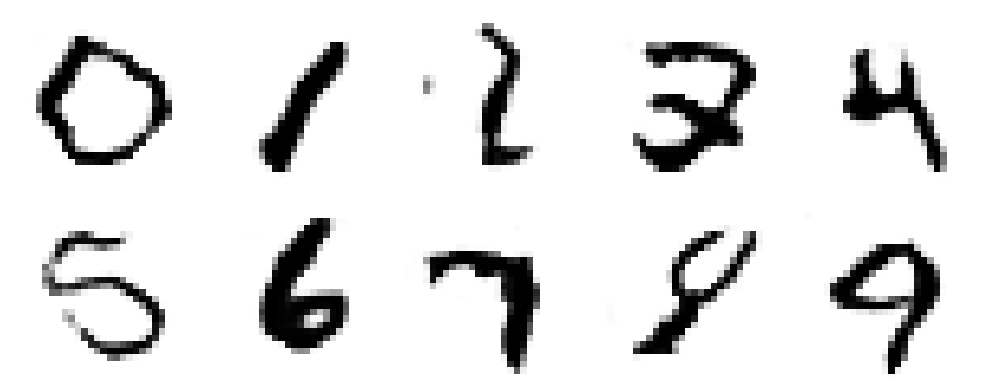

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9994 - acc_gen: 0.0026 - loss: 0.5300 - gen_loss: 0.2929 - real_loss: 0.2372
Epoch 85/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 3.6570e-04 - loss: 0.5332 - gen_loss: 0.3007 - real_loss: 0.2325

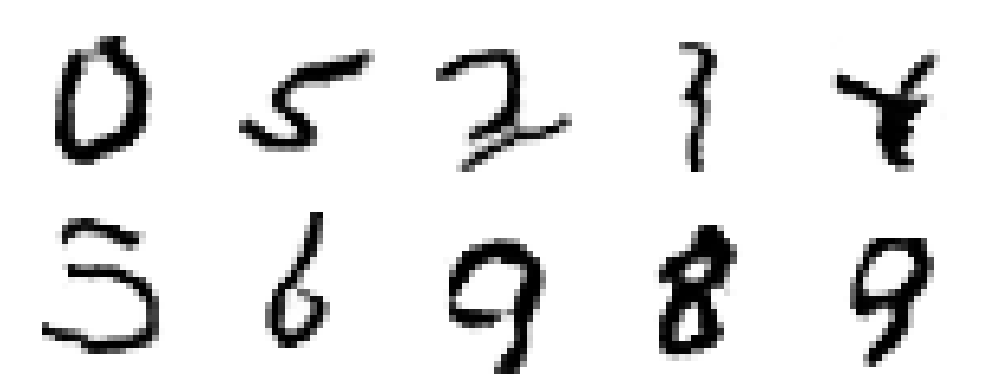

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 3.6597e-04 - loss: 0.5332 - gen_loss: 0.3007 - real_loss: 0.2325
Epoch 86/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0015 - loss: 0.5342 - gen_loss: 0.3008 - real_loss: 0.2334

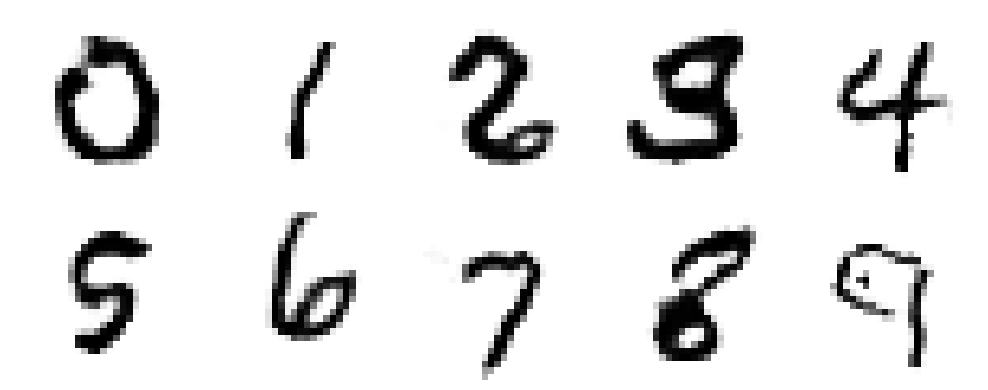

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 0.0015 - loss: 0.5342 - gen_loss: 0.3008 - real_loss: 0.2334
Epoch 87/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 8.0793e-04 - loss: 0.5438 - gen_loss: 0.3187 - real_loss: 0.2250

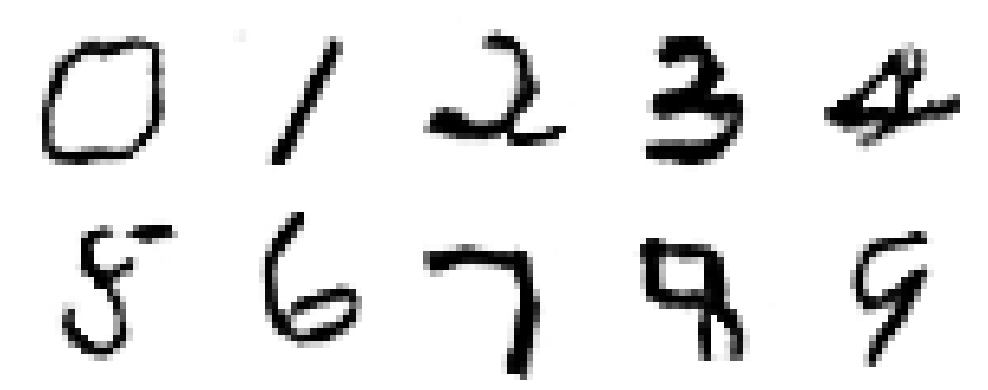

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9997 - acc_gen: 8.0964e-04 - loss: 0.5438 - gen_loss: 0.3187 - real_loss: 0.2251
Epoch 88/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9990 - acc_gen: 0.0085 - loss: 0.5659 - gen_loss: 0.3508 - real_loss: 0.2151

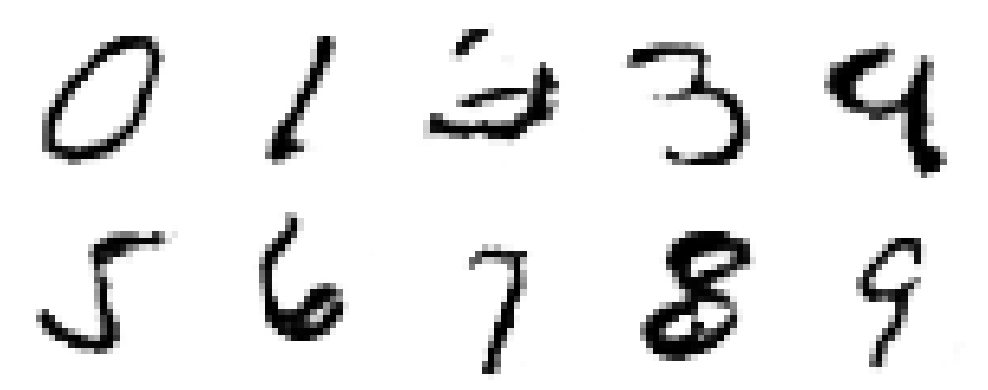

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9990 - acc_gen: 0.0085 - loss: 0.5659 - gen_loss: 0.3508 - real_loss: 0.2151
Epoch 89/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 0.0039 - loss: 0.5505 - gen_loss: 0.3264 - real_loss: 0.2242

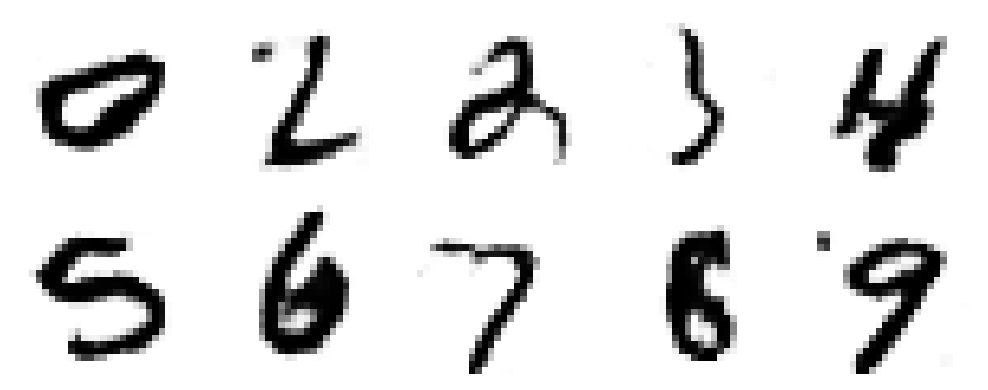

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9997 - acc_gen: 0.0039 - loss: 0.5505 - gen_loss: 0.3264 - real_loss: 0.2241
Epoch 90/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9993 - acc_gen: 0.0049 - loss: 0.5460 - gen_loss: 0.3180 - real_loss: 0.2280

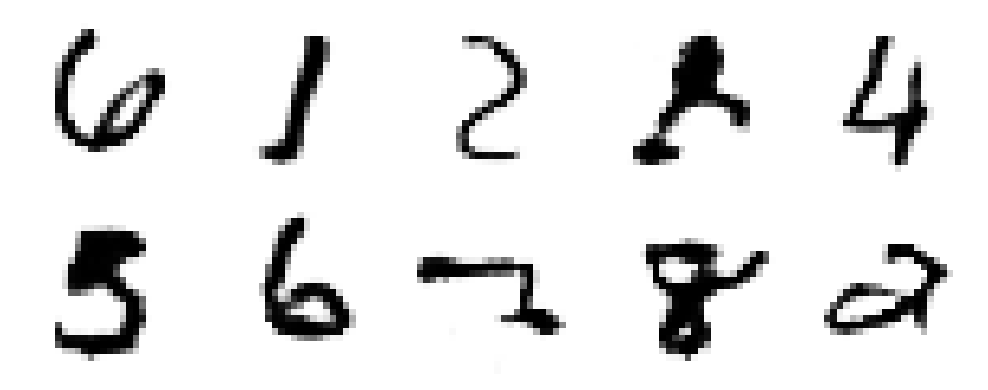

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9993 - acc_gen: 0.0049 - loss: 0.5459 - gen_loss: 0.3179 - real_loss: 0.2280
Epoch 91/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 8.7167e-04 - loss: 0.5231 - gen_loss: 0.2837 - real_loss: 0.2394

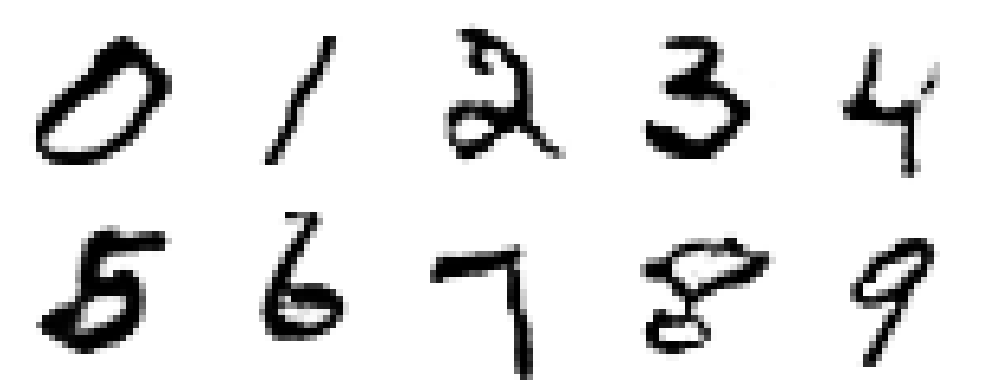

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 8.7120e-04 - loss: 0.5231 - gen_loss: 0.2837 - real_loss: 0.2394
Epoch 92/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 6.2399e-05 - loss: 0.5133 - gen_loss: 0.2692 - real_loss: 0.2441

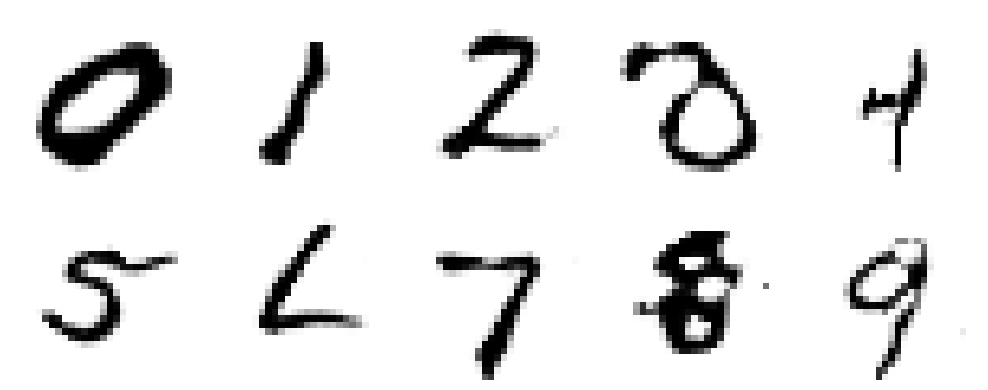

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 6.2636e-05 - loss: 0.5134 - gen_loss: 0.2693 - real_loss: 0.2441
Epoch 93/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 5.9066e-05 - loss: 0.5177 - gen_loss: 0.2764 - real_loss: 0.2413

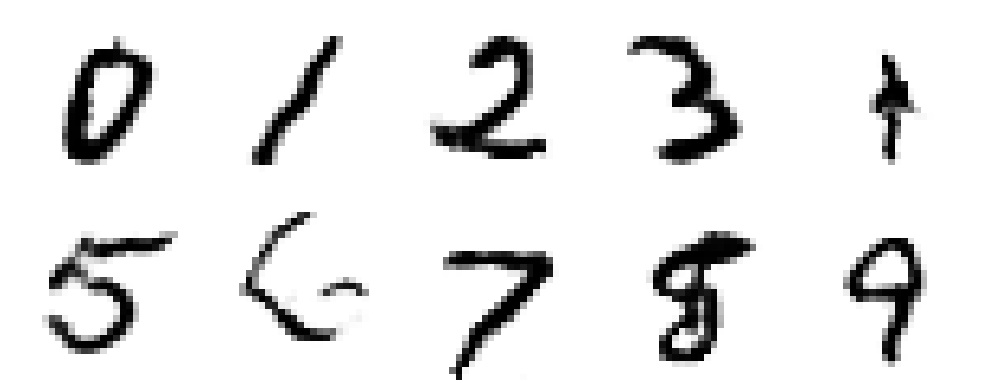

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 5.9041e-05 - loss: 0.5177 - gen_loss: 0.2764 - real_loss: 0.2413
Epoch 94/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 2.6678e-04 - loss: 0.5128 - gen_loss: 0.2678 - real_loss: 0.2450

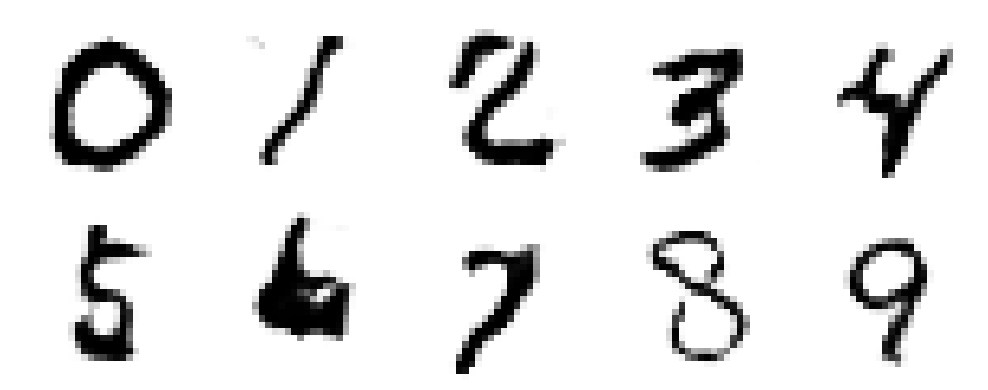

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 2.6665e-04 - loss: 0.5128 - gen_loss: 0.2678 - real_loss: 0.2450
Epoch 95/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 9.4202e-05 - loss: 0.5168 - gen_loss: 0.2744 - real_loss: 0.2424

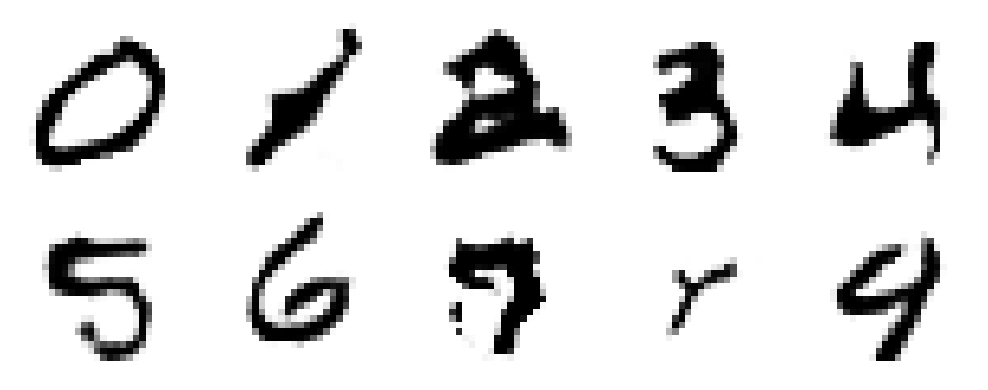

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 9.4125e-05 - loss: 0.5169 - gen_loss: 0.2744 - real_loss: 0.2424
Epoch 96/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 5.6987e-04 - loss: 0.5421 - gen_loss: 0.3149 - real_loss: 0.2272

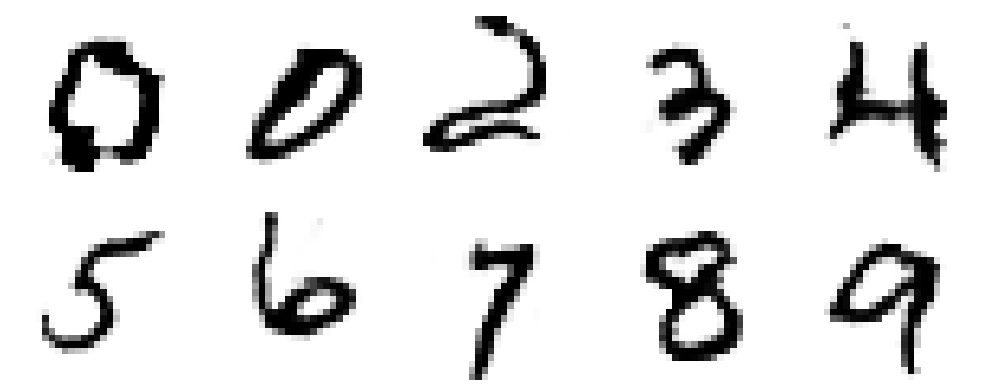

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 5.7109e-04 - loss: 0.5421 - gen_loss: 0.3149 - real_loss: 0.2272
Epoch 97/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 1.1131e-04 - loss: 0.5166 - gen_loss: 0.2722 - real_loss: 0.2444

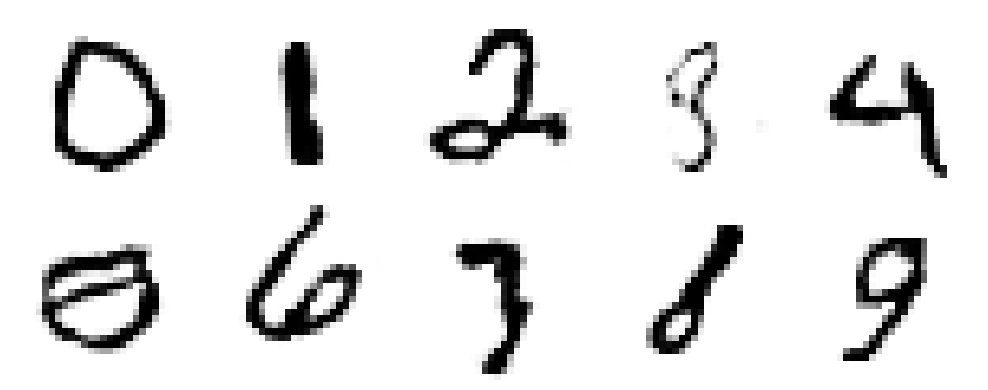

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 1.1125e-04 - loss: 0.5166 - gen_loss: 0.2722 - real_loss: 0.2444
Epoch 98/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 0.0014 - loss: 0.5258 - gen_loss: 0.2885 - real_loss: 0.2373

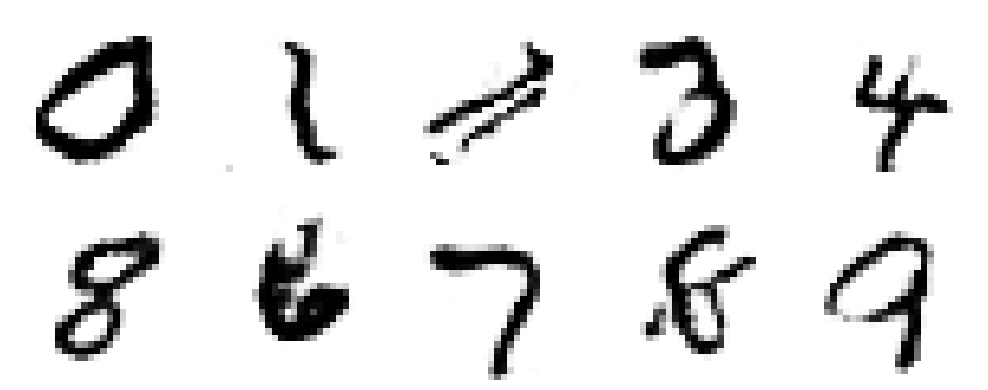

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 0.0014 - loss: 0.5258 - gen_loss: 0.2885 - real_loss: 0.2373
Epoch 99/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 8.0746e-05 - loss: 0.5184 - gen_loss: 0.2766 - real_loss: 0.2417

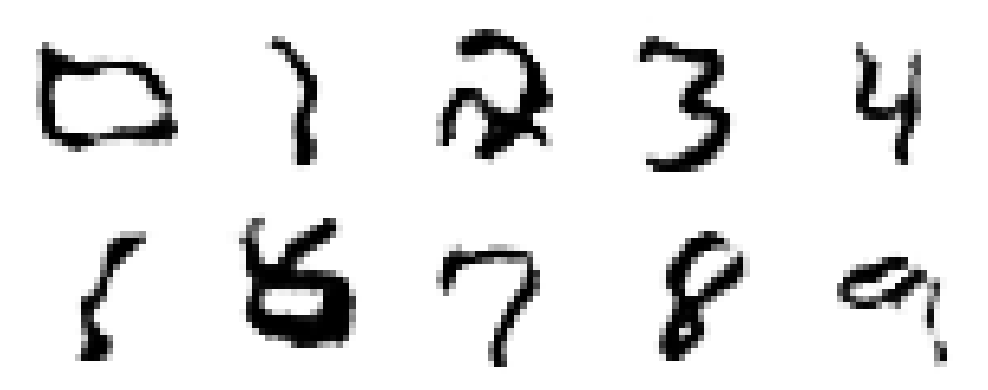

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 8.1018e-05 - loss: 0.5184 - gen_loss: 0.2766 - real_loss: 0.2417
Epoch 100/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 3.5191e-04 - loss: 0.5352 - gen_loss: 0.3045 - real_loss: 0.2307

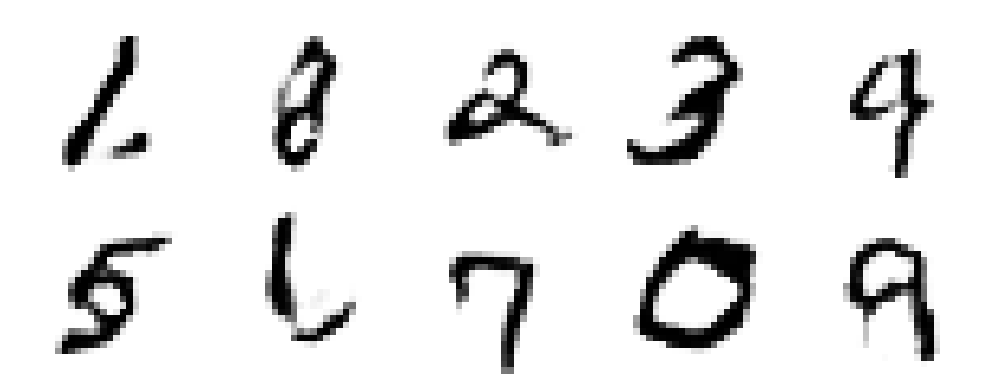

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 3.5313e-04 - loss: 0.5351 - gen_loss: 0.3045 - real_loss: 0.2307
Epoch 101/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9995 - acc_gen: 0.0042 - loss: 0.5382 - gen_loss: 0.3054 - real_loss: 0.2328

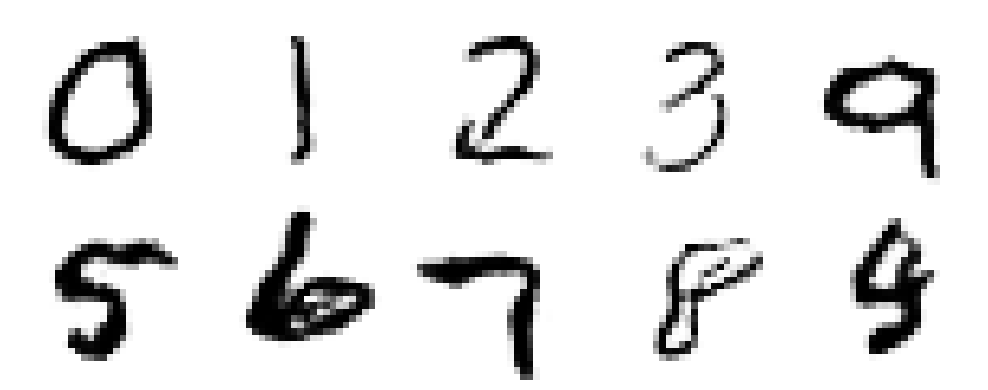

1000/1000 [==============================] - 57s 57ms/step - acc_disc: 0.9995 - acc_gen: 0.0042 - loss: 0.5381 - gen_loss: 0.3053 - real_loss: 0.2328
Epoch 102/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 2.2696e-04 - loss: 0.5232 - gen_loss: 0.2851 - real_loss: 0.2381

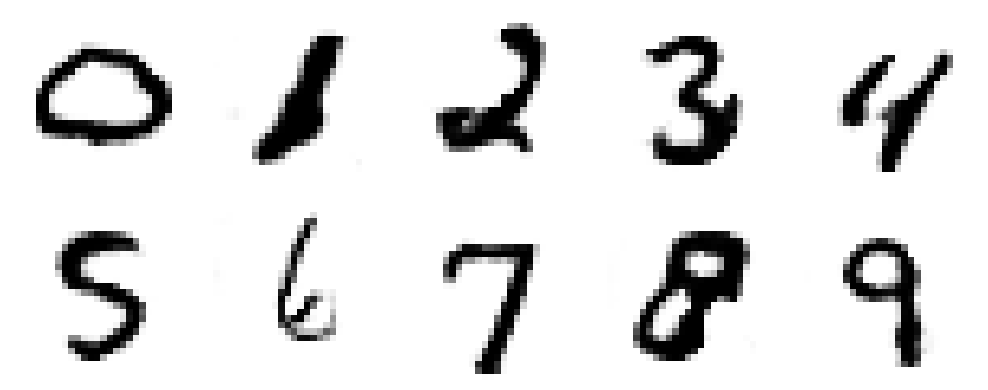

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 2.2706e-04 - loss: 0.5233 - gen_loss: 0.2852 - real_loss: 0.2381
Epoch 103/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 3.5894e-04 - loss: 0.5214 - gen_loss: 0.2796 - real_loss: 0.2418

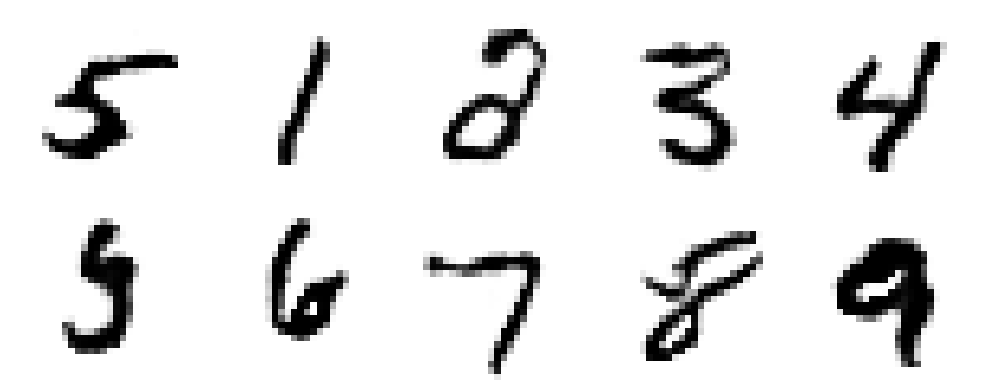

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 3.5910e-04 - loss: 0.5214 - gen_loss: 0.2796 - real_loss: 0.2418
Epoch 104/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 5.8152e-05 - loss: 0.5143 - gen_loss: 0.2703 - real_loss: 0.2441

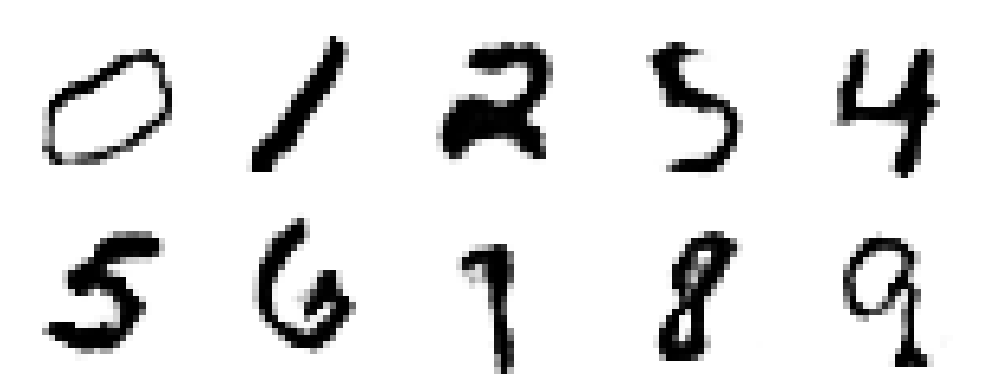

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 5.8144e-05 - loss: 0.5143 - gen_loss: 0.2702 - real_loss: 0.2441
Epoch 105/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 2.7550e-04 - loss: 0.5243 - gen_loss: 0.2860 - real_loss: 0.2382

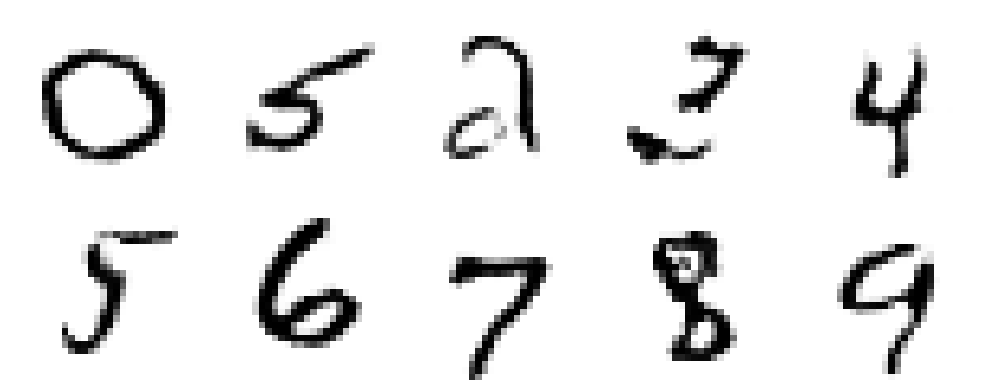

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 2.7563e-04 - loss: 0.5243 - gen_loss: 0.2860 - real_loss: 0.2382
Epoch 106/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 2.1463e-04 - loss: 0.5162 - gen_loss: 0.2727 - real_loss: 0.2435

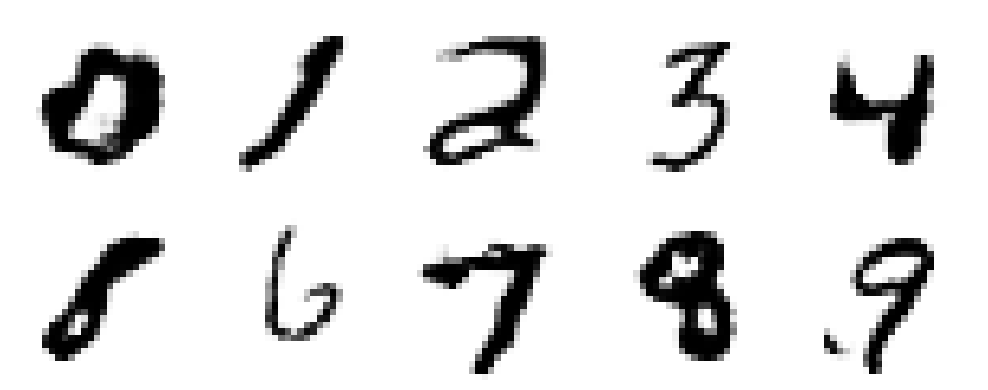

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 2.1496e-04 - loss: 0.5162 - gen_loss: 0.2727 - real_loss: 0.2435
Epoch 107/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0022 - loss: 0.5504 - gen_loss: 0.3284 - real_loss: 0.2220

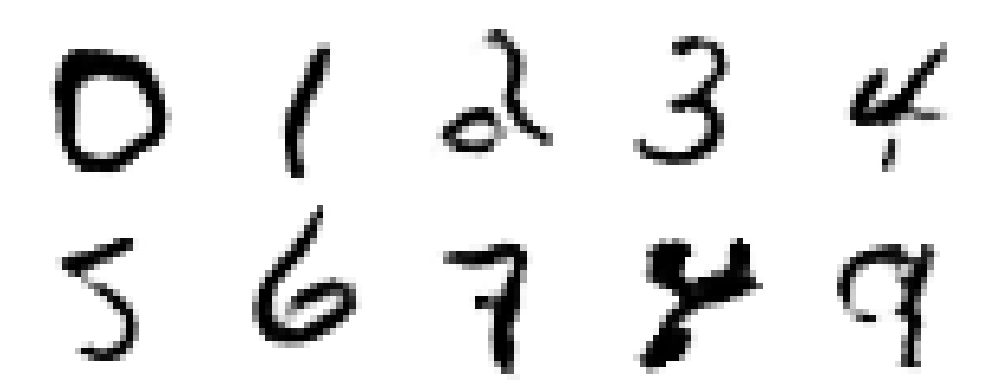

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 0.0022 - loss: 0.5504 - gen_loss: 0.3284 - real_loss: 0.2220
Epoch 108/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9994 - acc_gen: 0.0048 - loss: 0.5744 - gen_loss: 0.3658 - real_loss: 0.2085

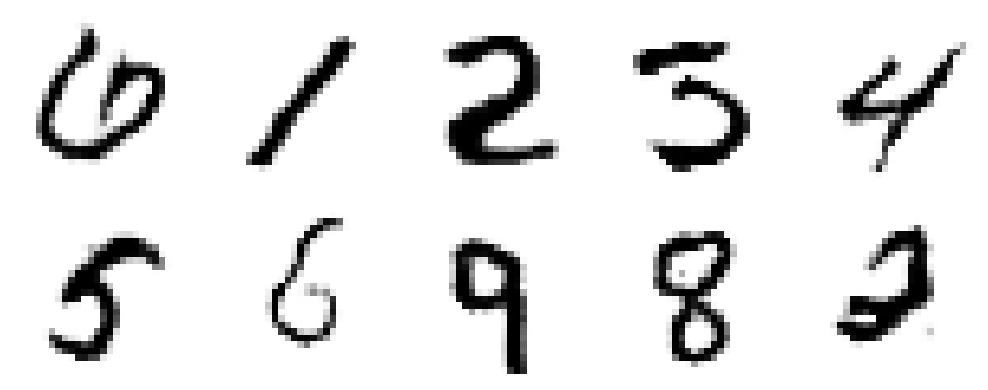

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9994 - acc_gen: 0.0048 - loss: 0.5744 - gen_loss: 0.3657 - real_loss: 0.2086
Epoch 109/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0022 - loss: 0.5376 - gen_loss: 0.3042 - real_loss: 0.2334

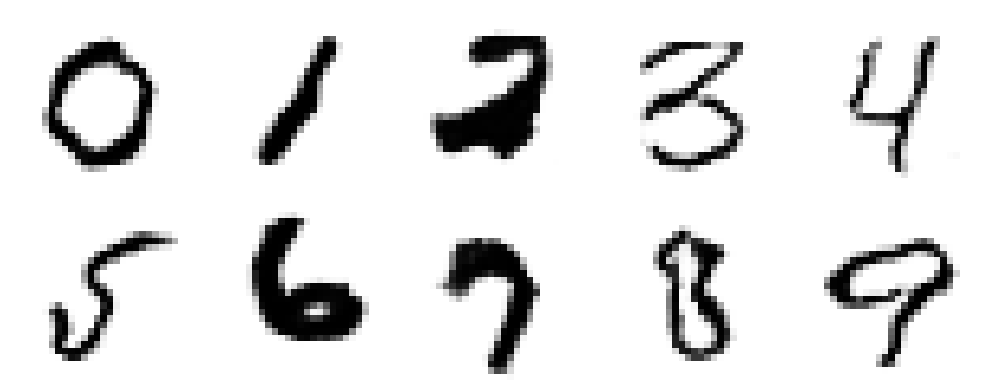

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 0.0022 - loss: 0.5375 - gen_loss: 0.3041 - real_loss: 0.2334
Epoch 110/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 2.1243e-04 - loss: 0.5321 - gen_loss: 0.2988 - real_loss: 0.2332

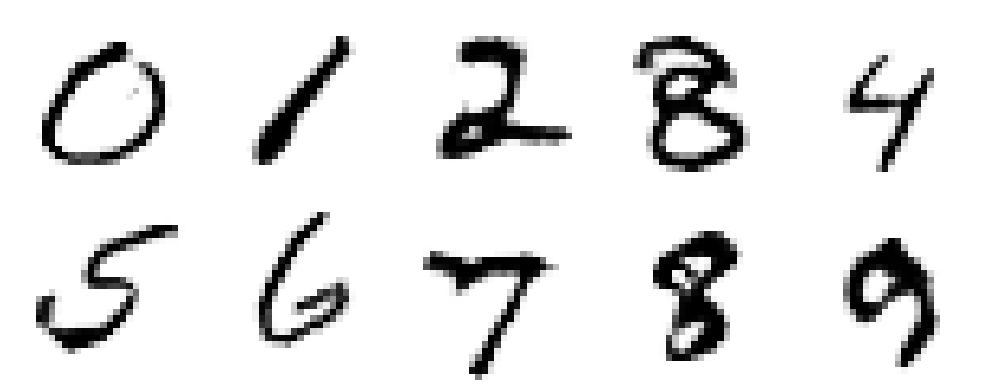

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 2.1326e-04 - loss: 0.5320 - gen_loss: 0.2988 - real_loss: 0.2332
Epoch 111/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 8.9390e-04 - loss: 0.5297 - gen_loss: 0.2929 - real_loss: 0.2368

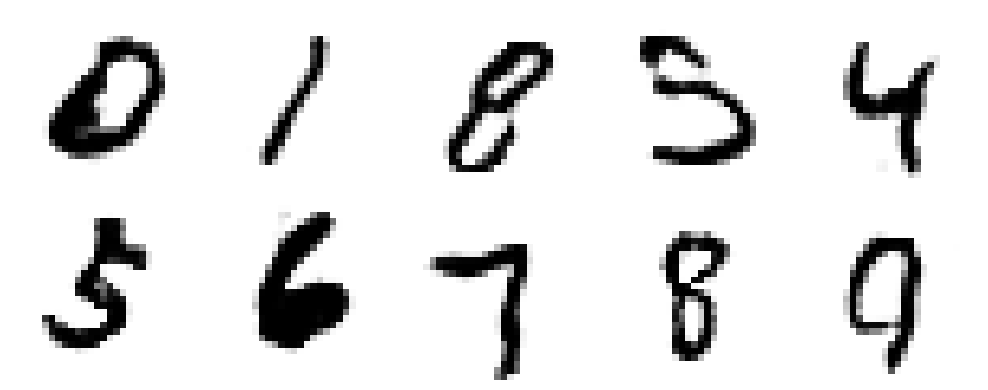

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 8.9324e-04 - loss: 0.5296 - gen_loss: 0.2929 - real_loss: 0.2368
Epoch 112/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 1.6310e-04 - loss: 0.5275 - gen_loss: 0.2904 - real_loss: 0.2371

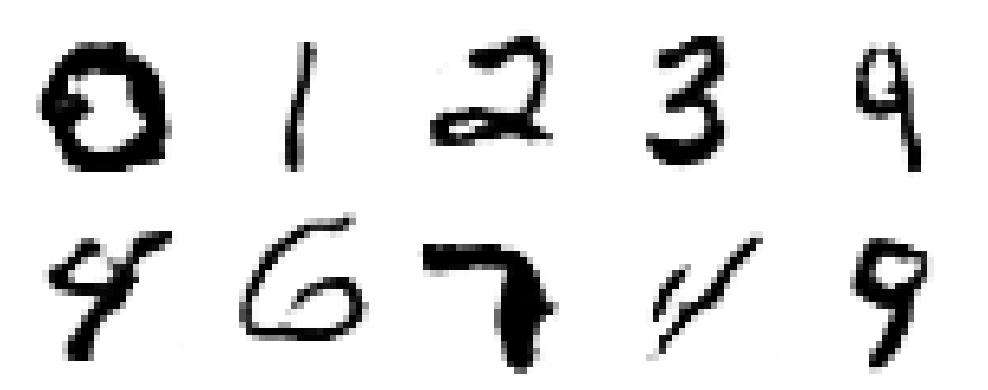

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 1.0000 - acc_gen: 1.6334e-04 - loss: 0.5275 - gen_loss: 0.2903 - real_loss: 0.2371
Epoch 113/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0024 - loss: 0.5572 - gen_loss: 0.3391 - real_loss: 0.2181

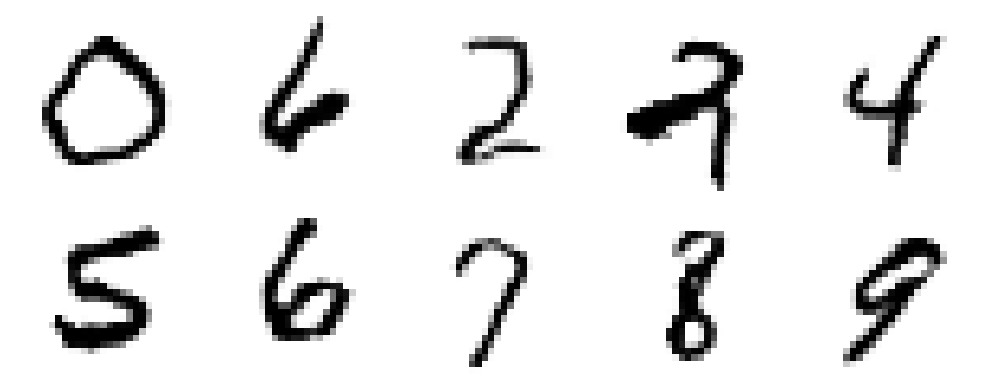

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 0.0024 - loss: 0.5572 - gen_loss: 0.3391 - real_loss: 0.2181
Epoch 114/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9996 - acc_gen: 0.0039 - loss: 0.5663 - gen_loss: 0.3538 - real_loss: 0.2125

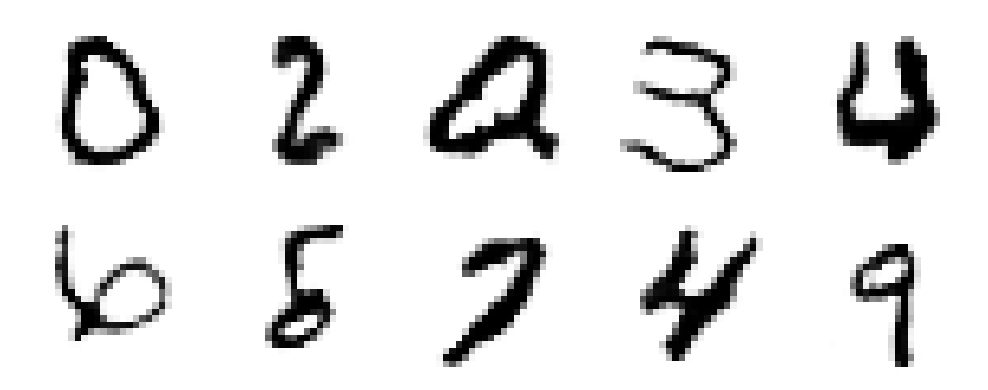

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9996 - acc_gen: 0.0039 - loss: 0.5663 - gen_loss: 0.3539 - real_loss: 0.2125
Epoch 115/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9992 - acc_gen: 0.0116 - loss: 0.5820 - gen_loss: 0.3763 - real_loss: 0.2056

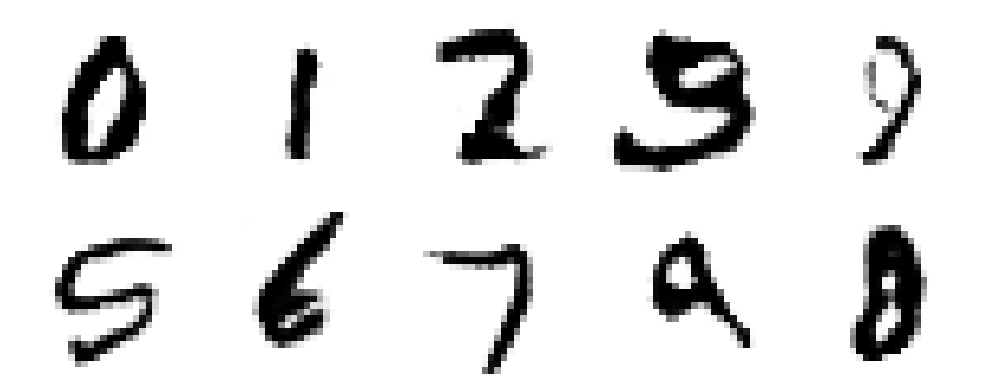

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9992 - acc_gen: 0.0116 - loss: 0.5820 - gen_loss: 0.3763 - real_loss: 0.2056
Epoch 116/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9993 - acc_gen: 0.0160 - loss: 0.5893 - gen_loss: 0.3870 - real_loss: 0.2022

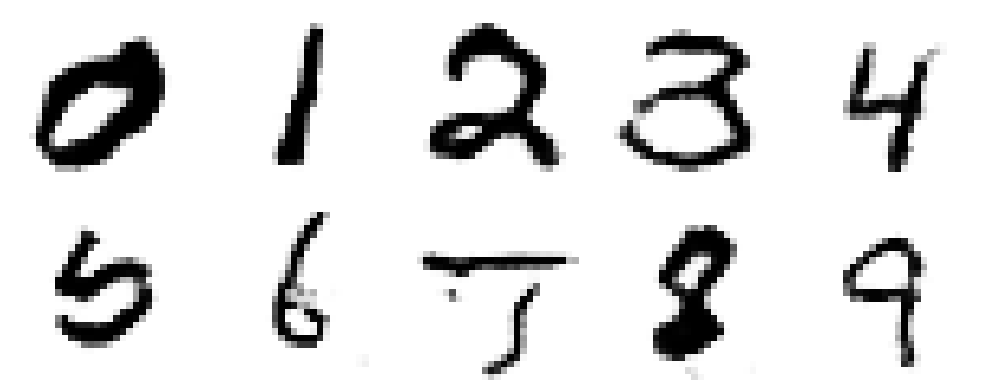

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9993 - acc_gen: 0.0160 - loss: 0.5893 - gen_loss: 0.3870 - real_loss: 0.2023
Epoch 117/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9991 - acc_gen: 0.0075 - loss: 0.5884 - gen_loss: 0.3853 - real_loss: 0.2031

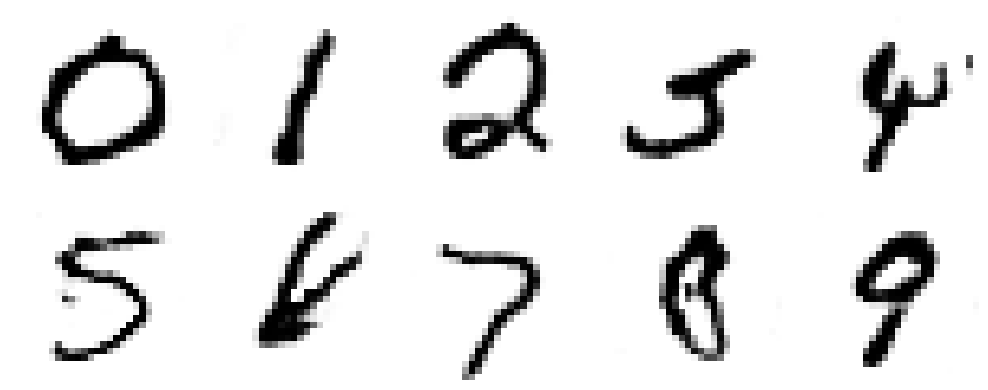

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9991 - acc_gen: 0.0075 - loss: 0.5885 - gen_loss: 0.3854 - real_loss: 0.2031
Epoch 118/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9990 - acc_gen: 0.0176 - loss: 0.5685 - gen_loss: 0.3511 - real_loss: 0.2174

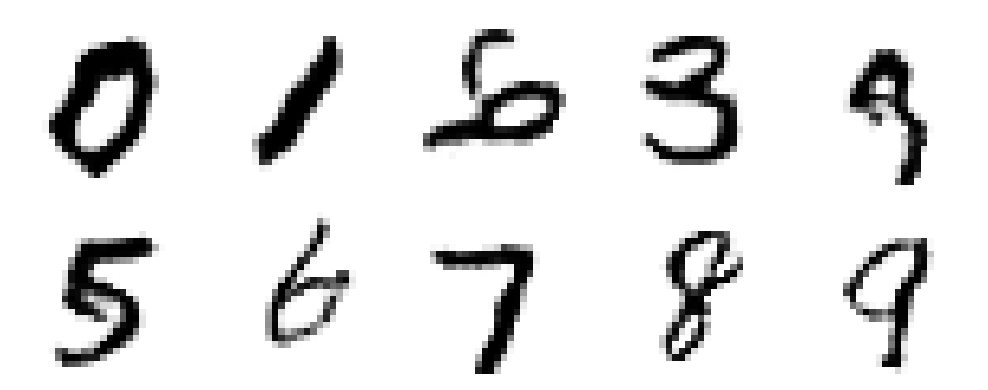

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9990 - acc_gen: 0.0176 - loss: 0.5684 - gen_loss: 0.3510 - real_loss: 0.2174
Epoch 119/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 0.0027 - loss: 0.5422 - gen_loss: 0.3130 - real_loss: 0.2292

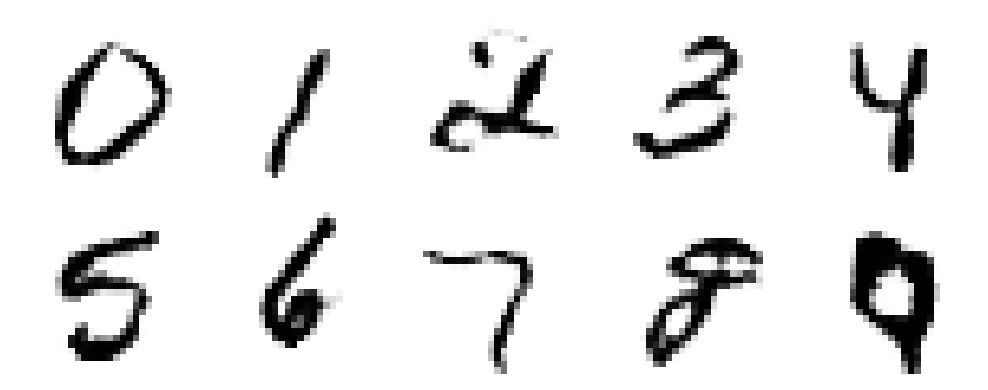

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 0.0027 - loss: 0.5423 - gen_loss: 0.3130 - real_loss: 0.2292
Epoch 120/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 0.0038 - loss: 0.5502 - gen_loss: 0.3263 - real_loss: 0.2238

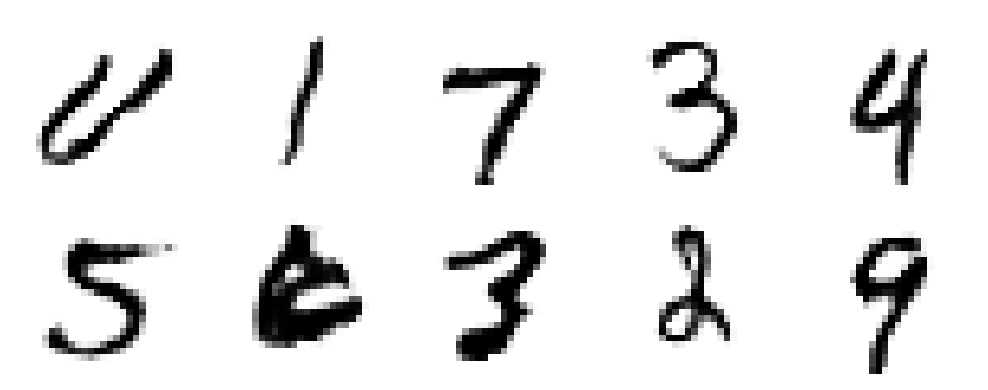

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9997 - acc_gen: 0.0038 - loss: 0.5502 - gen_loss: 0.3263 - real_loss: 0.2238
Epoch 121/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 8.3670e-04 - loss: 0.5220 - gen_loss: 0.2791 - real_loss: 0.2429

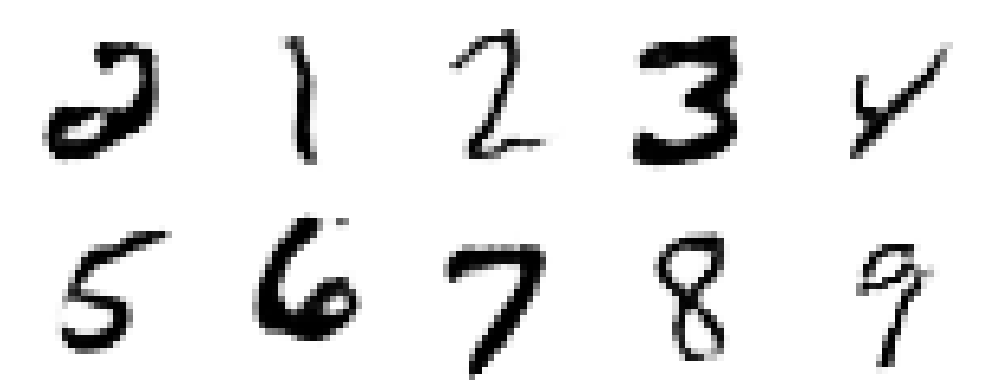

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9997 - acc_gen: 8.3616e-04 - loss: 0.5220 - gen_loss: 0.2791 - real_loss: 0.2429
Epoch 122/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 2.9078e-04 - loss: 0.5218 - gen_loss: 0.2813 - real_loss: 0.2405

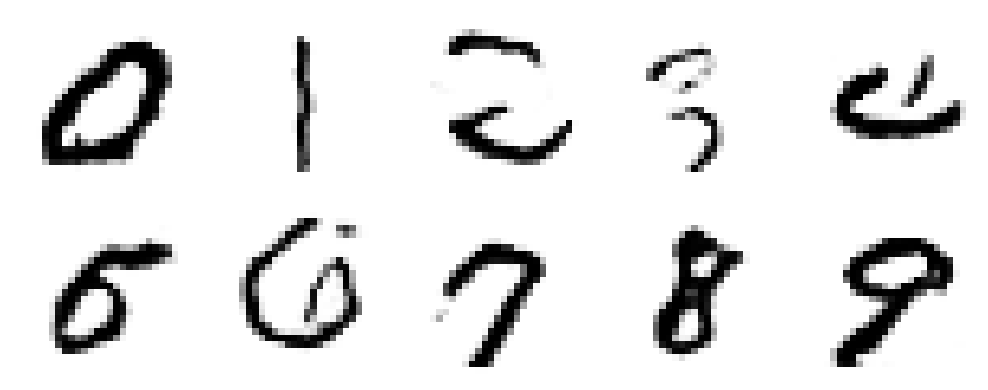

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 2.9082e-04 - loss: 0.5218 - gen_loss: 0.2813 - real_loss: 0.2405
Epoch 123/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 6.0419e-04 - loss: 0.5268 - gen_loss: 0.2893 - real_loss: 0.2375

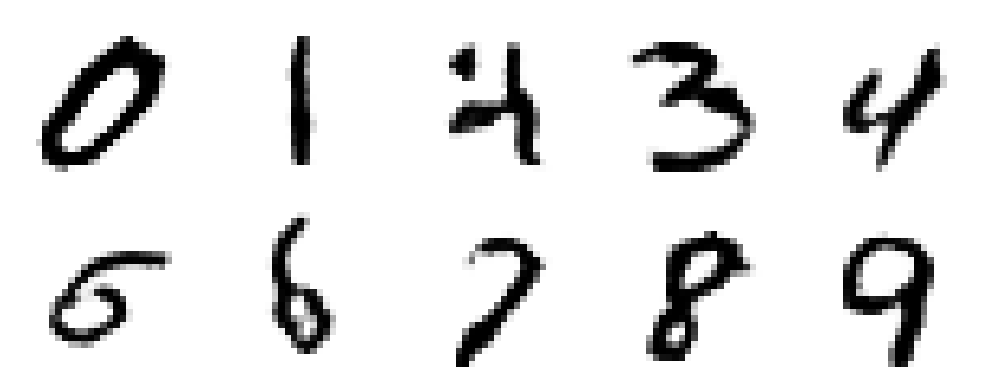

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 6.0435e-04 - loss: 0.5267 - gen_loss: 0.2892 - real_loss: 0.2375
Epoch 124/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 0.0010 - loss: 0.5359 - gen_loss: 0.3038 - real_loss: 0.2321

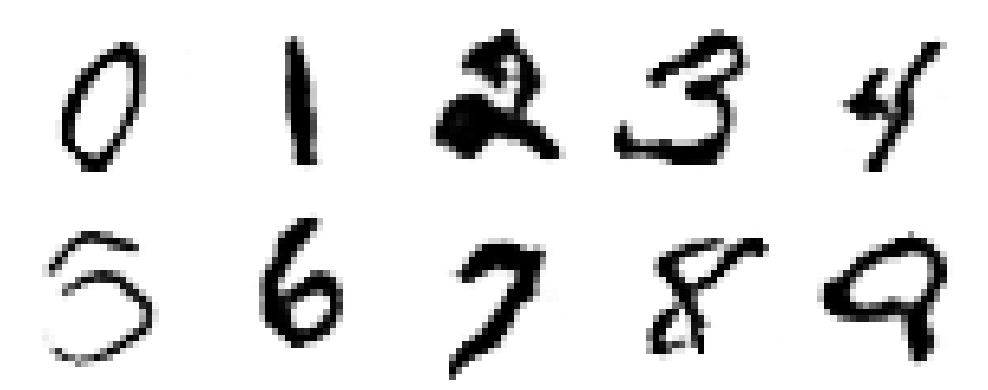

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 0.0010 - loss: 0.5358 - gen_loss: 0.3037 - real_loss: 0.2320
Epoch 125/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 8.6876e-04 - loss: 0.5320 - gen_loss: 0.2979 - real_loss: 0.2340

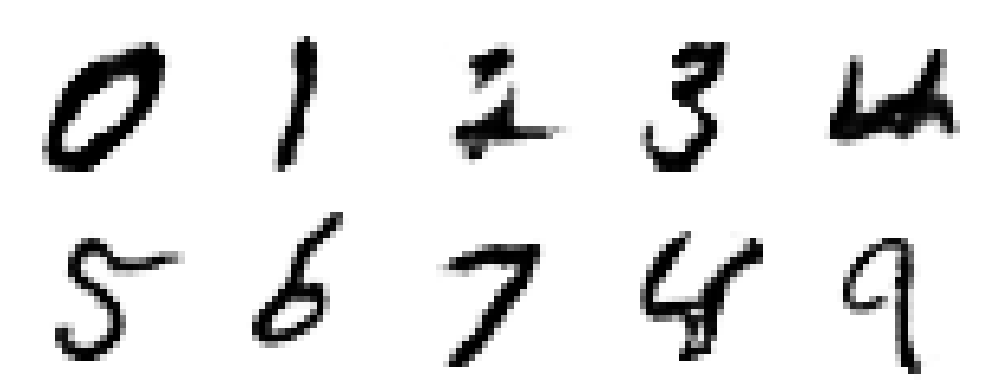

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 8.6992e-04 - loss: 0.5319 - gen_loss: 0.2979 - real_loss: 0.2340
Epoch 126/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9996 - acc_gen: 0.0023 - loss: 0.5520 - gen_loss: 0.3288 - real_loss: 0.2232

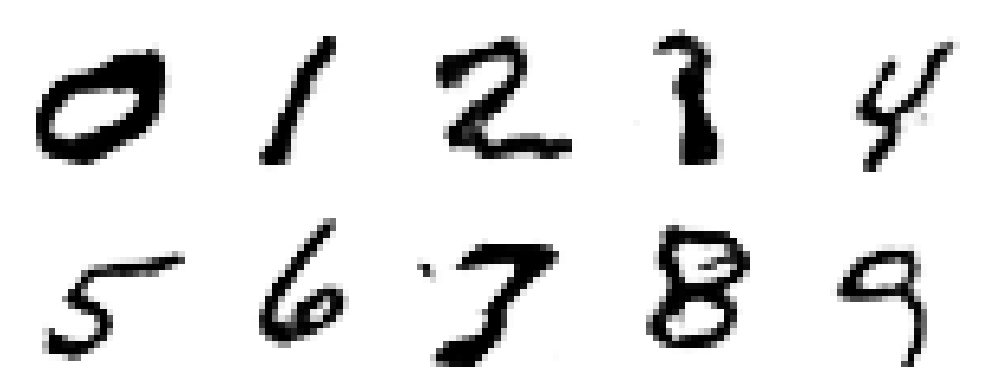

1000/1000 [==============================] - 57s 57ms/step - acc_disc: 0.9996 - acc_gen: 0.0023 - loss: 0.5520 - gen_loss: 0.3287 - real_loss: 0.2232
Epoch 127/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 7.9311e-04 - loss: 0.5270 - gen_loss: 0.2900 - real_loss: 0.2371

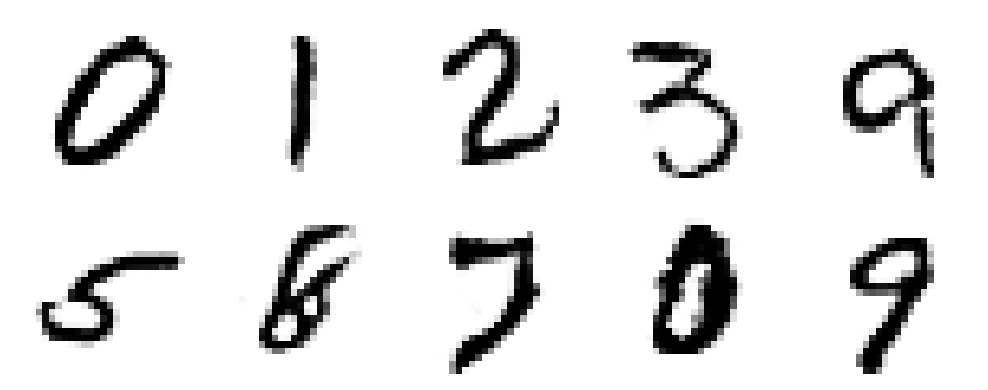

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 7.9281e-04 - loss: 0.5270 - gen_loss: 0.2899 - real_loss: 0.2371
Epoch 128/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 7.2080e-04 - loss: 0.5186 - gen_loss: 0.2746 - real_loss: 0.2440

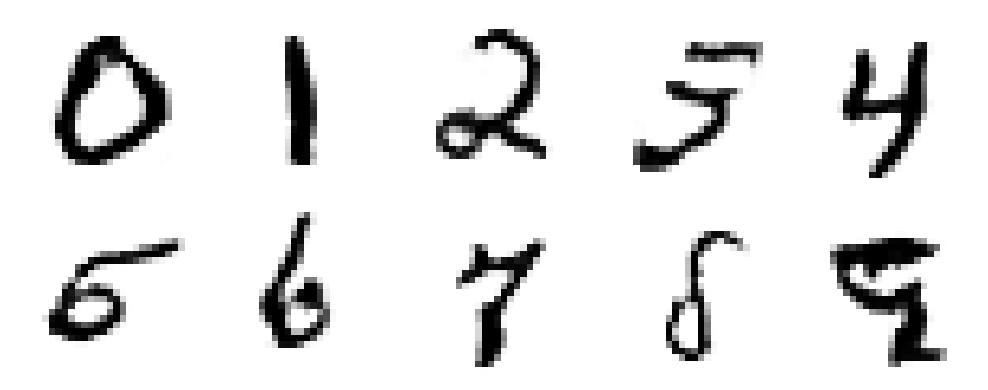

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 7.2029e-04 - loss: 0.5186 - gen_loss: 0.2746 - real_loss: 0.2440
Epoch 129/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 7.6055e-05 - loss: 0.5160 - gen_loss: 0.2729 - real_loss: 0.2431

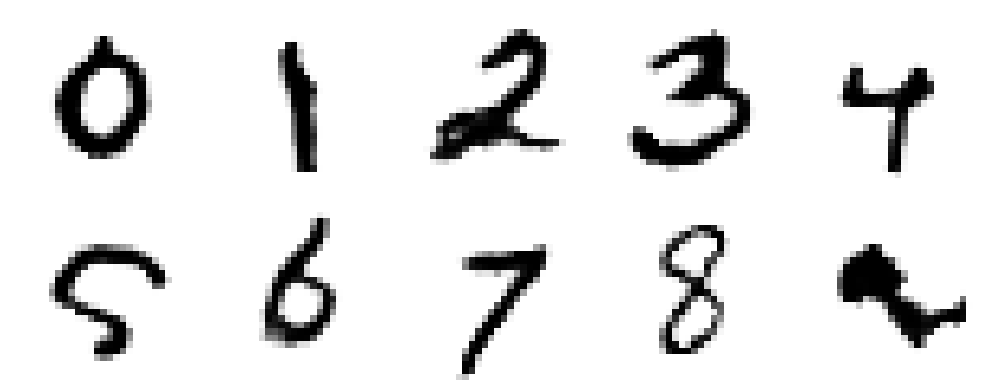

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 7.6128e-05 - loss: 0.5160 - gen_loss: 0.2729 - real_loss: 0.2431
Epoch 130/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 9.1994e-05 - loss: 0.5194 - gen_loss: 0.2777 - real_loss: 0.2417

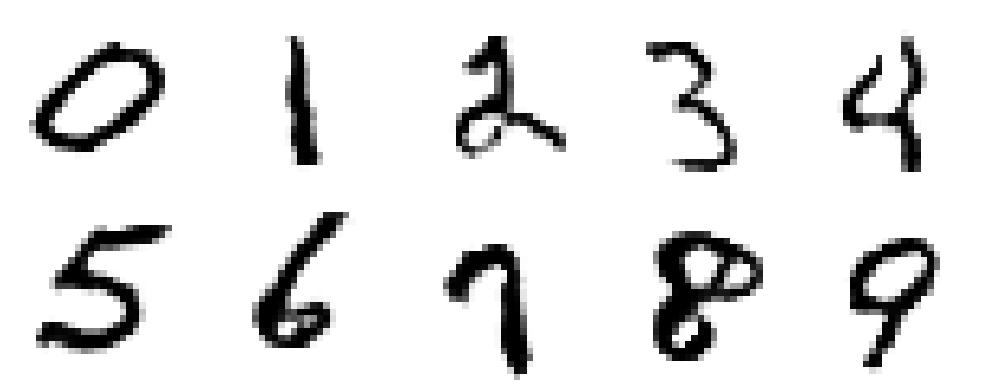

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 9.2002e-05 - loss: 0.5194 - gen_loss: 0.2777 - real_loss: 0.2417
Epoch 131/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 1.0109e-04 - loss: 0.5154 - gen_loss: 0.2724 - real_loss: 0.2430

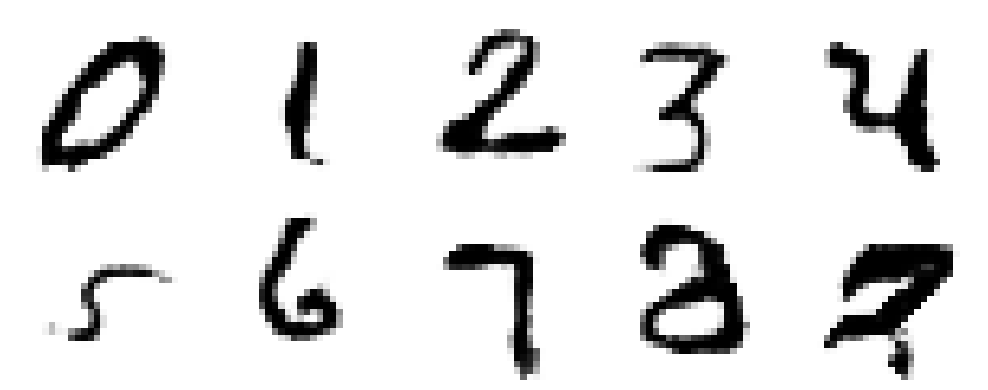

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 1.0112e-04 - loss: 0.5154 - gen_loss: 0.2724 - real_loss: 0.2430
Epoch 132/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 8.8522e-05 - loss: 0.5223 - gen_loss: 0.2827 - real_loss: 0.2397

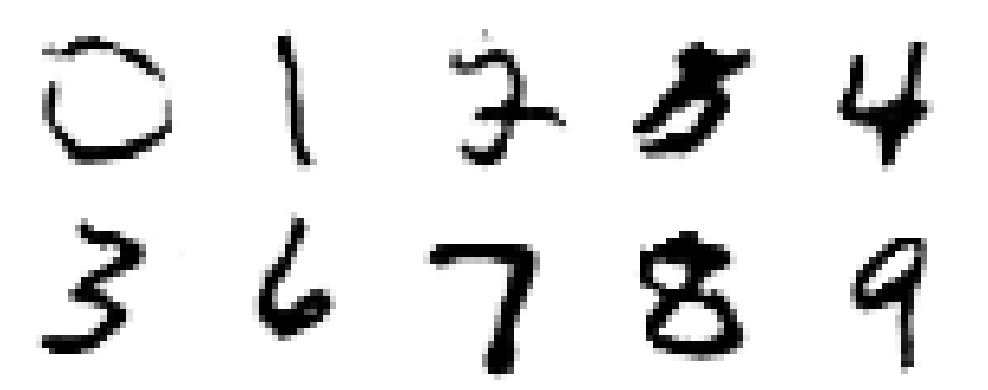

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 8.9078e-05 - loss: 0.5223 - gen_loss: 0.2827 - real_loss: 0.2397
Epoch 133/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 4.4228e-04 - loss: 0.5317 - gen_loss: 0.2987 - real_loss: 0.2330

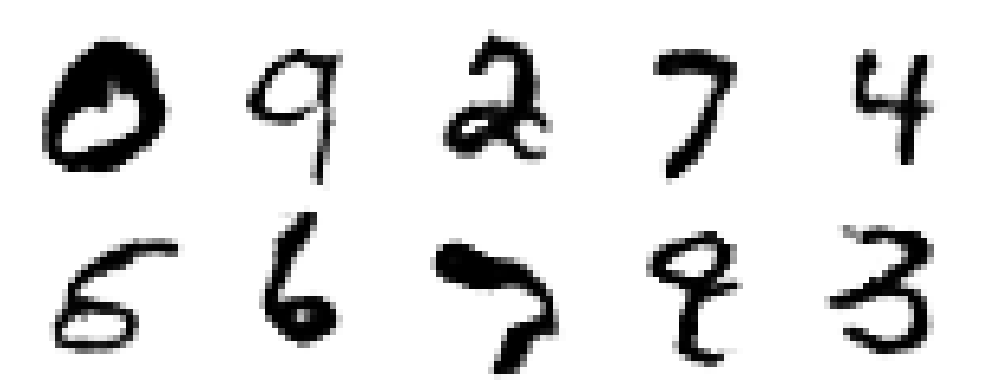

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 4.4846e-04 - loss: 0.5318 - gen_loss: 0.2988 - real_loss: 0.2330
Epoch 134/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9995 - acc_gen: 0.0057 - loss: 0.5465 - gen_loss: 0.3189 - real_loss: 0.2275

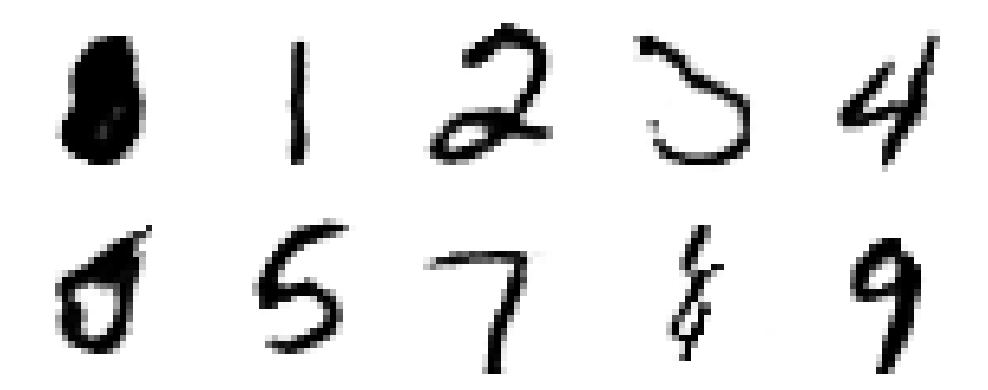

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9995 - acc_gen: 0.0057 - loss: 0.5464 - gen_loss: 0.3189 - real_loss: 0.2275
Epoch 135/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 1.0000 - acc_gen: 5.4325e-04 - loss: 0.5237 - gen_loss: 0.2838 - real_loss: 0.2399

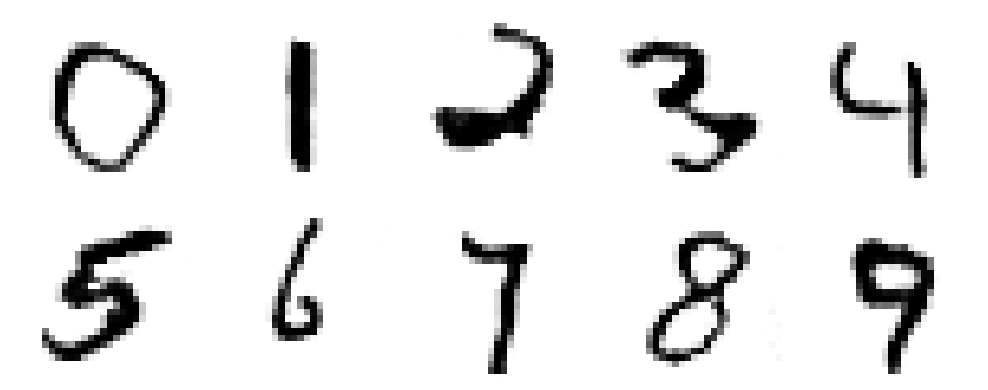

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 1.0000 - acc_gen: 5.4314e-04 - loss: 0.5238 - gen_loss: 0.2838 - real_loss: 0.2399
Epoch 136/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 8.2426e-04 - loss: 0.5423 - gen_loss: 0.3140 - real_loss: 0.2282

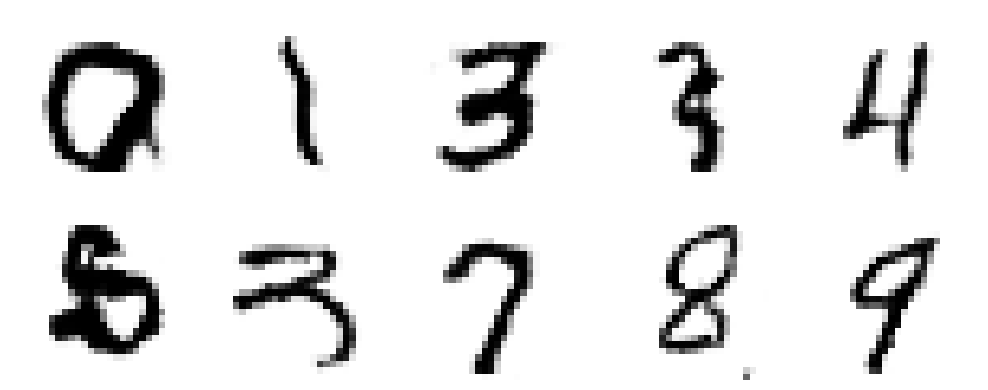

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 8.2681e-04 - loss: 0.5424 - gen_loss: 0.3142 - real_loss: 0.2282
Epoch 137/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9994 - acc_gen: 0.0090 - loss: 0.5747 - gen_loss: 0.3645 - real_loss: 0.2102

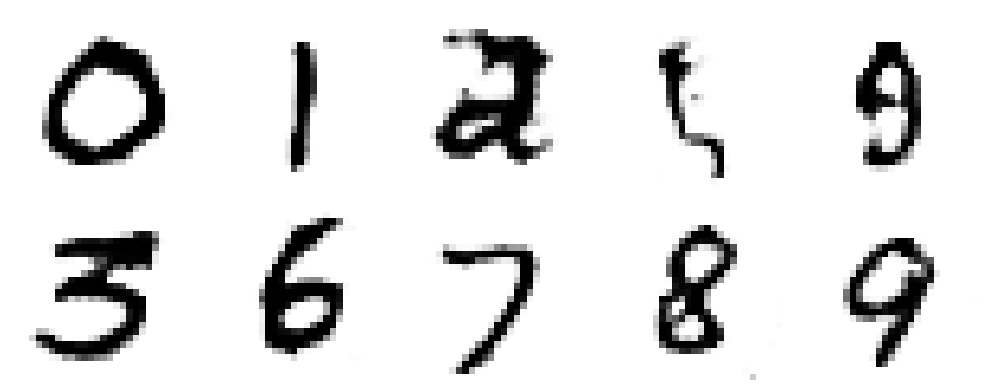

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9994 - acc_gen: 0.0090 - loss: 0.5747 - gen_loss: 0.3645 - real_loss: 0.2102
Epoch 138/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 0.0014 - loss: 0.5433 - gen_loss: 0.3148 - real_loss: 0.2285

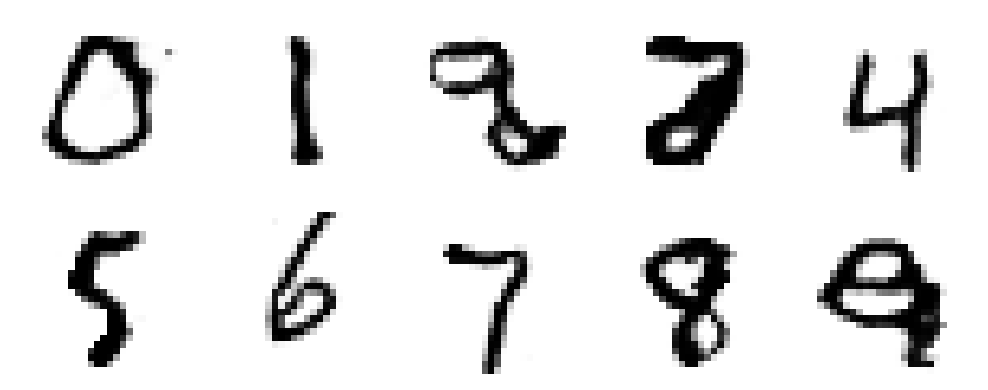

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9999 - acc_gen: 0.0014 - loss: 0.5433 - gen_loss: 0.3148 - real_loss: 0.2285
Epoch 139/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 0.0030 - loss: 0.5488 - gen_loss: 0.3234 - real_loss: 0.2254

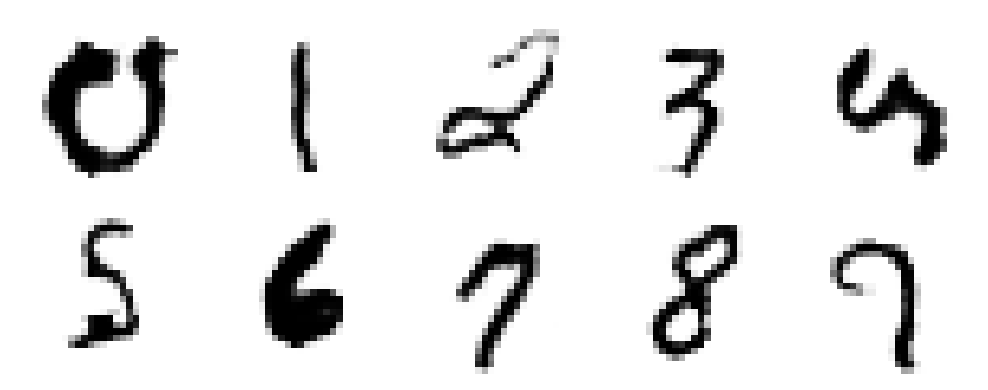

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9997 - acc_gen: 0.0031 - loss: 0.5487 - gen_loss: 0.3233 - real_loss: 0.2254
Epoch 140/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9996 - acc_gen: 0.0059 - loss: 0.5490 - gen_loss: 0.3249 - real_loss: 0.2240

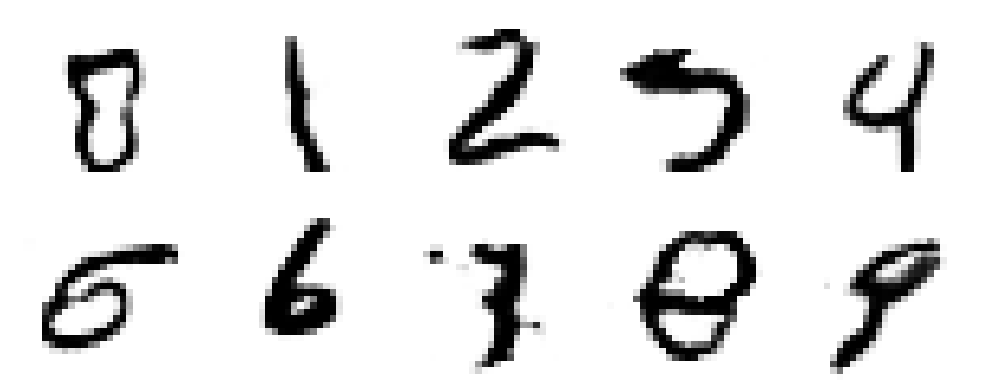

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9996 - acc_gen: 0.0059 - loss: 0.5492 - gen_loss: 0.3251 - real_loss: 0.2241
Epoch 141/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9986 - acc_gen: 0.0128 - loss: 0.5644 - gen_loss: 0.3447 - real_loss: 0.2197

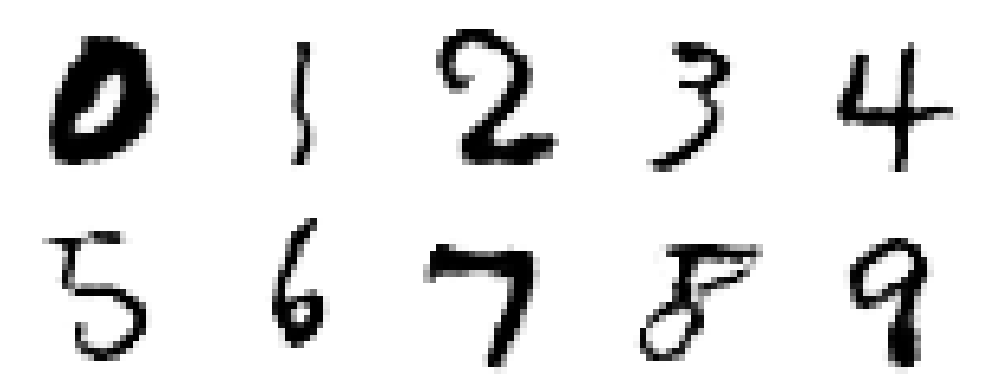

1000/1000 [==============================] - 53s 53ms/step - acc_disc: 0.9986 - acc_gen: 0.0128 - loss: 0.5644 - gen_loss: 0.3447 - real_loss: 0.2197
Epoch 142/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0044 - loss: 0.5412 - gen_loss: 0.3103 - real_loss: 0.2309

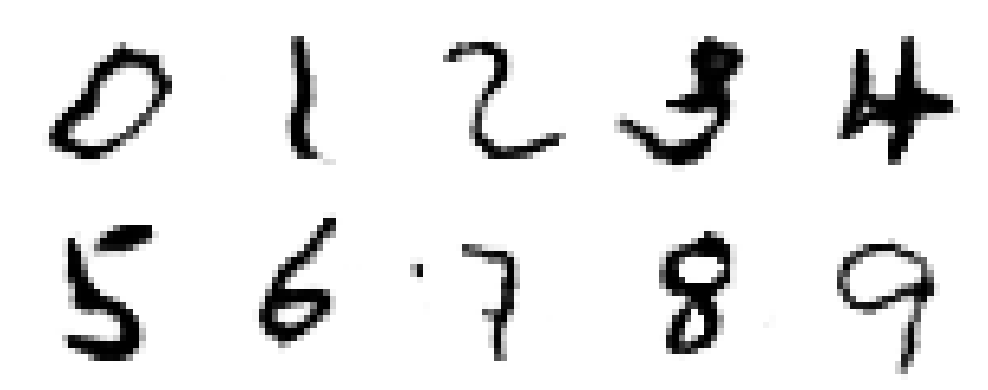

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9998 - acc_gen: 0.0044 - loss: 0.5412 - gen_loss: 0.3103 - real_loss: 0.2309
Epoch 143/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 6.5090e-04 - loss: 0.5141 - gen_loss: 0.2699 - real_loss: 0.2442

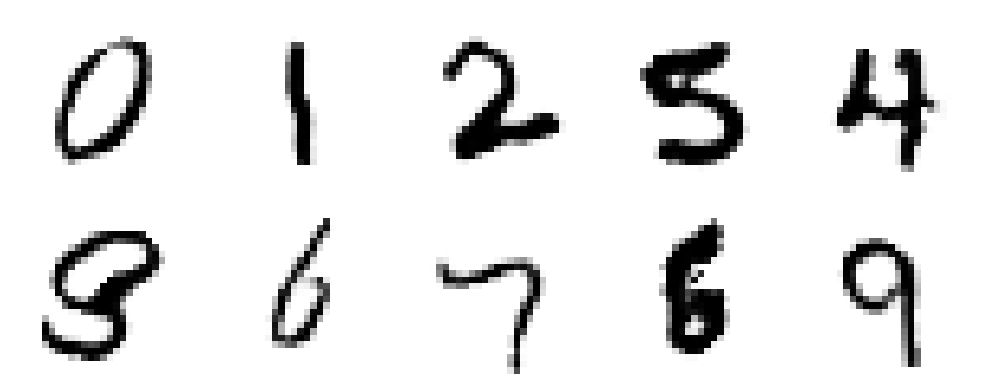

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 6.5060e-04 - loss: 0.5141 - gen_loss: 0.2700 - real_loss: 0.2441
Epoch 144/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 0.0033 - loss: 0.5459 - gen_loss: 0.3186 - real_loss: 0.2273

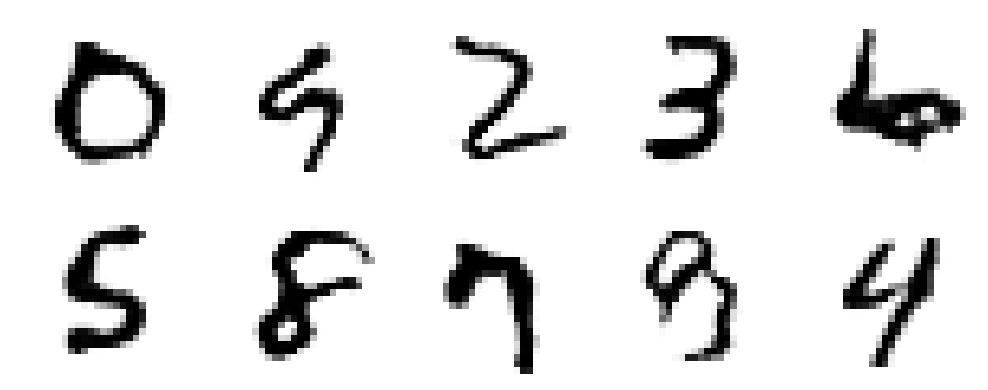

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9997 - acc_gen: 0.0033 - loss: 0.5459 - gen_loss: 0.3186 - real_loss: 0.2273
Epoch 145/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0149 - loss: 0.5456 - gen_loss: 0.3168 - real_loss: 0.2288

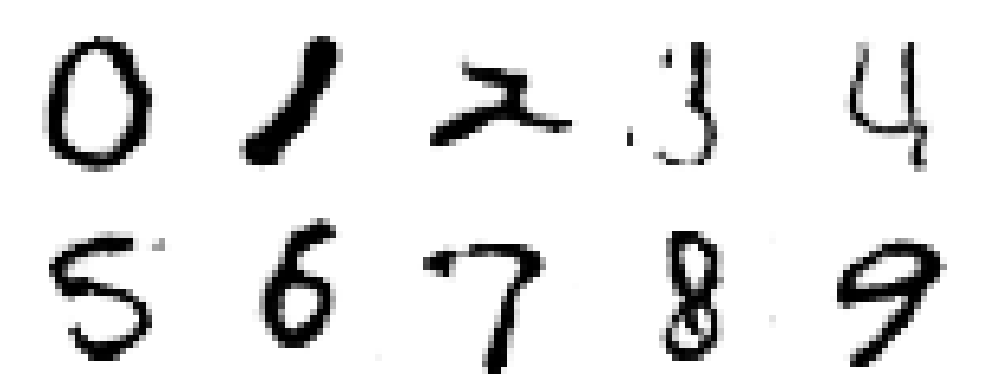

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 0.0149 - loss: 0.5456 - gen_loss: 0.3167 - real_loss: 0.2289
Epoch 146/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 0.0037 - loss: 0.5480 - gen_loss: 0.3230 - real_loss: 0.2250

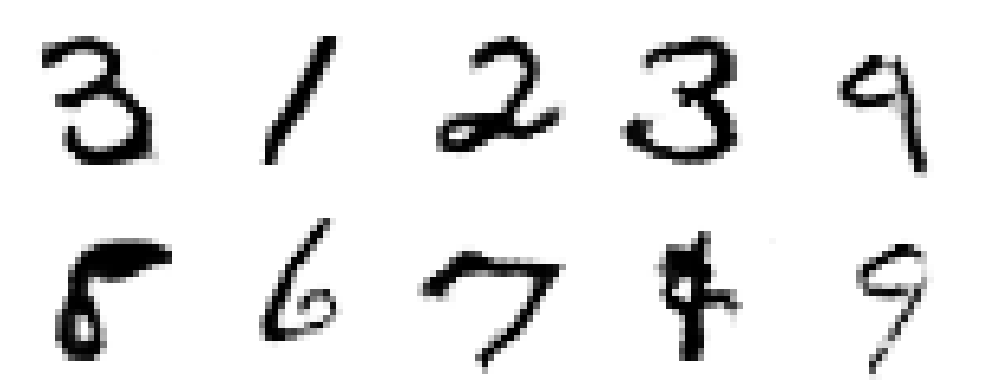

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9997 - acc_gen: 0.0037 - loss: 0.5479 - gen_loss: 0.3229 - real_loss: 0.2250
Epoch 147/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9997 - acc_gen: 0.0025 - loss: 0.5409 - gen_loss: 0.3106 - real_loss: 0.2303

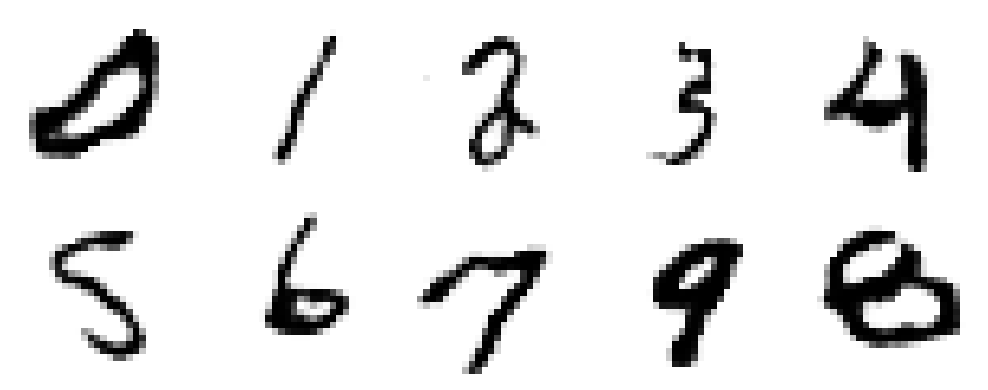

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9997 - acc_gen: 0.0025 - loss: 0.5409 - gen_loss: 0.3106 - real_loss: 0.2303
Epoch 148/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0028 - loss: 0.5389 - gen_loss: 0.3060 - real_loss: 0.2329

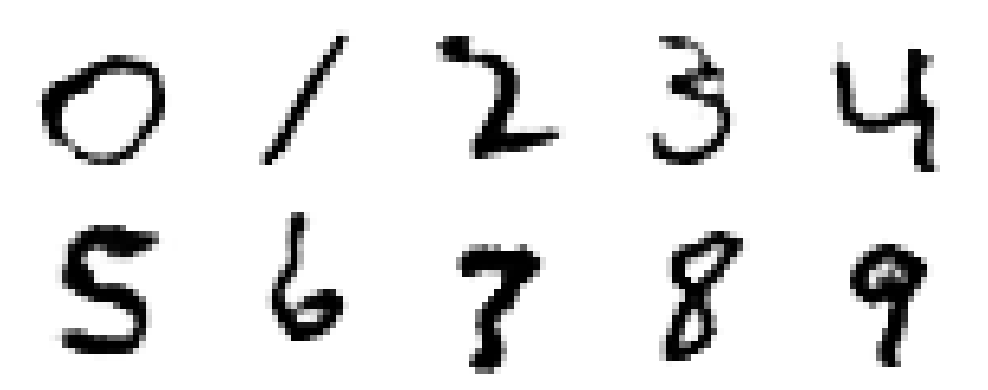

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9998 - acc_gen: 0.0028 - loss: 0.5389 - gen_loss: 0.3060 - real_loss: 0.2329
Epoch 149/150
 999/1000 [============================>.] - ETA: 0s - acc_disc: 0.9999 - acc_gen: 1.9859e-04 - loss: 0.5246 - gen_loss: 0.2857 - real_loss: 0.2389

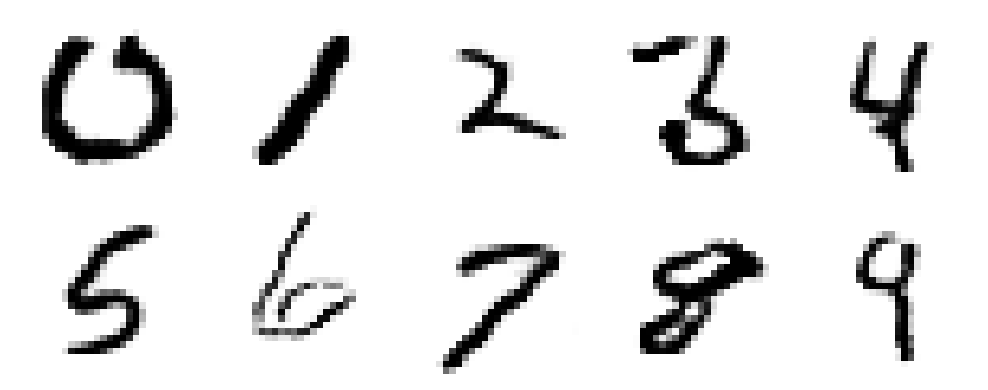

1000/1000 [==============================] - 49s 49ms/step - acc_disc: 0.9999 - acc_gen: 1.9870e-04 - loss: 0.5246 - gen_loss: 0.2857 - real_loss: 0.2389
Epoch 150/150
1000/1000 [==============================] - ETA: 0s - acc_disc: 0.9998 - acc_gen: 0.0035 - loss: 0.5468 - gen_loss: 0.3205 - real_loss: 0.2263

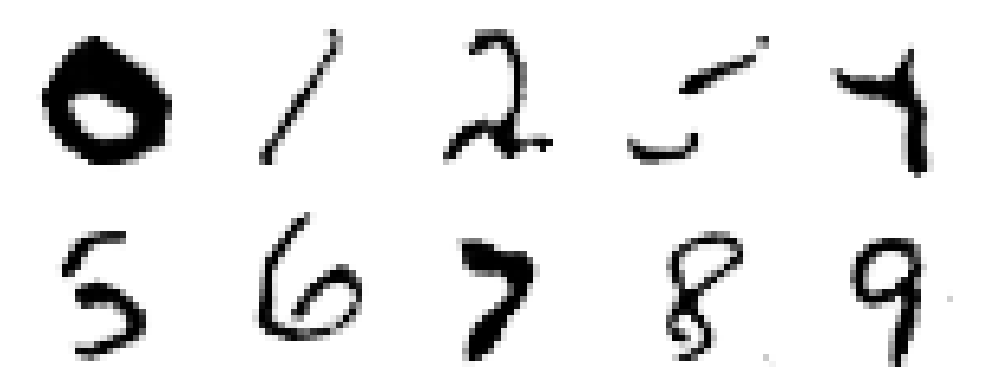

1000/1000 [==============================] - 48s 48ms/step - acc_disc: 0.9998 - acc_gen: 0.0035 - loss: 0.5467 - gen_loss: 0.3204 - real_loss: 0.2263


In [7]:
h = model.fit(
    x_train,y_train, epochs=150, batch_size=60,
    callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images)]
).history

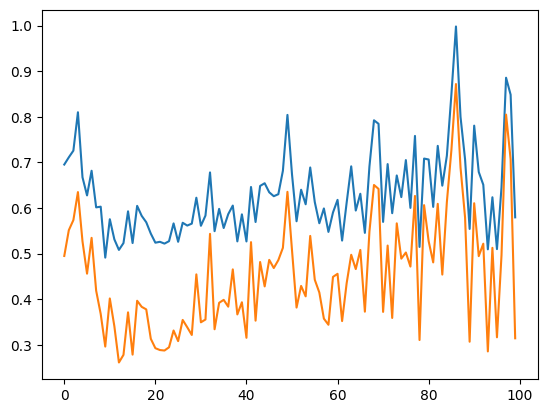

In [ ]:
plt.plot(h["loss"])
plt.plot(h["gen_loss"])